In [1]:
import os
import sys
import ast
import math
import swifter
import csv
import json
import numpy as np
import pandas as pd
import datetime as dt
import itertools as it
import portion as P
from collections import namedtuple
from pprint import pprint
from tqdm.notebook import tqdm

import matplotlib.pylab as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pdir = os.path.abspath(os.path.join(os.getcwd(), '.'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

# Functions & Methods

In [2]:
###
def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # LTE & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'lte':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

# Main

In [3]:
### TODO: Check Root Folder
root = '/Users/jackbedford/Desktop/MOXA/Code/data'
# root = '/home/wmnlab/D/database'

md_files = []
paths = [s for s in os.listdir(root) if s.startswith('202') and os.path.isdir(os.path.join(root, s))]

for date_dir in paths:
    date_dir = os.path.join(root, date_dir)
    md_file = [os.path.join(date_dir, s) for s in os.listdir(date_dir) if s.endswith('.md')]
    md_files += md_file

md_files = sorted(md_files)
# pprint(md_files)

### Define Class
class Experiment():
    ID = 0
    def __init__(self, dirpath, setting):
        self.id = "{:02d}".format(Experiment.ID)
        self.dirpath = dirpath
        self.date = os.path.basename(os.path.dirname(dirpath))
        self.name = os.path.basename(dirpath)
        self.setting = json.loads(setting)
        self.dev_traces = {}
        self.traces = []
        self.rrc_paths = {}
        self.lte_paths = {}
        self.nr_paths = {}
        self.ul_paths = {}
        self.dl_paths = {}
        self.metadata = None
        self.metadata_dual = None
        self.ranking = {}
        self.ranking_dual = {}
        Experiment.ID += 1
    def __repr__(self):
        return f'Experiment {self.id}: ./{self.date}/{self.name} -> {self.setting}'

### Construct Class Instances
exp_list = []

for md_file in md_files:
    
    with open(md_file, 'r') as f:
        lines = []
        l = f.readline()[:-1]
        
        while l:
            if l == '#endif':
                break
            lines.append(l)
            l = f.readline()[:-1]
        
    for expr, sett in zip(lines[::2], lines[1::2]):
        parent_dir = os.path.dirname(md_file)
        experiment = Experiment(os.path.join(parent_dir, expr), sett)
        exp_list.append(experiment)

pprint(exp_list)

[Experiment 00: ./2023-03-16/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 01: ./2023-03-26/Bandlock_Udp_All_RM500Q -> {'qc00': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 02: ./2023-04-01/Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q -> {'qc00': 'B1B3', 'qc01': 'B1B8', 'qc02': 'LTE', 'qc03': 'All'},
 Experiment 03: ./2023-04-01/Bandlock_Udp_B1_B3_B7_B8_RM500Q -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 04: ./2023-04-10/Experiment1 -> {'qc00': 'All', 'qc01': 'All', 'qc02': 'All', 'qc03': 'All'},
 Experiment 05: ./2023-04-10/Experiment2 -> {'qc00': 'B1', 'qc01': 'B3', 'qc02': 'B7', 'qc03': 'B8'},
 Experiment 06: ./2023-04-10/Experiment3 -> {'qc00': 'LTE', 'qc01': 'All', 'qc02': 'B7B8', 'qc03': 'B7'},
 Experiment 07: ./2023-04-17/Bandlock_Udp_All_LTE_All_LTE_RM500Q -> {'qc00': 'All', 'qc01': 'LTE', 'qc02': 'All', 'qc03': 'LTE'},
 Experiment 08: ./2023-04-17/Bandlock_Udp_All_LTE_B1_B3_RM500Q -> {'qc00': 'All', 'qc01': 'L

In [4]:
### TODO: Select Experiments
selected_indices = [21, 22]

exp_list = [exp_list[i] for i in selected_indices]
look_up_table = {exp_list[i].id : i for i, expr in enumerate(exp_list)}

print(look_up_table)
print(exp_list)

{'21': 0, '22': 1}
[Experiment 21: ./2023-06-15/Bandlock_All_B3_B7_B8_Dupl_Phone -> {'sm00': 'All', 'sm01': 'All', 'sm02': 'B3', 'sm03': 'B3', 'sm04': 'B7', 'sm05': 'B7', 'sm06': 'B8', 'sm07': 'B8'}, Experiment 22: ./2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone -> {'sm00': 'LTE', 'sm01': 'LTE', 'sm02': 'B3', 'sm03': 'B3', 'sm04': 'B7', 'sm05': 'B7', 'sm06': 'B8', 'sm07': 'B8'}]


## Metadata

In [5]:
nr_check_tables = []

for expr in exp_list:
    # Feed-In Metadata
    for dev in expr.setting.keys():
        dev_dir = os.path.join(expr.dirpath, dev)
        traces = [s for s in sorted(os.listdir(dev_dir)) if s.startswith('#')]
        expr.dev_traces[dev] = ', '.join(traces)

    expr.traces = list(expr.dev_traces.values())[0].split(', ')
    merged_dict = {}
    for key in expr.setting:
        merged_dict[key] = (expr.setting[key], expr.dev_traces[key])
        
    expr.metadata = pd.DataFrame(merged_dict.values(), index=merged_dict.keys(), columns=['Schm', 'Traces']).reset_index().rename(columns={'index':'Device'})

    # Print Out Metadata
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)

    # Feed-In Data Path
    for dev in expr.setting.keys():
        expr.rrc_paths[dev], expr.lte_paths[dev], expr.nr_paths[dev], expr.ul_paths[dev], expr.dl_paths[dev] = [], [], [], [], []
        
        for trace in expr.traces:
            data_dir = os.path.join(expr.dirpath, dev, trace, 'data')
            expr.rrc_paths[dev] += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_rrc.pkl')]
            expr.lte_paths[dev] += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_ml1.pkl') and not s.endswith('_nr_ml1.pkl')]
            expr.nr_paths[dev] += [os.path.join(data_dir, s) for s in os.listdir(data_dir) if s.endswith('_nr_ml1.pkl')]
            expr.ul_paths[dev] += [os.path.join(data_dir, 'udp_uplk_loss_latency.pkl')]
            expr.dl_paths[dev] += [os.path.join(data_dir, 'udp_dnlk_loss_latency.pkl')]
    
    # Check NR Alive
    if os.path.isfile(os.path.join(expr.dirpath, 'nr_alive_checktable.csv')):
        table = pd.read_csv(os.path.join(expr.dirpath, 'nr_alive_checktable.csv'))
    else:
        devices = expr.setting.keys()
        traces = expr.traces
        # print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
        
        table = pd.DataFrame(columns=['Tr.', *devices])
        for i, trace in enumerate(tqdm(traces, ncols=1000)):
            check_list = [trace] + ['O'] * len(devices)
            for j, dev in enumerate(devices):
                data = expr.rrc_paths[dev][i]
                # print(data, os.path.isfile(data))
                df, _, _ = mi_parse_ho(pd.read_pickle(data), tz=8)
                if sum(df['cause'] == 'rlc-MaxNumRetx (2)') > 0:
                    check_list[j+1] = '∆'
                data = expr.nr_paths[dev][i]
                # print(data, os.path.isfile(data))
                df = pd.read_pickle(data)
                if df.empty:
                    check_list[j+1] = 'X'
            table.loc[len(table)] = check_list
        
        table.to_csv(os.path.join(expr.dirpath, 'nr_alive_checktable.csv'), index=False)

    nr_check_tables.append(table)
    
    display(table)
    print('O: RF Module is always on.')
    print('∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!')
    print('X: RF Module has never been turned on. It could be under pure LTE or an anomaly.')
    print()

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces
0   sm00  All  #01, #02, #03, #04
1   sm01  All  #01, #02, #03, #04
2   sm02   B3  #01, #02, #03, #04
3   sm03   B3  #01, #02, #03, #04
4   sm04   B7  #01, #02, #03, #04
5   sm05   B7  #01, #02, #03, #04
6   sm06   B8  #01, #02, #03, #04
7   sm07   B8  #01, #02, #03, #04

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    O    O    O    O    O    O    O    O
1  #02    O    O    O    O    O    O    O    O
2  #03    O    O    O    O    O    O    O    O
3  #04    O    O    O    O    O    O    O    O

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces
0   sm00  LTE  #01, #02, #03, #04, #05, #06
1   sm01  LTE  #01, #02, #03, #04, #05, #06
2   sm02   B3  #01, #02, #03, #04, #05, #06
3   sm03   B3  #01, #02, #03, #04, #05, #06
4   sm04   B7  #01, #02, #03, #04, #05, #06
5   sm05   B7  #01, #02, #03, #04, #05, #06
6   sm06   B8  #01, #02, #03, #04, #05, #06
7   sm07   B8  #01, #02, #03, #04, #05, #06

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    X    X    O    O    O    O    O    O
1  #02    X    X    O    O    O    ∆    ∆    O
2  #03    X    X    O    O    O    O    O    O
3  #04    X    X    O    O    O    O    O    O
4  #05    X    X    O    O    O    O    O    O
5  #06    X    X    O    O    O    O    O    O

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.



In [6]:
def remove_exp_element(remove_list):
    
    for id, dev, tr in remove_list:
        try:
            index = look_up_table[id]
            # print(f'Exp ({id}, {dev}, {tr}) look up succeed!')
        except:
            id_not_found = 1
            for i, expr in enumerate(exp_list):
                if "{:02d}".format(id) == expr.id:
                    id_not_found = 0
                    look_up_table[id] = i
                    index = i
                    break
            if id_not_found:
                print(f'Exp id: {id} not found!')
                continue
            
        if isinstance(tr, str):
            tr_name = tr
            tr_index = exp_list[index].traces.index(tr)
        else:
            tr_name = exp_list[index].traces[tr]
            tr_index = tr
        
        exp_list[index].dev_traces[dev] = ', '.join([s for s in exp_list[index].dev_traces[dev].split(', ') if s != tr_name])
        exp_list[index].rrc_paths[dev][tr_index] = ''
        exp_list[index].lte_paths[dev][tr_index] = ''
        exp_list[index].nr_paths[dev][tr_index] = ''
        exp_list[index].ul_paths[dev][tr_index] = ''
        exp_list[index].dl_paths[dev][tr_index] = ''
    
    for expr in exp_list:
        merged_dict = {}
        for key in expr.setting:
            merged_dict[key] = (expr.setting[key], expr.dev_traces[key])

        expr.metadata = pd.DataFrame(merged_dict.values(), index=merged_dict.keys(), columns=['Schm', 'Traces']).reset_index().rename(columns={'index':'Device'})

### TODO: Remove Abnormal Data
# remove_exp_element([(22, 'sm05', 1), (22, 'sm06', '#02')])

## Selected Data Preview

In [7]:
for expr, nr_table in zip(exp_list, nr_check_tables):
    
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)
    
    # print('rrc_paths')
    # pprint(expr.rrc_paths)
    # print('lte_paths')
    # pprint(expr.lte_paths)
    # print('nr_paths')
    # pprint(expr.nr_paths)
    # print('ul_paths')
    # pprint(expr.ul_paths)
    # print('dl_paths')
    # pprint(expr.dl_paths)
    
    display(nr_table)
    print('O: RF Module is always on.')
    print('∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!')
    print('X: RF Module has never been turned on. It could be under pure LTE or an anomaly.')
    print()

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces
0   sm00  All  #01, #02, #03, #04
1   sm01  All  #01, #02, #03, #04
2   sm02   B3  #01, #02, #03, #04
3   sm03   B3  #01, #02, #03, #04
4   sm04   B7  #01, #02, #03, #04
5   sm05   B7  #01, #02, #03, #04
6   sm06   B8  #01, #02, #03, #04
7   sm07   B8  #01, #02, #03, #04

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    O    O    O    O    O    O    O    O
1  #02    O    O    O    O    O    O    O    O
2  #03    O    O    O    O    O    O    O    O
3  #04    O    O    O    O    O    O    O    O

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces
0   sm00  LTE  #01, #02, #03, #04, #05, #06
1   sm01  LTE  #01, #02, #03, #04, #05, #06
2   sm02   B3  #01, #02, #03, #04, #05, #06
3   sm03   B3  #01, #02, #03, #04, #05, #06
4   sm04   B7  #01, #02, #03, #04, #05, #06
5   sm05   B7  #01, #02, #03, #04, #05, #06
6   sm06   B8  #01, #02, #03, #04, #05, #06
7   sm07   B8  #01, #02, #03, #04, #05, #06

Tr. sm00 sm01 sm02 sm03 sm04 sm05 sm06 sm07
0  #01    X    X    O    O    O    O    O    O
1  #02    X    X    O    O    O    ∆    ∆    O
2  #03    X    X    O    O    O    O    O    O
3  #04    X    X    O    O    O    O    O    O
4  #05    X    X    O    O    O    O    O    O
5  #06    X    X    O    O    O    O    O    O

O: RF Module is always on.
∆: RF Module was turned off midway. "SCG Failure: rlc-MaxNumRetx (2)" occurs!
X: RF Module has never been turned on. It could be under pure LTE or an anomaly.



# Single Radio

In [8]:
import numpy as np

my_list = [9, 3, 7, 1, 5]

# 获取按值排序的索引列表
sorted_indices = [i for i, x in sorted(enumerate(my_list), key=lambda x: x[1])]

print("原始列表:", my_list)
print("按值排序的索引列表:", sorted_indices)

# 使用列表推导式计算ranking
ranking = np.zeros(len(my_list))
ranking[sorted_indices] = np.arange(1, len(my_list) + 1)

print(ranking)

原始列表: [9, 3, 7, 1, 5]
按值排序的索引列表: [3, 1, 4, 2, 0]
[5. 2. 4. 1. 3.]


In [9]:
def calc_loss_excl_rate(filepath):
    
    if not os.path.isfile(filepath):
        return -1, -1
    
    df = pd.read_pickle(filepath) if filepath.endswith('.pkl') else pd.read_csv(filepath)

    # PLR Calculation
    loss_condition = df['lost']
    loss_rate = loss_condition.mean() * 100

    ### ELR Calculation
    # excl_threshold = 100e-3
    # excl_condition = df[~loss_condition]['latency'] > excl_threshold
    excl_condition = df[~loss_condition]['excl']
    excl_rate = excl_condition.mean() * 100
    
    return loss_rate, excl_rate

single_metrics_list = []
for expr in exp_list:

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    # display(expr.metadata)
    
    metrics_dict = {}
    for (dev, ul_paths), (_, dl_paths) in tqdm(zip(expr.ul_paths.items(), expr.dl_paths.items()), ncols=1000):
        metrics_dict[dev] = {}
        ul_loss_rates, ul_excl_rates = [], []
        dl_loss_rates, dl_excl_rates = [], []
        for ul_path, dl_path in zip(ul_paths, dl_paths):
            ul_loss_rate, ul_excl_rate = calc_loss_excl_rate(ul_path)
            dl_loss_rate, dl_excl_rate = calc_loss_excl_rate(dl_path)
            
            ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate)
            dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate)
            
        metrics_dict[dev]['ul_loss'] = ul_loss_rates
        metrics_dict[dev]['ul_excl'] = ul_excl_rates
        metrics_dict[dev]['dl_loss'] = dl_loss_rates
        metrics_dict[dev]['dl_excl'] = dl_excl_rates
    
    single_metrics_list.append(metrics_dict)
    
    ### Display Table
    metrics_table = {}
    for pos, tag in enumerate(['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']):
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        # 根據字典建立好閱讀的表格
        metrics_table[tag] = pd.DataFrame(data={k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}, index=expr.traces).reset_index().rename(columns={'index':'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    ### Ranking
    for tag in ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']:
        data = [np.mean([num for num in v[tag] if num >= 0]) for v in metrics_dict.values()]
        sorted_indices = [i for i, x in sorted(enumerate(data), key=lambda x: x[1])]
        ranking = np.zeros(len(data))
        ranking[sorted_indices] = np.arange(1, len(data) + 1)

        expr.metadata[f'avg_{tag}'] = data
        expr.metadata[f'{tag}_rank'] = [round(num) for num in ranking]
    
    print('Single Radio Ranking:')
    display(expr.metadata)

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


0it [00:00, ?it/s]

Single Radio Ranking:


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


0it [00:00, ?it/s]

Single Radio Ranking:


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             6   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             4   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             5   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7  #01, #02, #03, #04, #05, #06     1.072479             7   
6   sm06   B8  #01, #02, #03, #04, #05, #06     0.992900             2   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             3   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             5     0.831878   
5     2.280974             8     3.266161             6     0.730304   
6     1.036093             3     2.564579             4     0.495090   
7     1.476035             4     2.474258             3     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             4  
6             1  
7             3

## Box Plot

In [10]:
def add_suffix_to_duplicate_category(strings):
    # 创建一个字典来记录每个字符串的出现次数
    string_counts = {}

    # 加上后缀
    result_strings = []
    for s in strings:
        if s in string_counts.keys():
            string_counts[s] += 1
            result_strings.append(f"{s}_{string_counts[s]}")
        else:
            string_counts[s] = 0
            result_strings.append(s)
    
    for k, v in string_counts.items():
        if v > 0:
            result_strings[result_strings.index(k)] = f'{k}_0'
    
    return result_strings

my_list = ['A', 'B', 'A', 'C', 'B', 'D', 'A', 'E', 'E']
add_suffix_to_duplicate_category(my_list)

['A_0', 'B_0', 'A_1', 'C', 'B_1', 'D', 'A_2', 'E_0', 'E_1']

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

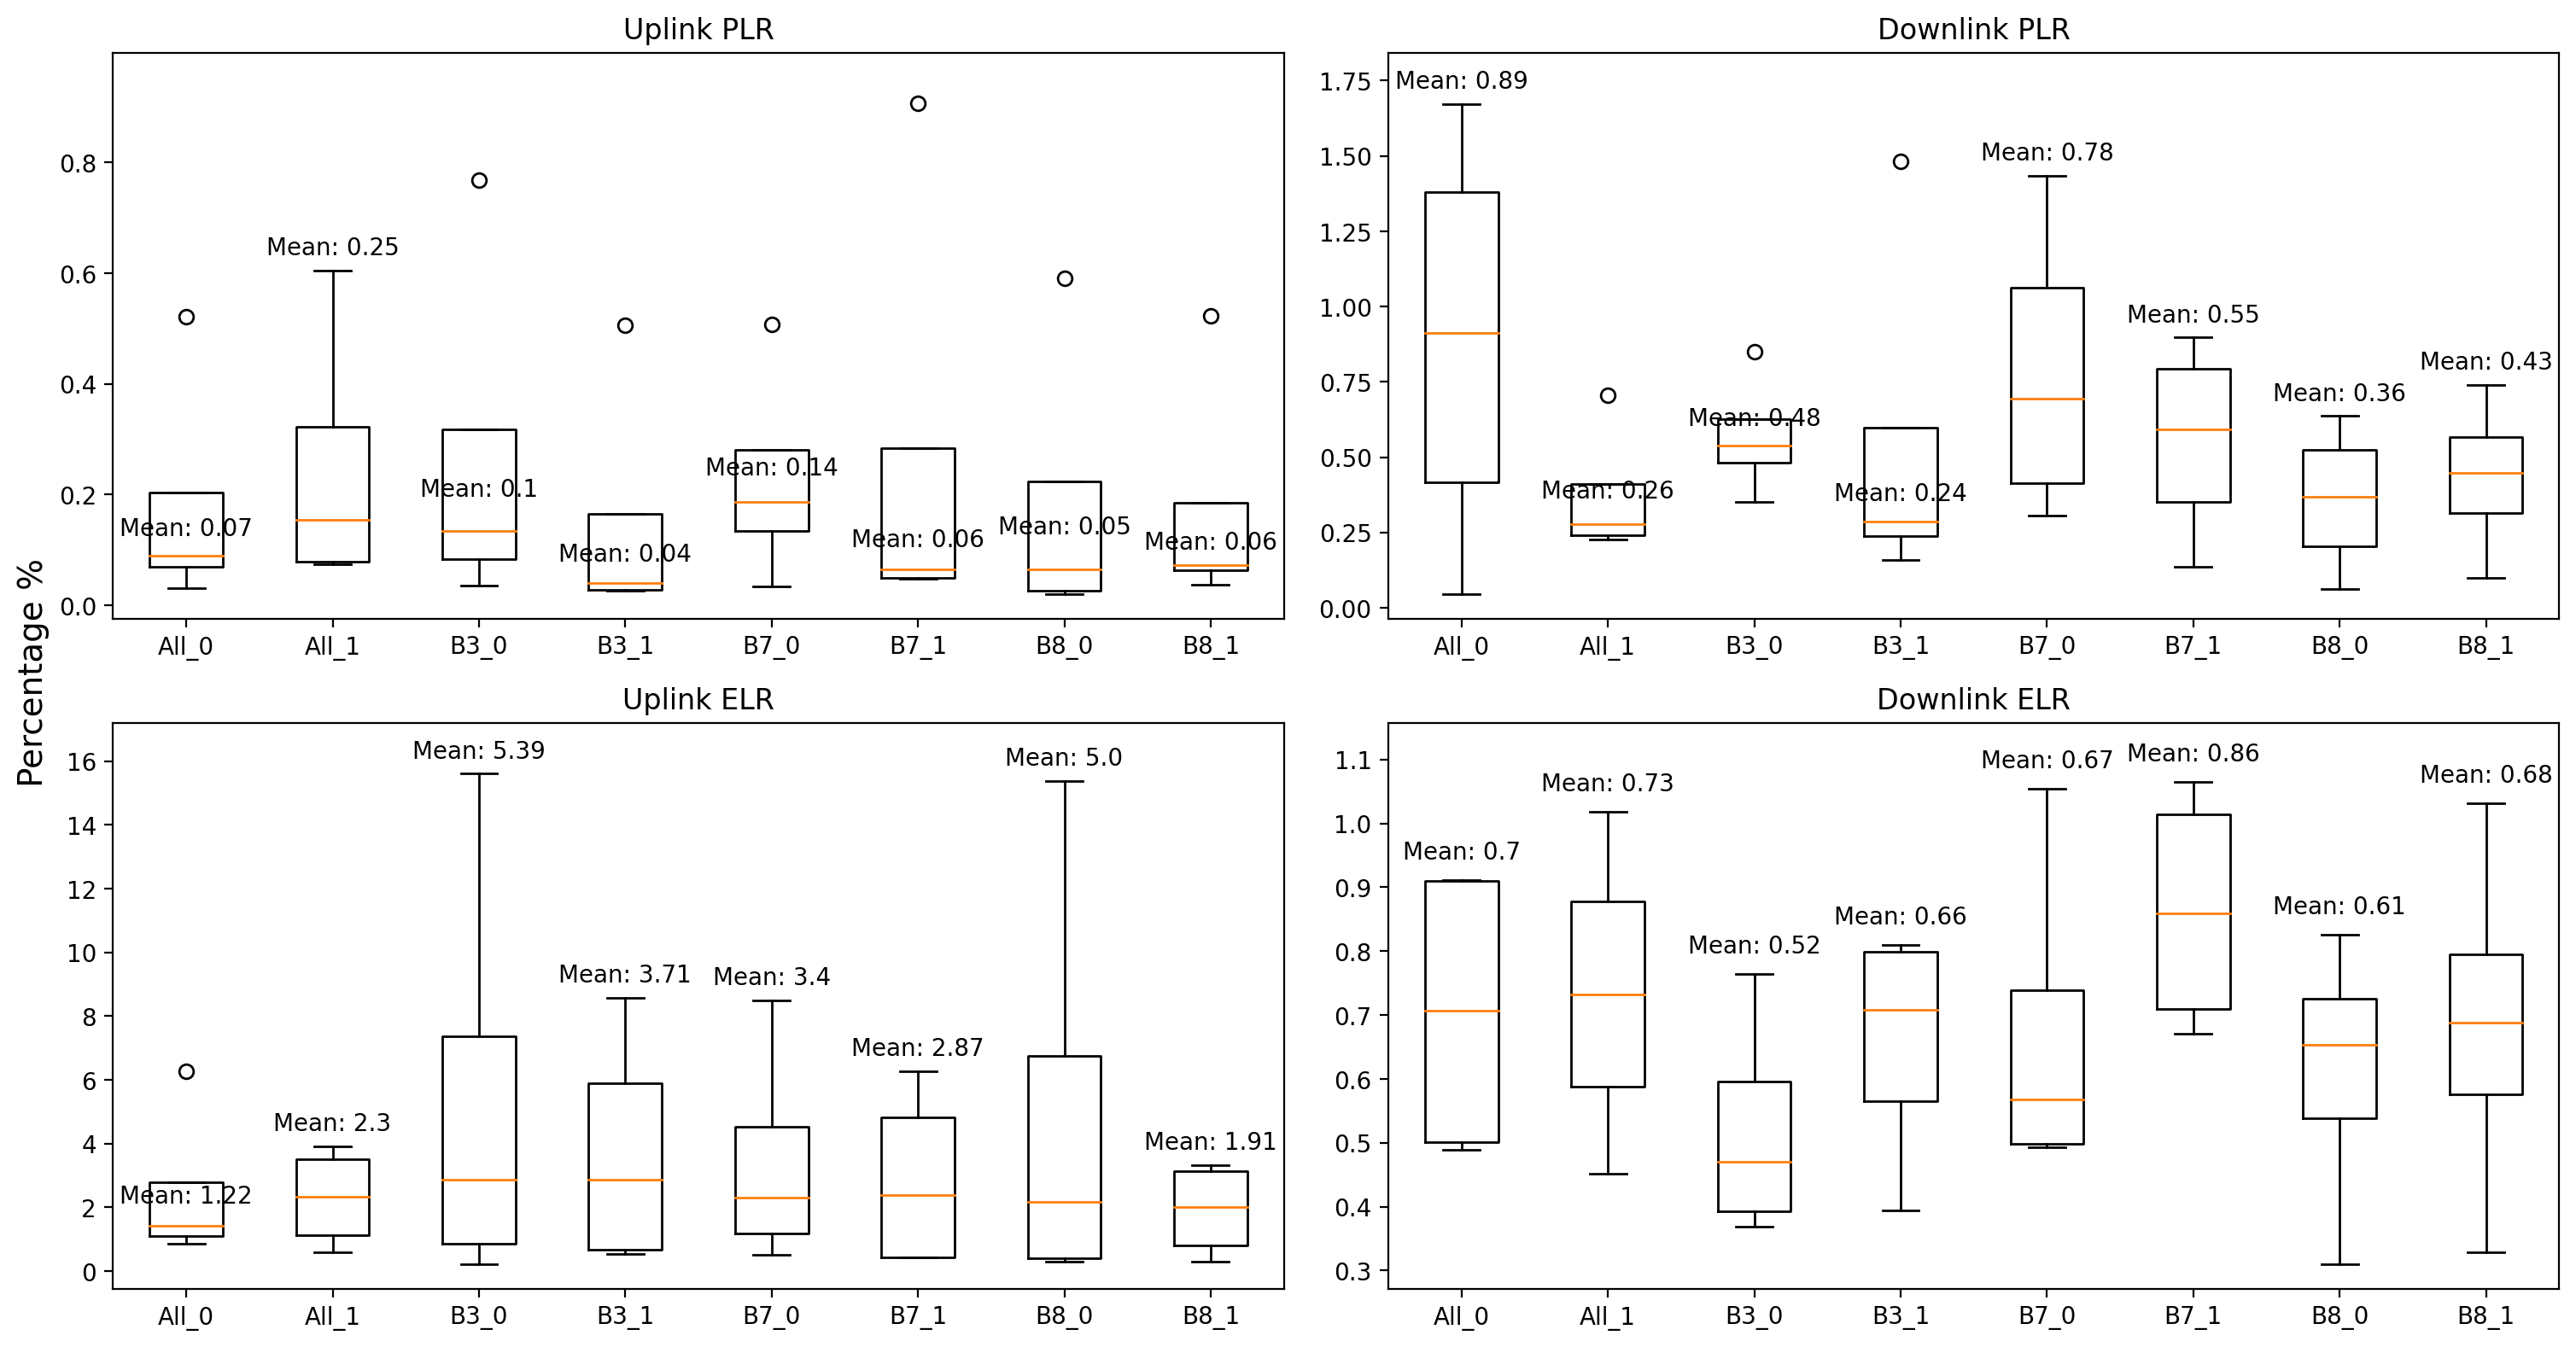

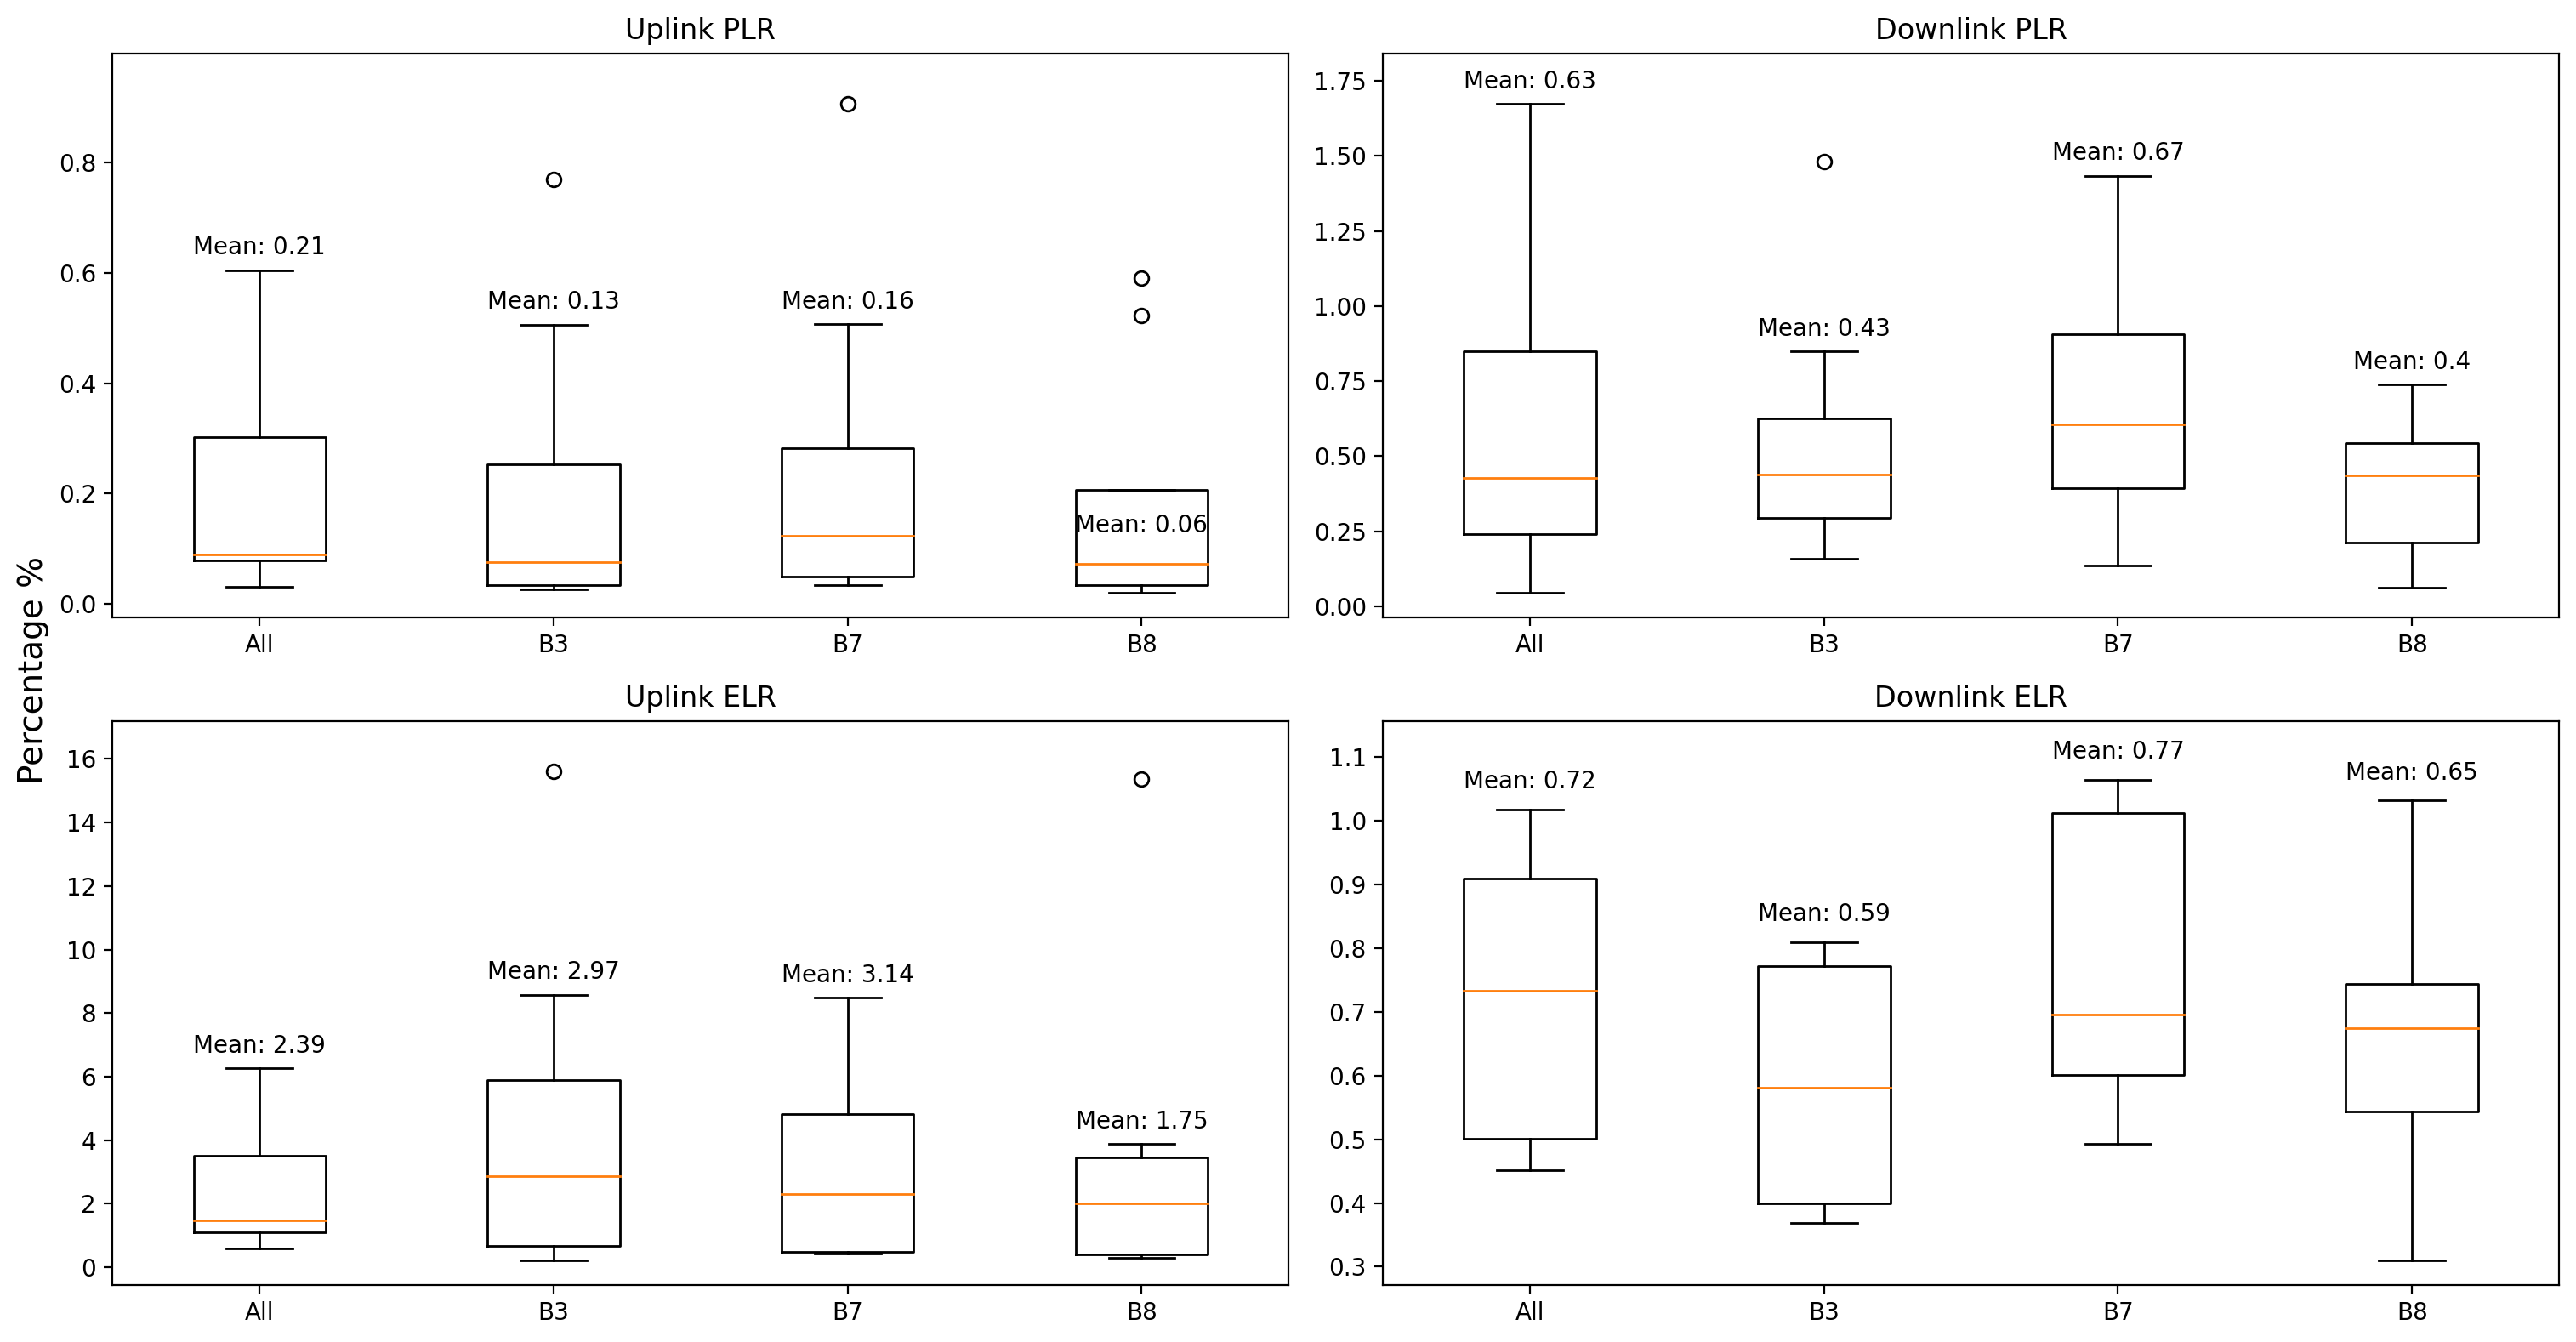

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             6   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             4   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             5   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7  #01, #02, #03, #04, #05, #06     1.072479             7   
6   sm06   B8  #01, #02, #03, #04, #05, #06     0.992900             2   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             3   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             5     0.831878   
5     2.280974             8     3.266161             6     0.730304   
6     1.036093             3     2.564579             4     0.495090   
7     1.476035             4     2.474258             3     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             4  
6             1  
7             3

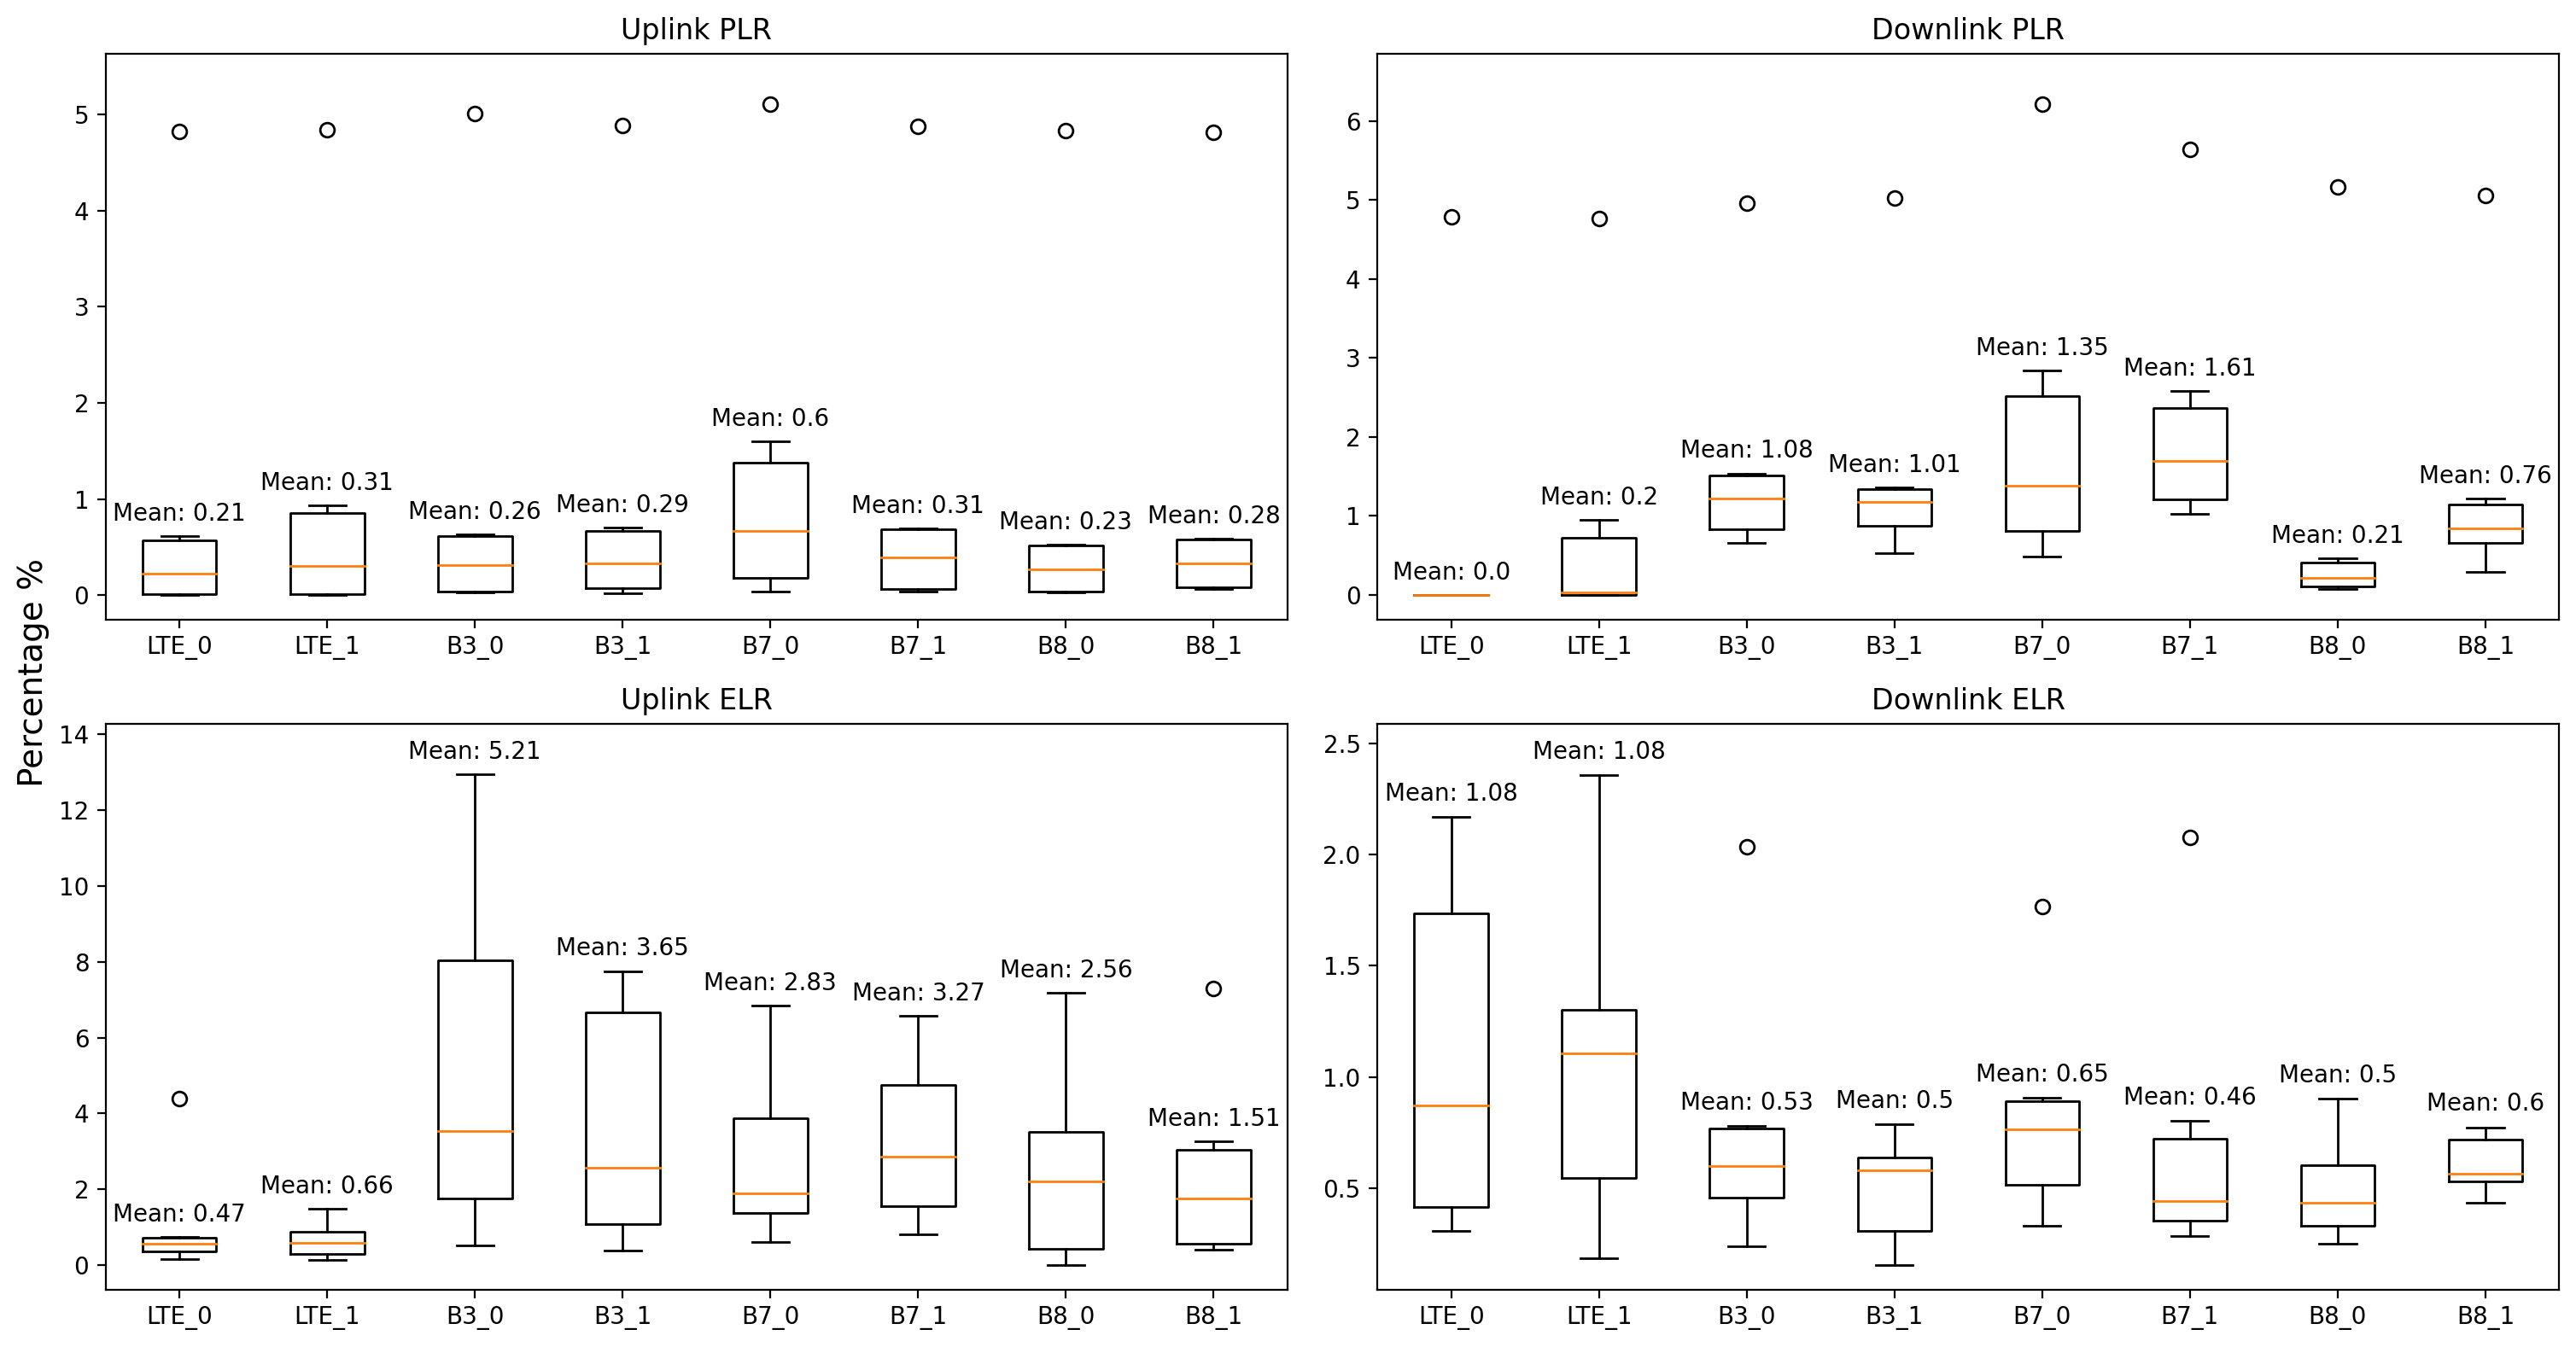

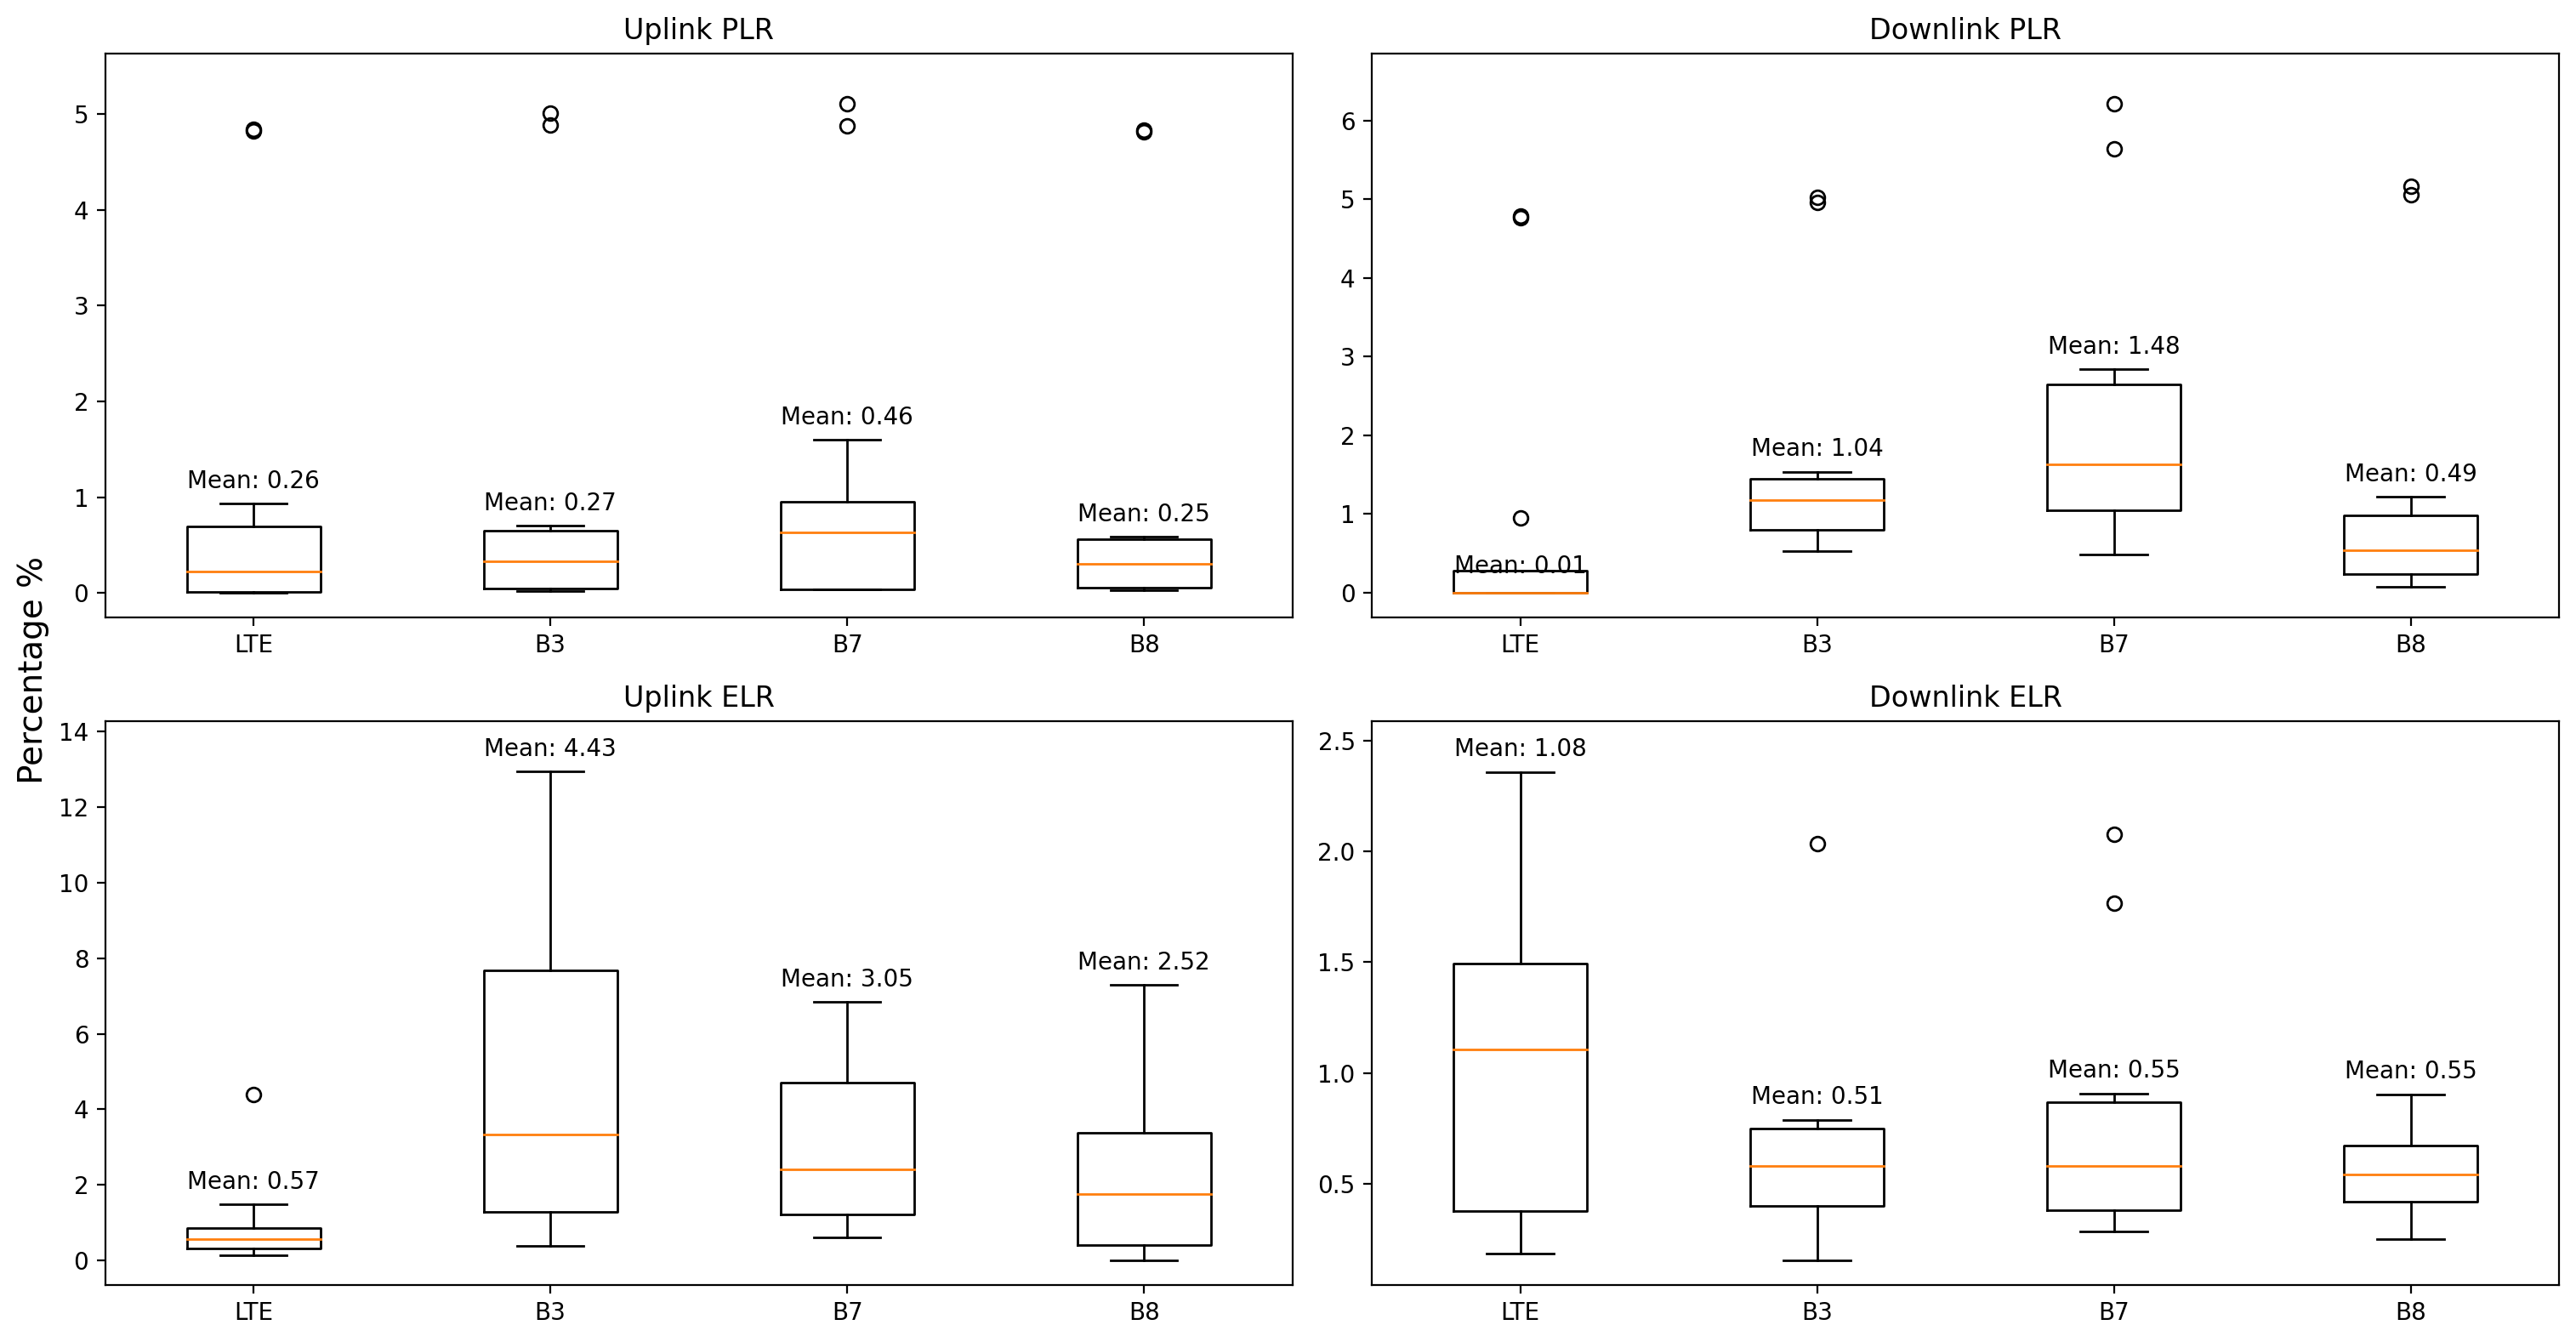

In [11]:
def remove_outliers(data_list):
    # 计算四分位数和四分位距离
    Q1 = np.percentile(data_list, 25)
    Q3 = np.percentile(data_list, 75)
    IQR = Q3 - Q1

    # 计算下限和上限
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 去掉异常值
    cleaned_list = [x for x in data_list if lower_bound <= x <= upper_bound]

    return cleaned_list

for expr, metrics_dict in zip(exp_list, single_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)

    ### 繪製 Box Plot (1) 對每個 “device” 的數據繪圖
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    for pos, tag in enumerate(['ul_loss', 'ul_excl', 'dl_loss', 'dl_excl']):
        
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        i = pos % 2; j = pos // 2
        
        # 依序填入 sm00-sm07 的數據，移除 rate == -1 的數值（未讀取該資料）
        boxes = [[num for num in v[tag] if num >= 0] for v in metrics_dict.values()]
        # axes[i][j].boxplot(boxes, labels=metrics_dict.keys())
        axes[i][j].boxplot(boxes, labels=add_suffix_to_duplicate_category([expr.setting[k] for k in metrics_dict.keys()]))
        axes[i][j].set_title(title)
        
        offset = axes[i][j].get_ylim()[1]*0.03
        for k, box_data in enumerate(boxes):
            box_data = remove_outliers(box_data)
            mean_value = round(np.mean(box_data), 2)
            axes[i][j].text(k + 1, max(box_data) + offset, f'Mean: {mean_value}', ha='center', fontsize=10)
        
        axes[i][j].set_ylim(top=axes[i][j].get_ylim()[1]*1.05)

    fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout()
    plt.show()
    
    ### 繪製 Box Plot (2) 將相同 “設定” 不同 “device” 的數據合併繪圖
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    for pos, tag in enumerate(['ul_loss', 'ul_excl', 'dl_loss', 'dl_excl']):
        
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        i = pos % 2; j = pos // 2
        
        new_dict = {}
        for dev, val in metrics_dict.items():
            schm = expr.setting[dev]
            if schm not in new_dict.keys():
                # 依序填入 sm00-sm07 的數據，移除 rate == -1 的數值（未讀取該資料）
                new_dict[schm] = [num for num in val[tag] if num >= 0]
            else:
                new_dict[schm] += [num for num in val[tag] if num >= 0]
        boxes = [v for v in new_dict.values()]
        axes[i][j].boxplot(boxes, labels=new_dict.keys())
        axes[i][j].set_title(title)
        
        offset = axes[i][j].get_ylim()[1]*0.03
        for k, box_data in enumerate(boxes):
            box_data = remove_outliers(box_data)
            mean_value = round(np.mean(box_data), 2)
            axes[i][j].text(k + 1, max(box_data) + offset, f'Mean: {mean_value}', ha='center', fontsize=10)
        
        axes[i][j].set_ylim(top=axes[i][j].get_ylim()[1]*1.05)

    fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)

    plt.tight_layout()
    plt.show()

## Bar Chart: Per Round

In [12]:
data = {'#01': {'sm00': 8.0, 'sm01': 7.0, 'sm02': 5.0, 'sm03': 1.0, 'sm04': 3.0, 'sm05': 6.0, 'sm06': 2.0, 'sm07': 4.0}, 
 '#02': {'sm00': 5.0, 'sm01': 6.0, 'sm02': 1.0, 'sm03': 3.0, 'sm04': 4.0, 'sm05':  np.nan, 'sm06':  np.nan, 'sm07': 2.0}, 
 '#03': {'sm00': 2.0, 'sm01': 6.0, 'sm02': 8.0, 'sm03': 1.0, 'sm04': 7.0, 'sm05': 3.0, 'sm06': 5.0, 'sm07': 4.0}, 
 '#04': {'sm00': 2.0, 'sm01': 8.0, 'sm02': 7.0, 'sm03': 6.0, 'sm04': 4.0, 'sm05': 3.0, 'sm06': 1.0, 'sm07': 5.0}, 
 '#05': {'sm00': 8.0, 'sm01': 1.0, 'sm02': 4.0, 'sm03': 5.0, 'sm04': 7.0, 'sm05': 6.0, 'sm06': 2.0, 'sm07': 3.0}, 
 '#06': {'sm00': 4.0, 'sm01': 2.0, 'sm02': 3.0, 'sm03': 5.0, 'sm04': 7.0, 'sm05': 1.0, 'sm06': 6.0, 'sm07': 8.0}, 
 'Score': {'sm00': -3, 'sm01': -2, 'sm02': -1, 'sm03': 4, 'sm04': -3, 'sm05': 2, 'sm06': 4, 'sm07': -1}, 
 'Ranking': {'sm00': 7, 'sm01': 6, 'sm02': 4, 'sm03': 1, 'sm04': 8, 'sm05': 3, 'sm06': 2, 'sm07': 5}}

devices = ['sm00', 'sm01', 'sm02', 'sm03', 'sm04', 'sm05', 'sm06', 'sm07']
schemes = ['LTE_0', 'LTE_1', 'B3_0', 'B3_1', 'B7_0', 'B7_1', 'B8_0', 'B8_1']

updated_data = {k: {(dev, schm): v[dev] for dev, schm in zip(devices, schemes)}
                for k, v in data.items()}

# 转换成 DataFrame 并设置两层标头
df = pd.DataFrame(updated_data).T
# df.columns = pd.MultiIndex.from_tuples(df.columns)

display(df)

sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       8.0   7.0  5.0  1.0  3.0  6.0  2.0  4.0
#02       5.0   6.0  1.0  3.0  4.0  NaN  NaN  2.0
#03       2.0   6.0  8.0  1.0  7.0  3.0  5.0  4.0
#04       2.0   8.0  7.0  6.0  4.0  3.0  1.0  5.0
#05       8.0   1.0  4.0  5.0  7.0  6.0  2.0  3.0
#06       4.0   2.0  3.0  5.0  7.0  1.0  6.0  8.0
Score    -3.0  -2.0 -1.0  4.0 -3.0  2.0  4.0 -1.0
Ranking   7.0   6.0  4.0  1.0  8.0  3.0  2.0  5.0

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Uplink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       3.0   7.0  8.0  2.0  4.0  5.0  1.0  6.0
#02       5.0   8.0  6.0  1.0  7.0  3.0  2.0  4.0
#03       3.0   6.0  7.0  1.0  2.0  8.0  5.0  4.0
#04       6.0   5.0  1.0  3.0  8.0  4.0  7.0  2.0
Score     0.0  -3.0 -1.0  5.0 -2.0 -2.0  2.0  1.0
Ranking   4.0   8.0  5.0  1.0  6.0  7.0  2.0  3.0

Downlink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       8.0   3.0  5.0  2.0  4.0  1.0  6.0  7.0
#02       8.0   3.0  4.0  7.0  6.0  5.0  1.0  2.0
#03       1.0   5.0  6.0  3.0  4.0  8.0  2.0  7.0
#04       7.0   2.0  6.0  4.0  8.0  5.0  3.0  1.0
Score    -3.0   1.0  0.0  0.0 -2.0  0.0  3.0  1.0
Ranking   8.0   2.0  4.0  5.0  7.0  6.0  1.0  3.0

Uplink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       6.0   7.0  5.0  3.0  8.0  2.0  1.0  4.0
#02       3.0   2.0  8.0  6.0  5.0  4.0  7.0  1.0
#03       8.0   6.0  1.0  7.0  5.0  3.0  4.0  2.0
#04       1.0   5.0  7.0  8.0  3.0  6.0  4.0  2.0
Score     0.0   0.0 -1.0 -3.0 -2.0  1.0  1.0  4.0
Ranking   4.0   5.0  6.0  8.0  7.0  2.0  3.0  1.0

Downlink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       5.0   6.0  3.0  4.0  8.0  2.0  1.0  7.0
#02       3.0   8.0  1.0  2.0  5.0  7.0  4.0  6.0
#03       7.0   4.0  3.0  5.0  2.0  8.0  6.0  1.0
#04       4.0   2.0  1.0  5.0  3.0  8.0  7.0  6.0
Score    -1.0  -1.0  4.0  1.0 -1.0 -4.0  1.0  1.0
Ranking   5.0   6.0  1.0  2.0  7.0  8.0  3.0  4.0

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #01


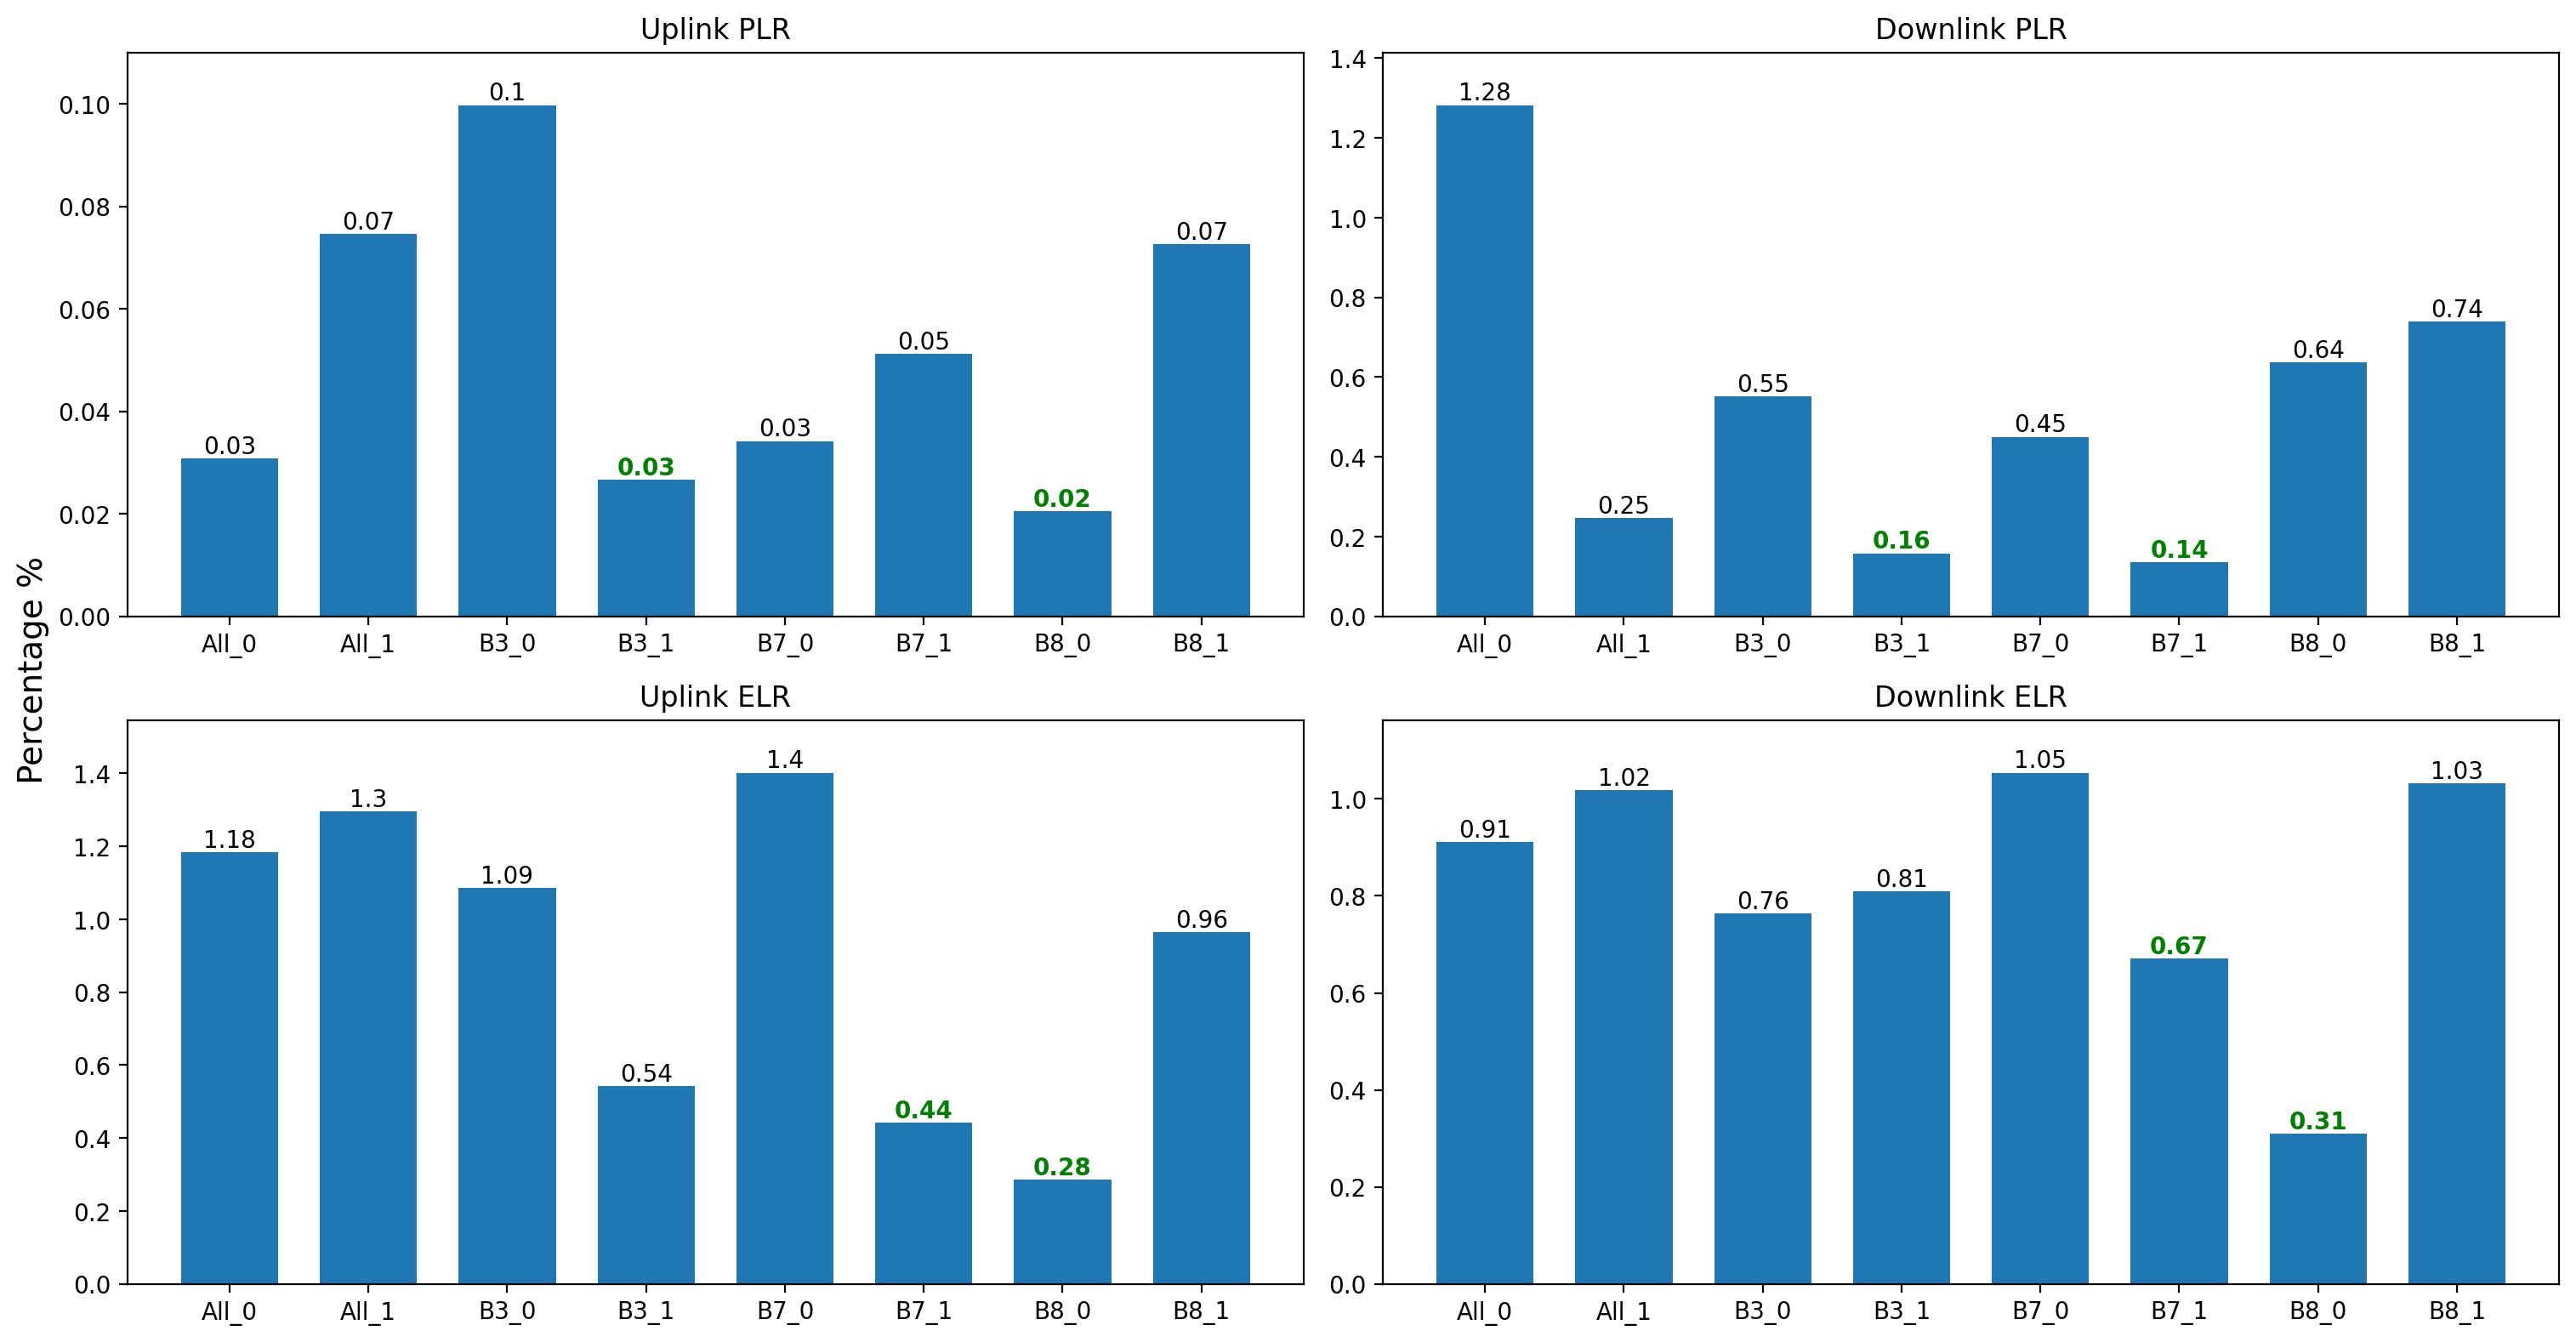

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #02


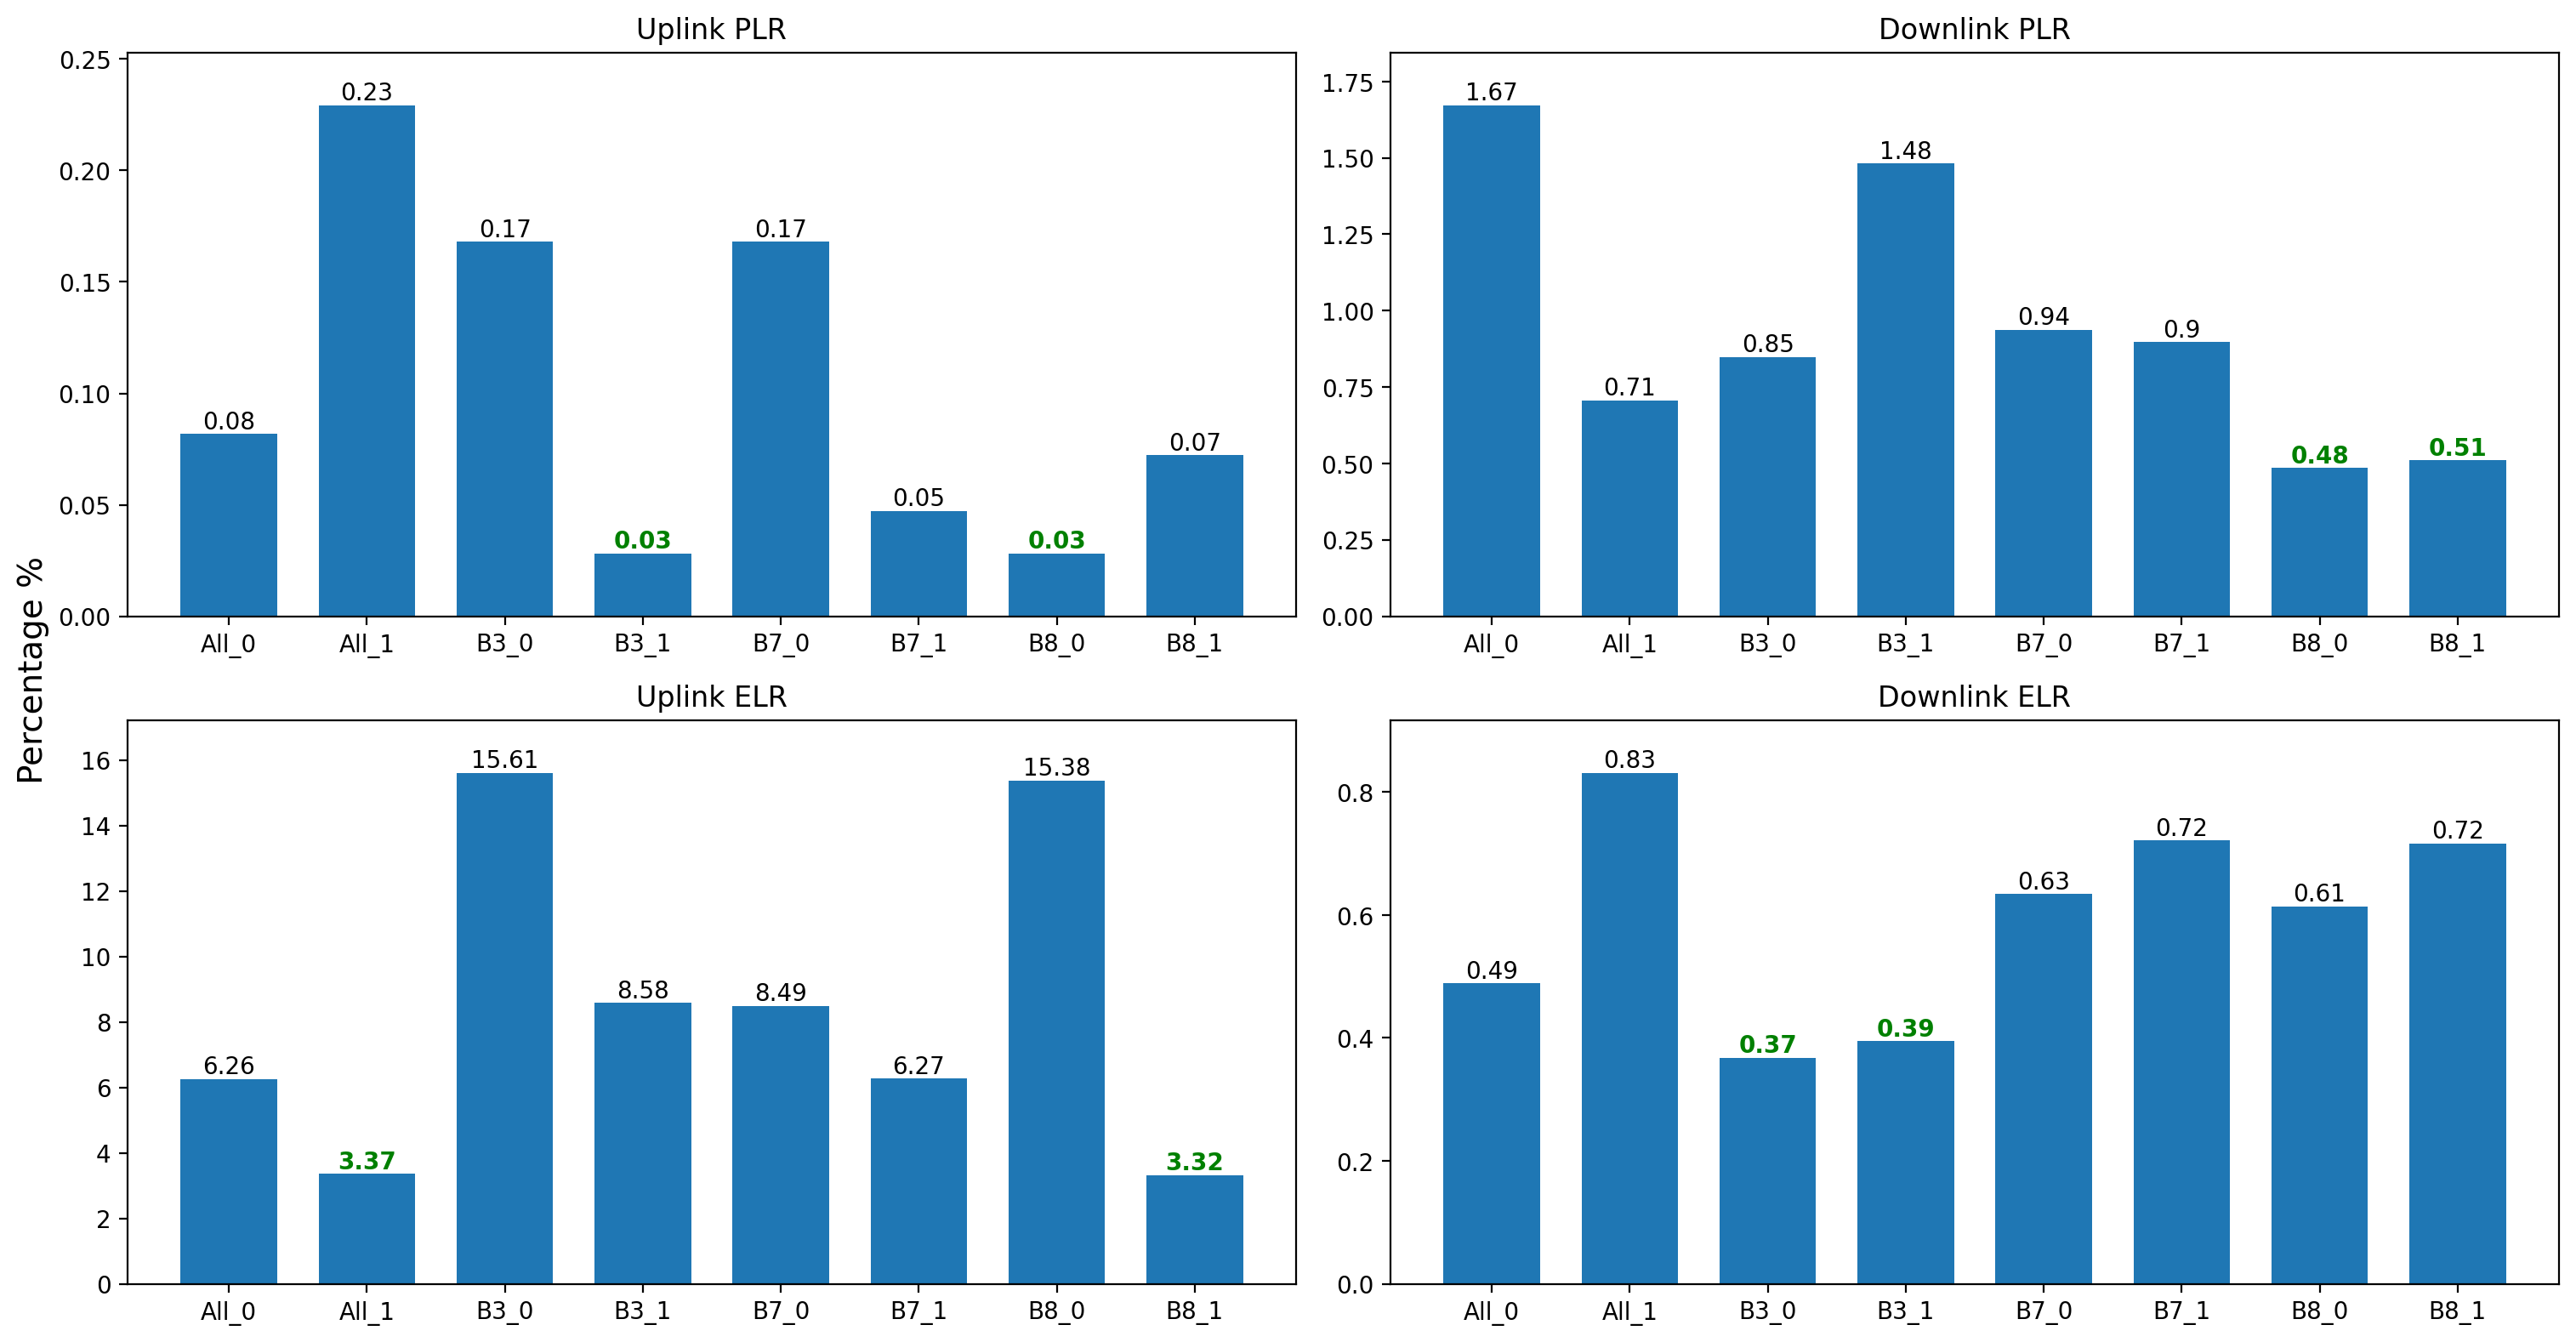

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #03


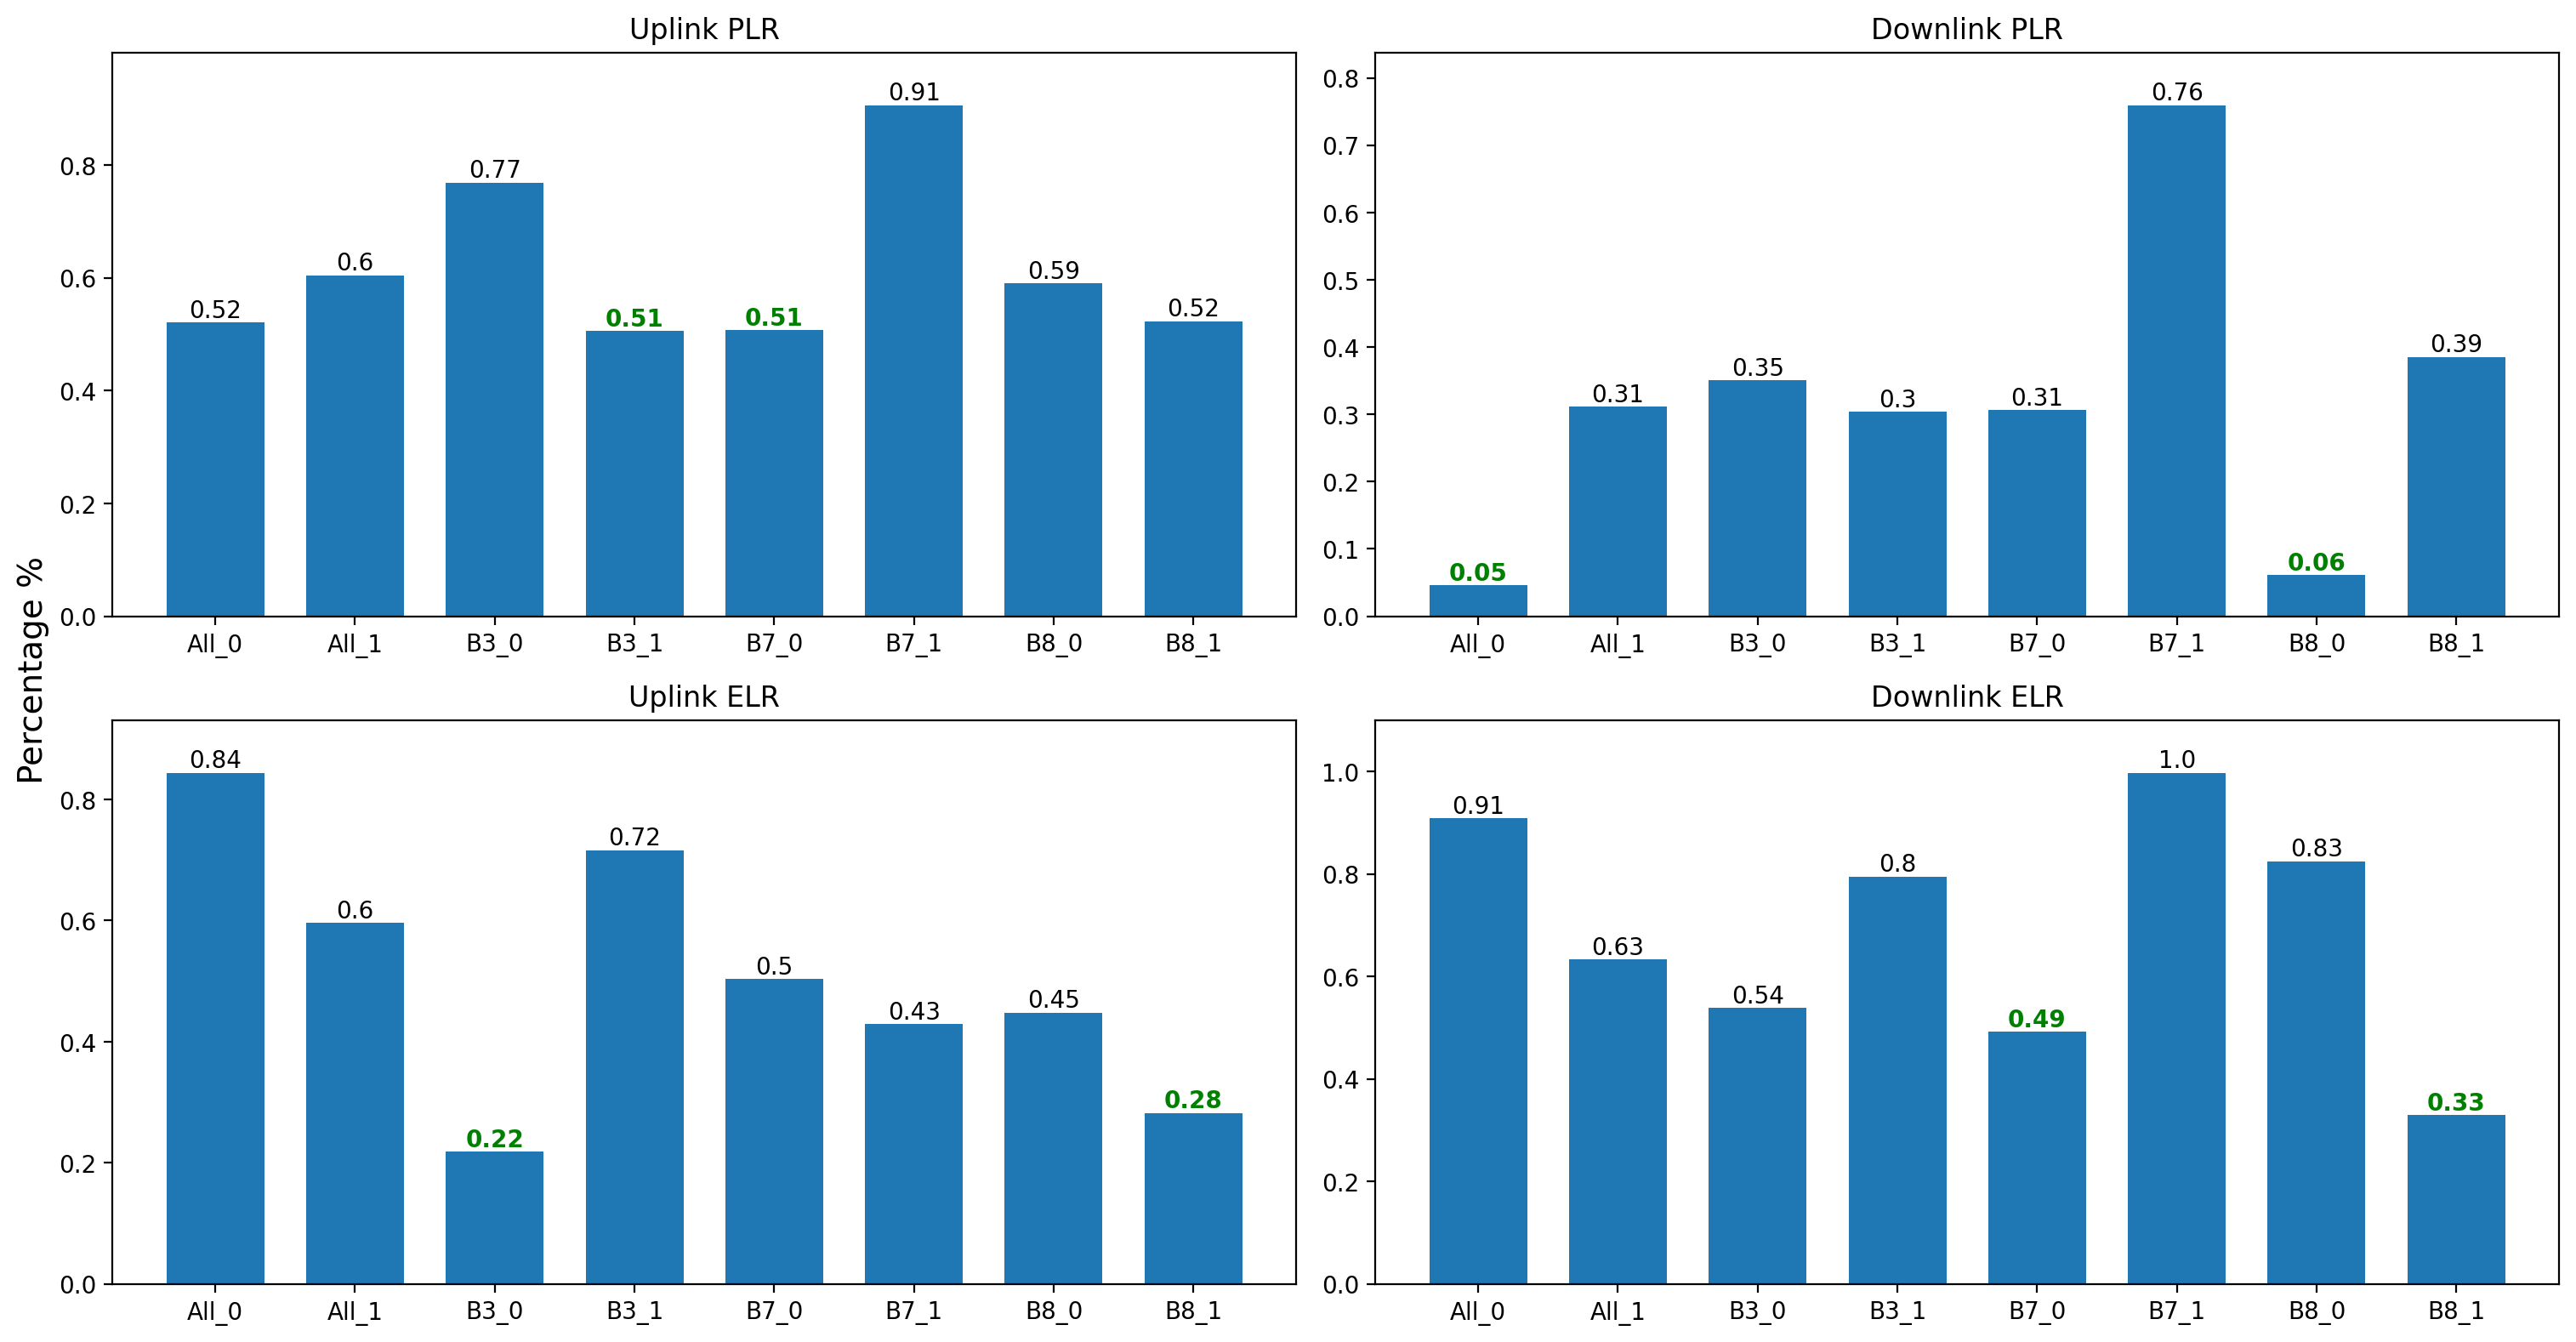

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #04


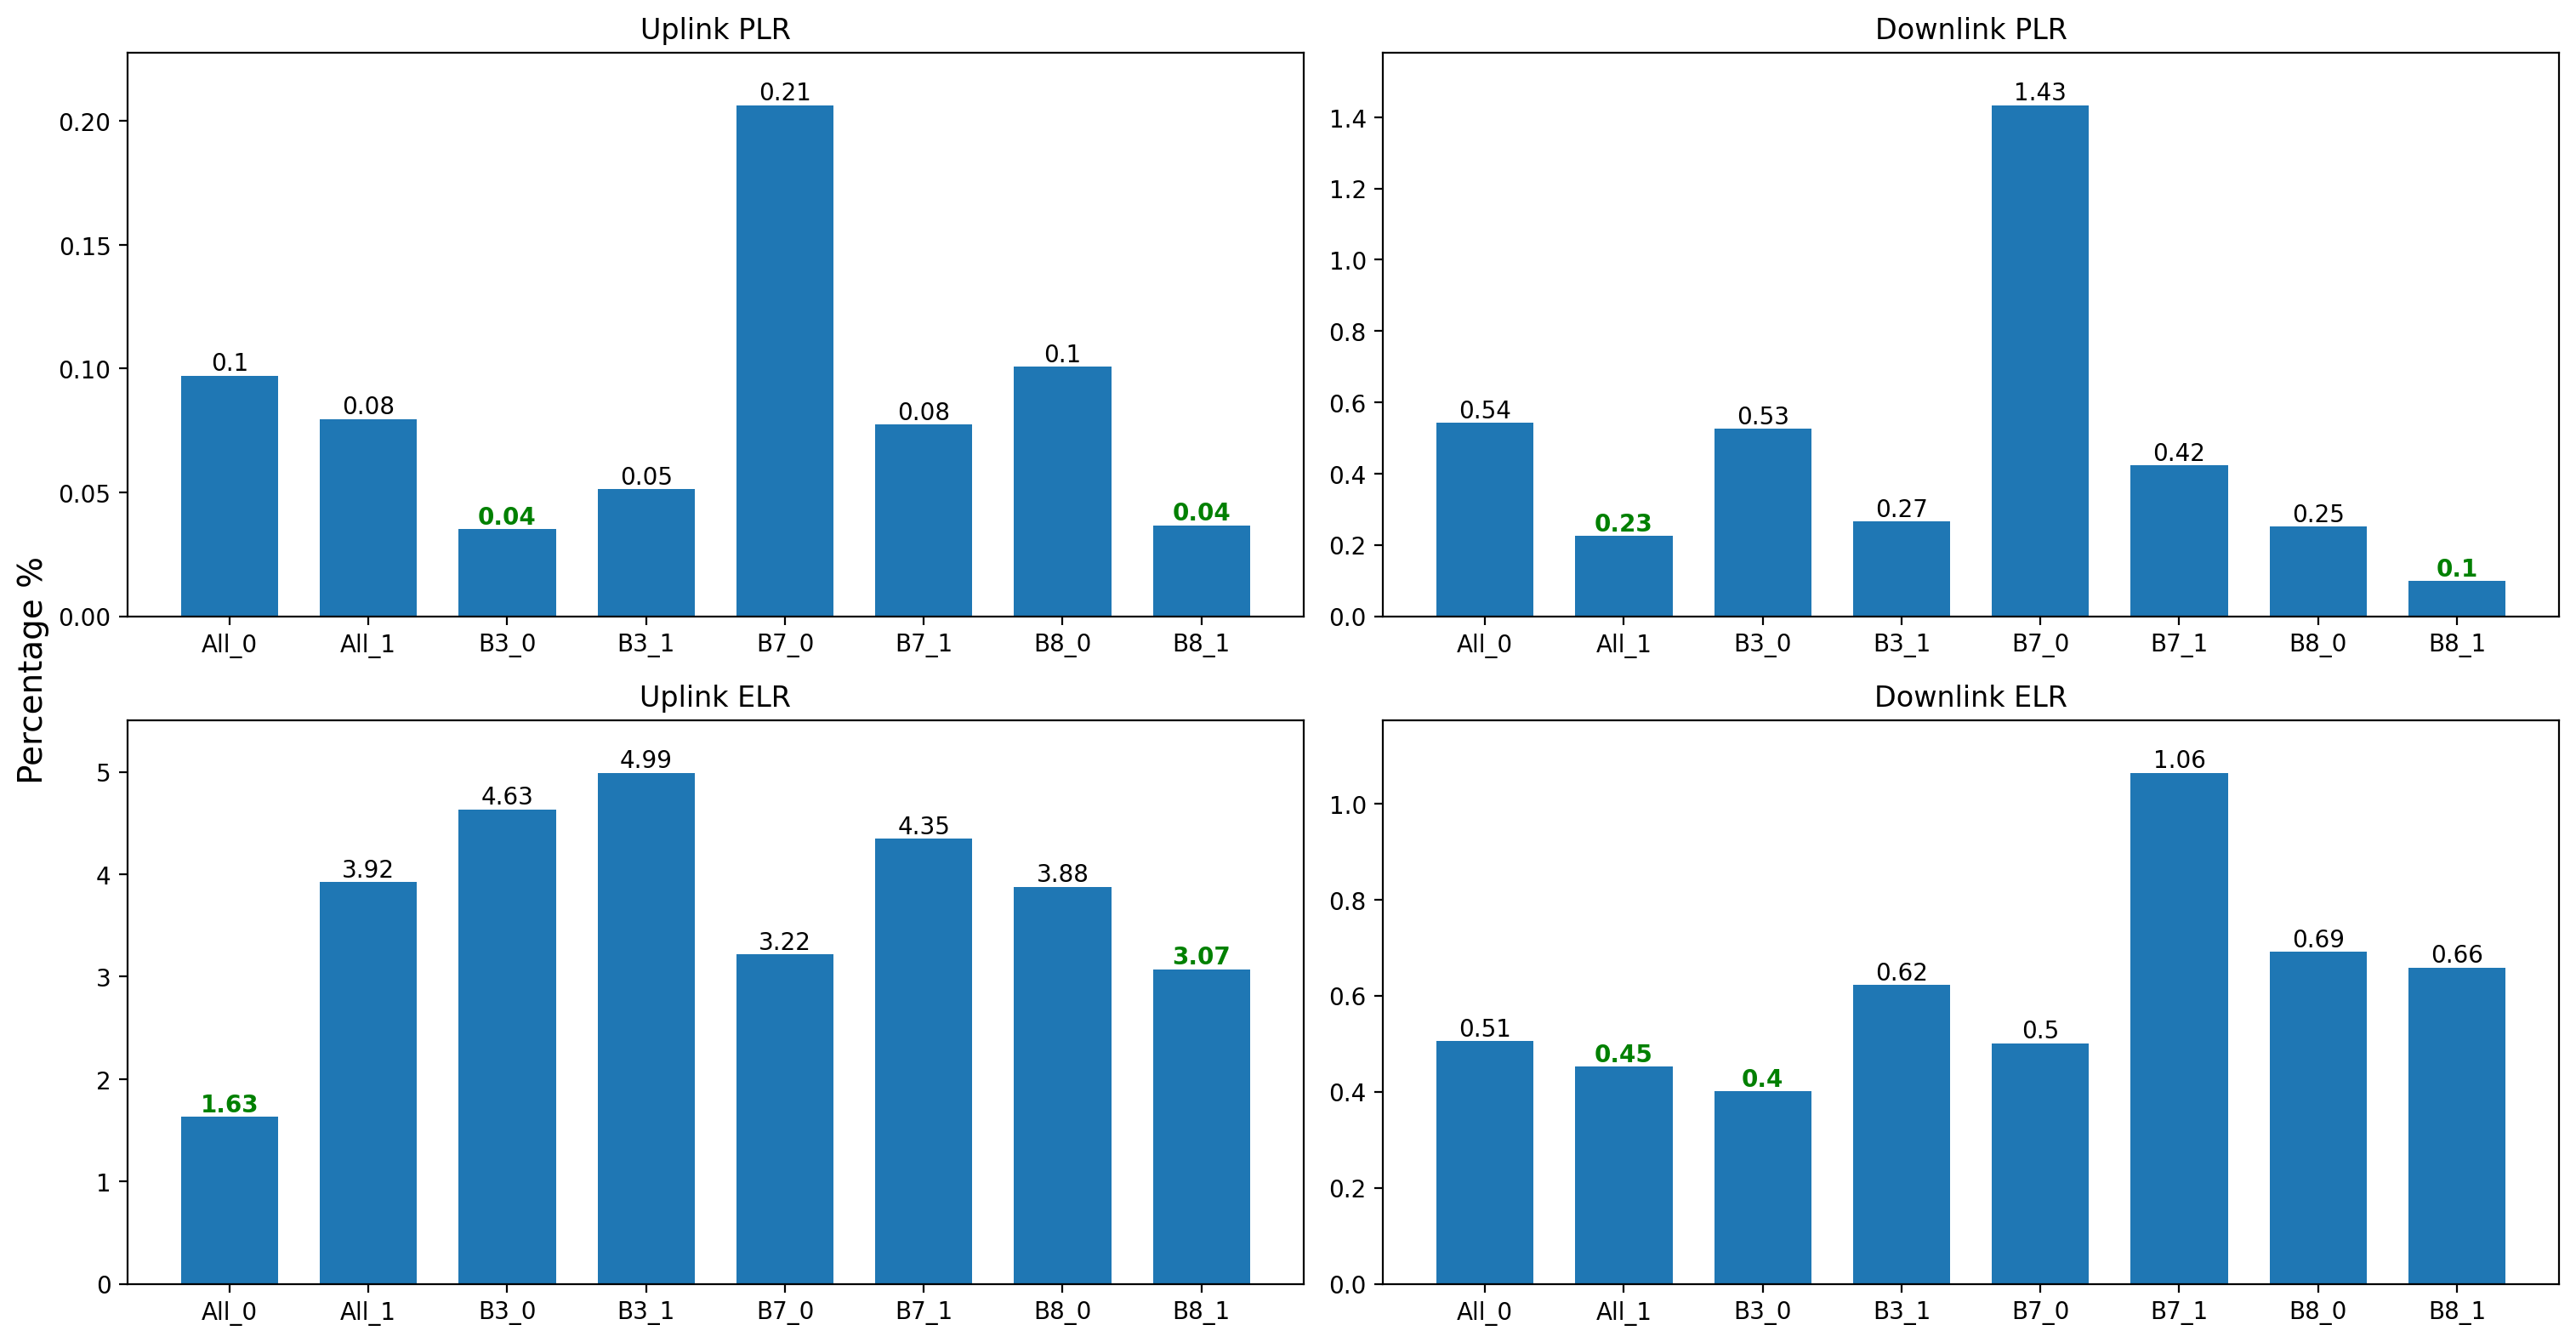

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             6   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             4   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             5   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7  #01, #02, #03, #04, #05, #06     1.072479             7   
6   sm06   B8  #01, #02, #03, #04, #05, #06     0.992900             2   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             3   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             5     0.831878   
5     2.280974             8     3.266161             6     0.730304   
6     1.036093             3     2.564579             4     0.495090   
7     1.476035             4     2.474258             3     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             4  
6             1  
7             3

Uplink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       5.0   3.0  6.0  8.0  4.0  7.0  1.0  2.0
#02       2.0   1.0  3.0  6.0  8.0  5.0  4.0  7.0
#03       1.0   2.0  7.0  3.0  5.0  4.0  6.0  8.0
#04       1.0   7.0  4.0  3.0  8.0  6.0  2.0  5.0
#05       2.0   4.0  7.0  6.0  8.0  5.0  3.0  1.0
#06       2.0   1.0  3.0  7.0  4.0  8.0  5.0  6.0
Score     7.0   4.0 -2.0 -3.0 -6.0 -3.0  3.0  0.0
Ranking   1.0   2.0  5.0  6.0  8.0  7.0  3.0  4.0

Downlink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       1.0   2.0  4.0  7.0  6.0  8.0  3.0  5.0
#02       1.0   2.0  7.0  4.0  8.0  5.0  3.0  6.0
#03       1.0   2.0  7.0  5.0  6.0  8.0  4.0  3.0
#04       1.0   5.0  4.0  6.0  7.0  8.0  2.0  3.0
#05       2.0   1.0  3.0  4.0  8.0  7.0  6.0  5.0
#06       1.0   2.0  7.0  6.0  4.0  8.0  3.0  5.0
Score    11.0   6.0 -3.0 -1.0 -5.0 -9.0  1.0  0.0
Ranking   1.0   2.0  6.0  5.0  7.0  8.0  3.0  4.0

Uplink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       5.0   6.0  3.0  7.0  4.0  8.0  1.0  2.0
#02       1.0   2.0  8.0  7.0  4.0  3.0  5.0  6.0
#03       1.0   2.0  7.0  5.0  8.0  6.0  4.0  3.0
#04       1.0   2.0  8.0  7.0  3.0  6.0  5.0  4.0
#05       5.0   1.0  8.0  3.0  7.0  6.0  2.0  4.0
#06       8.0   1.0  5.0  7.0  2.0  4.0  6.0  3.0
Score     4.0   7.0 -7.0 -4.0 -2.0 -2.0  3.0  1.0
Ranking   2.0   1.0  8.0  7.0  5.0  6.0  3.0  4.0

Downlink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       8.0   7.0  5.0  1.0  3.0  6.0  2.0  4.0
#02       7.0   8.0  1.0  4.0  5.0  6.0  2.0  3.0
#03       2.0   6.0  8.0  1.0  7.0  3.0  5.0  4.0
#04       2.0   8.0  7.0  6.0  4.0  3.0  1.0  5.0
#05       8.0   1.0  4.0  5.0  7.0  6.0  2.0  3.0
#06       4.0   2.0  3.0  5.0  7.0  1.0  6.0  8.0
Score    -3.0  -2.0 -1.0  4.0 -3.0  2.0  5.0 -2.0
Ranking   7.0   5.0  4.0  2.0  8.0  3.0  1.0  6.0

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #01


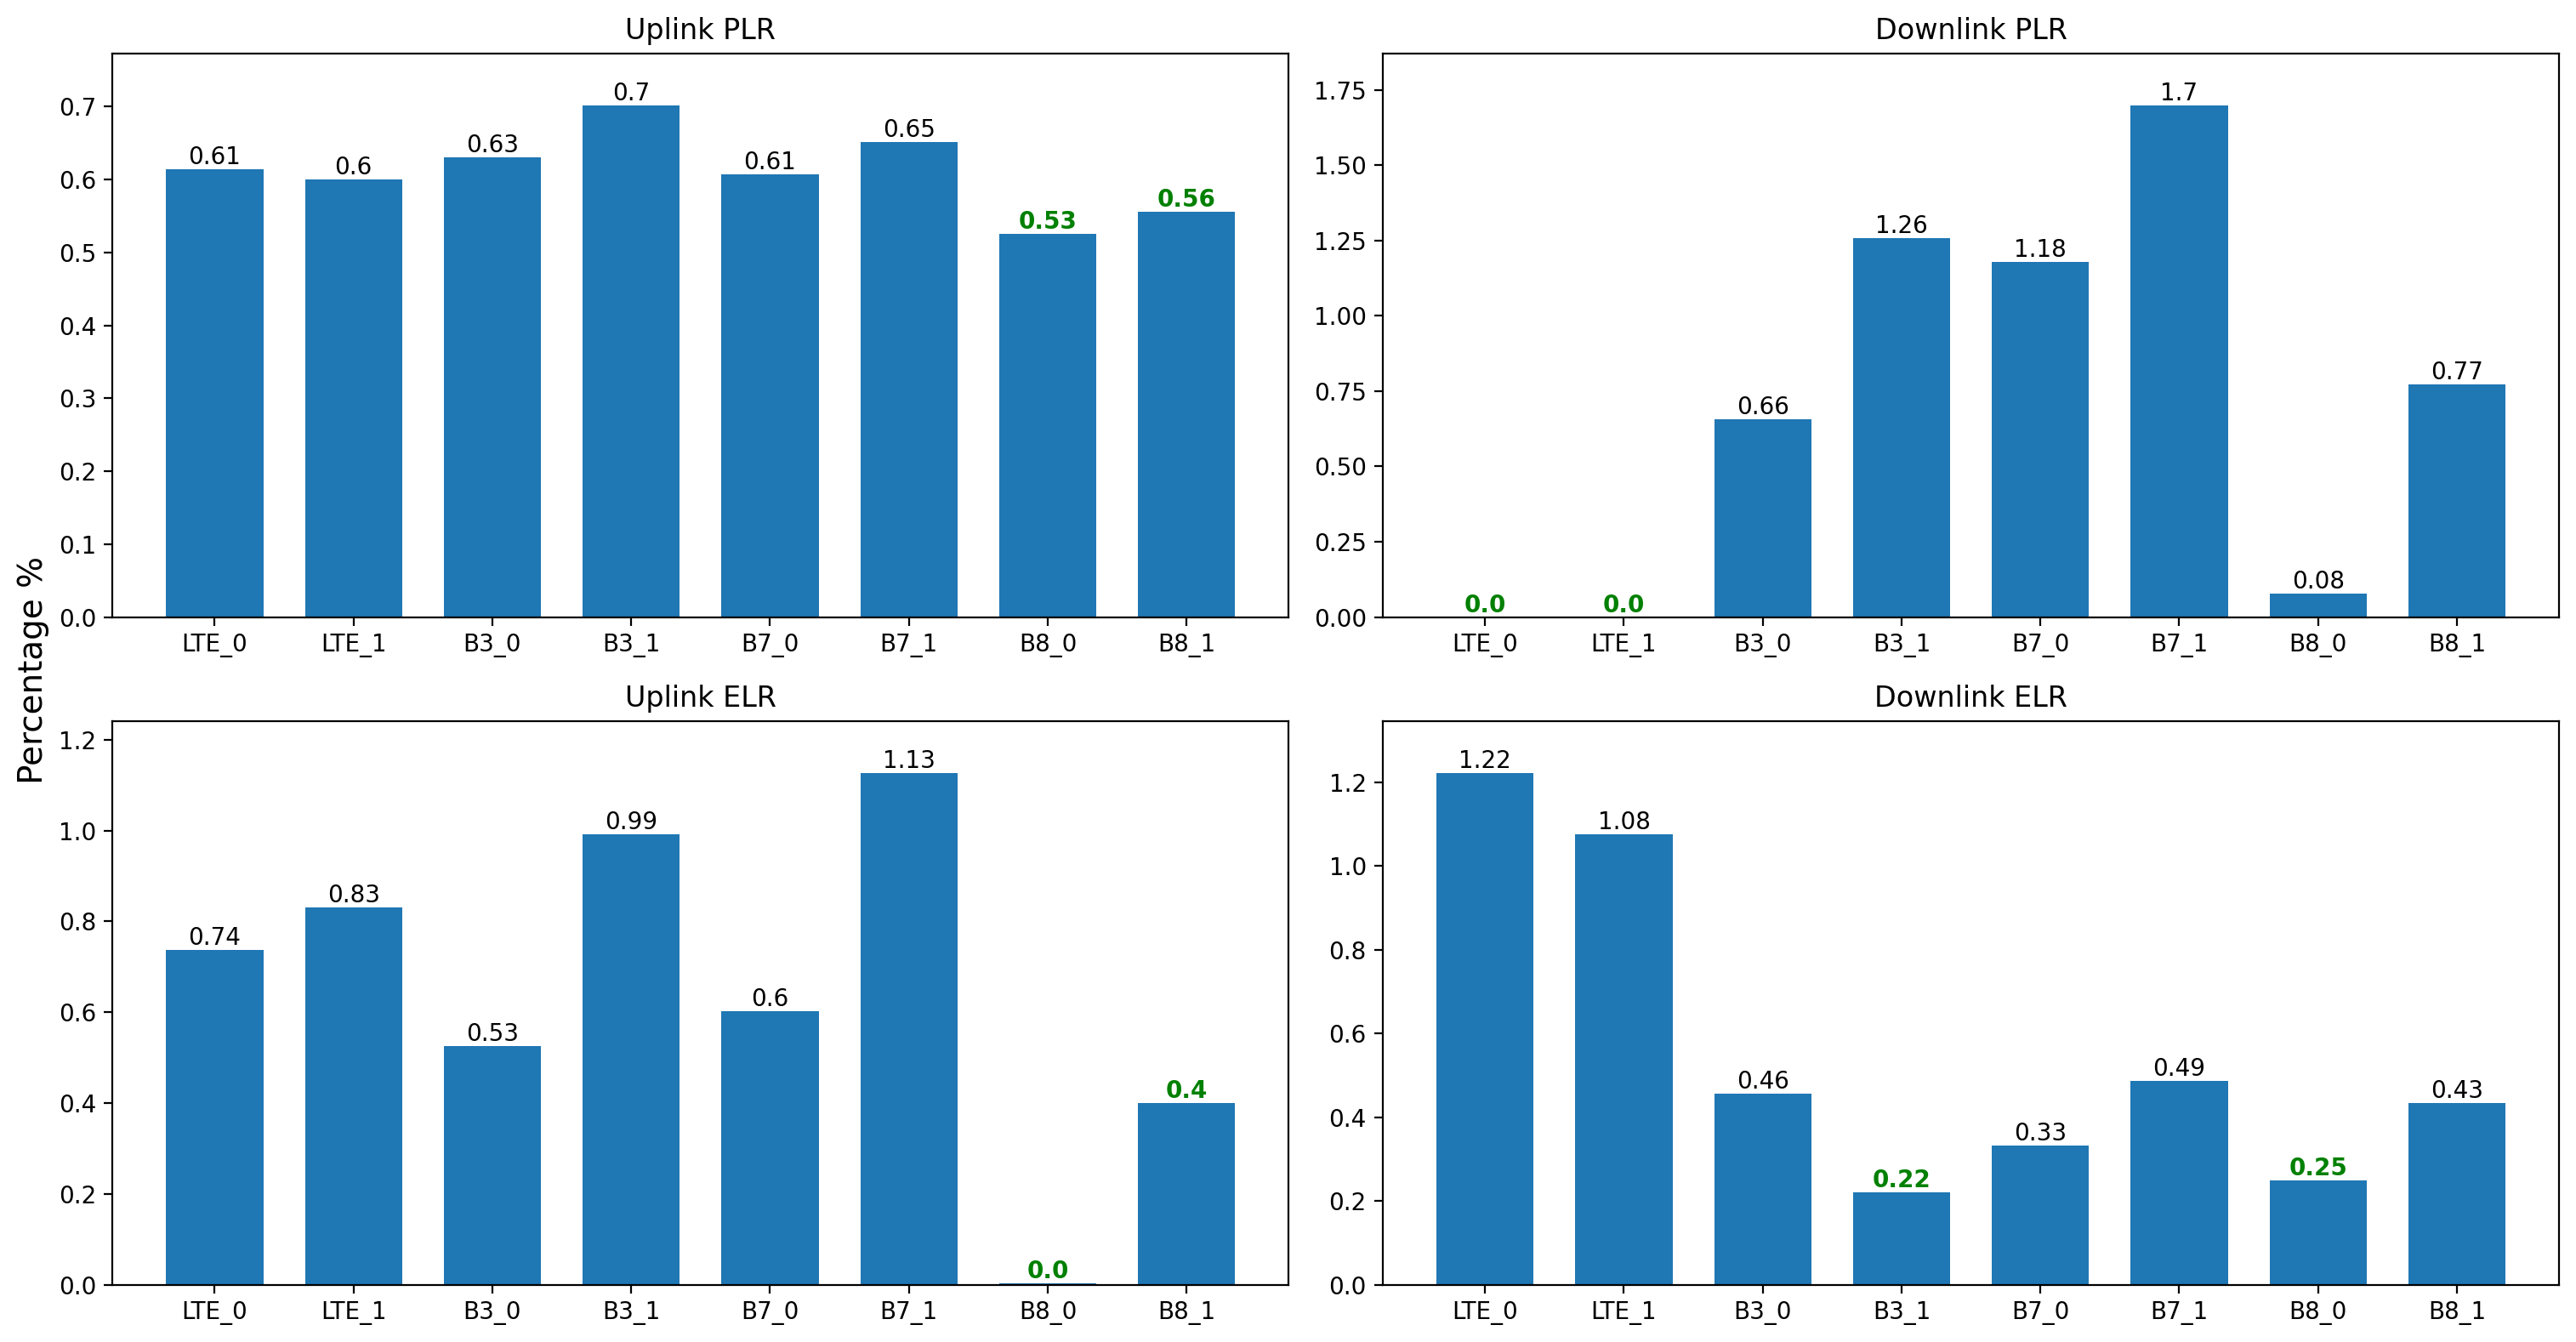

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #02


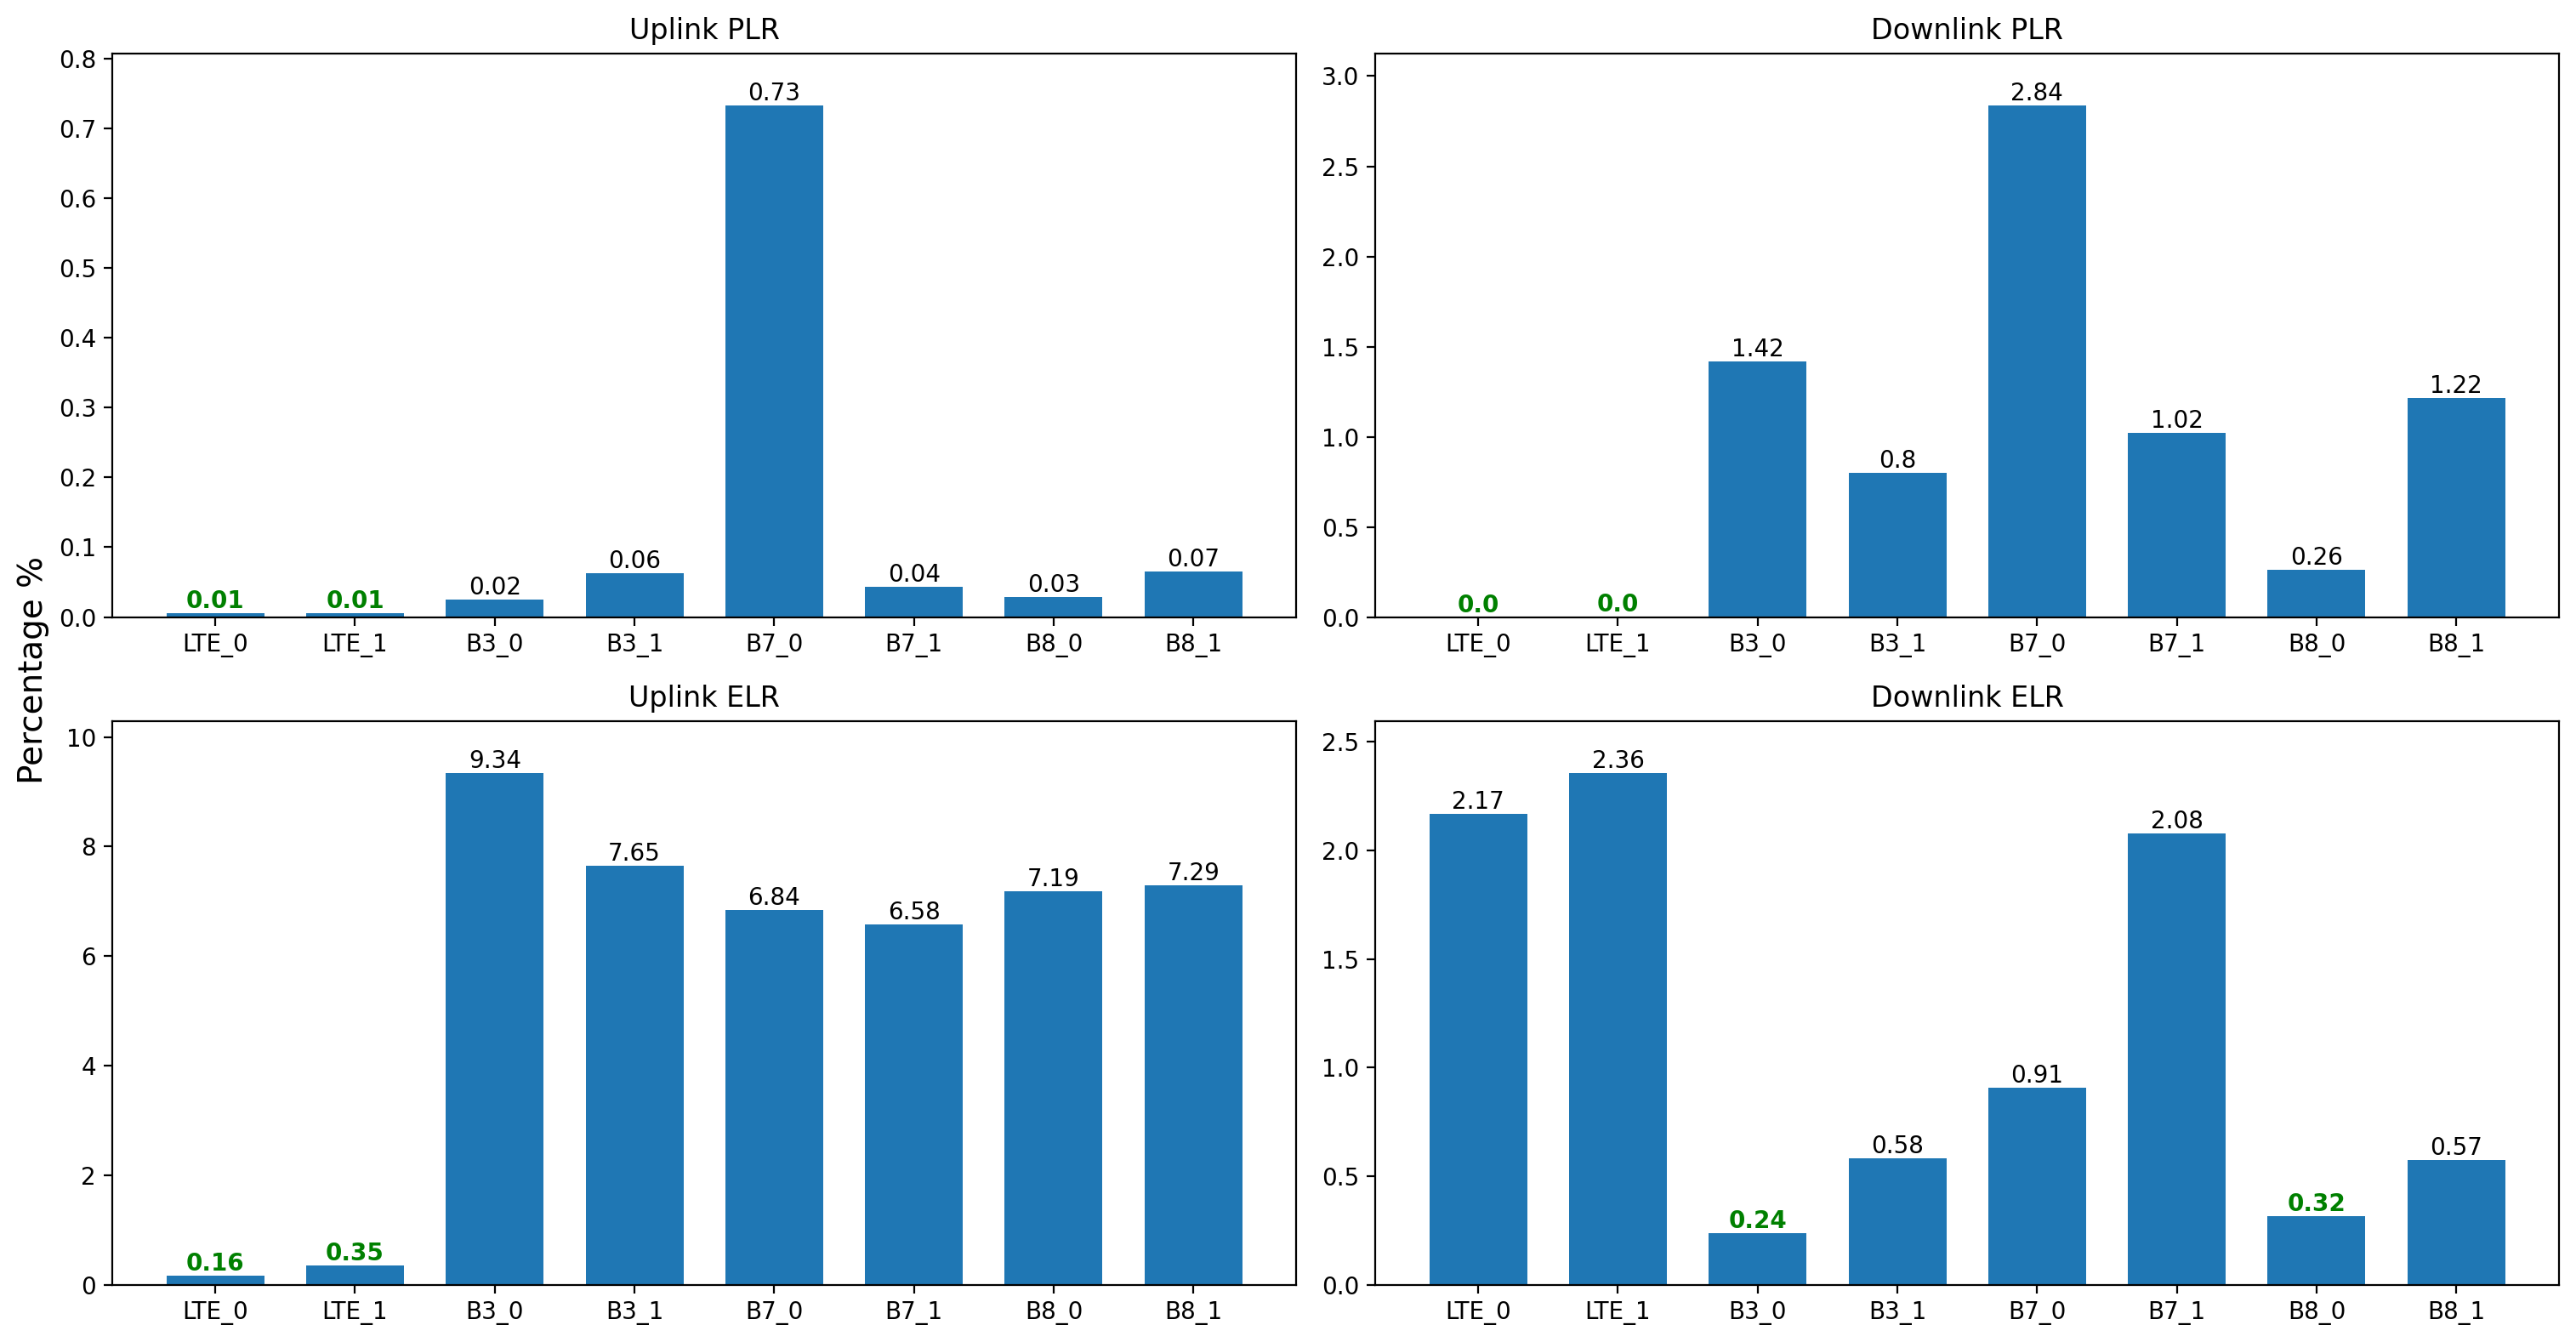

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #03


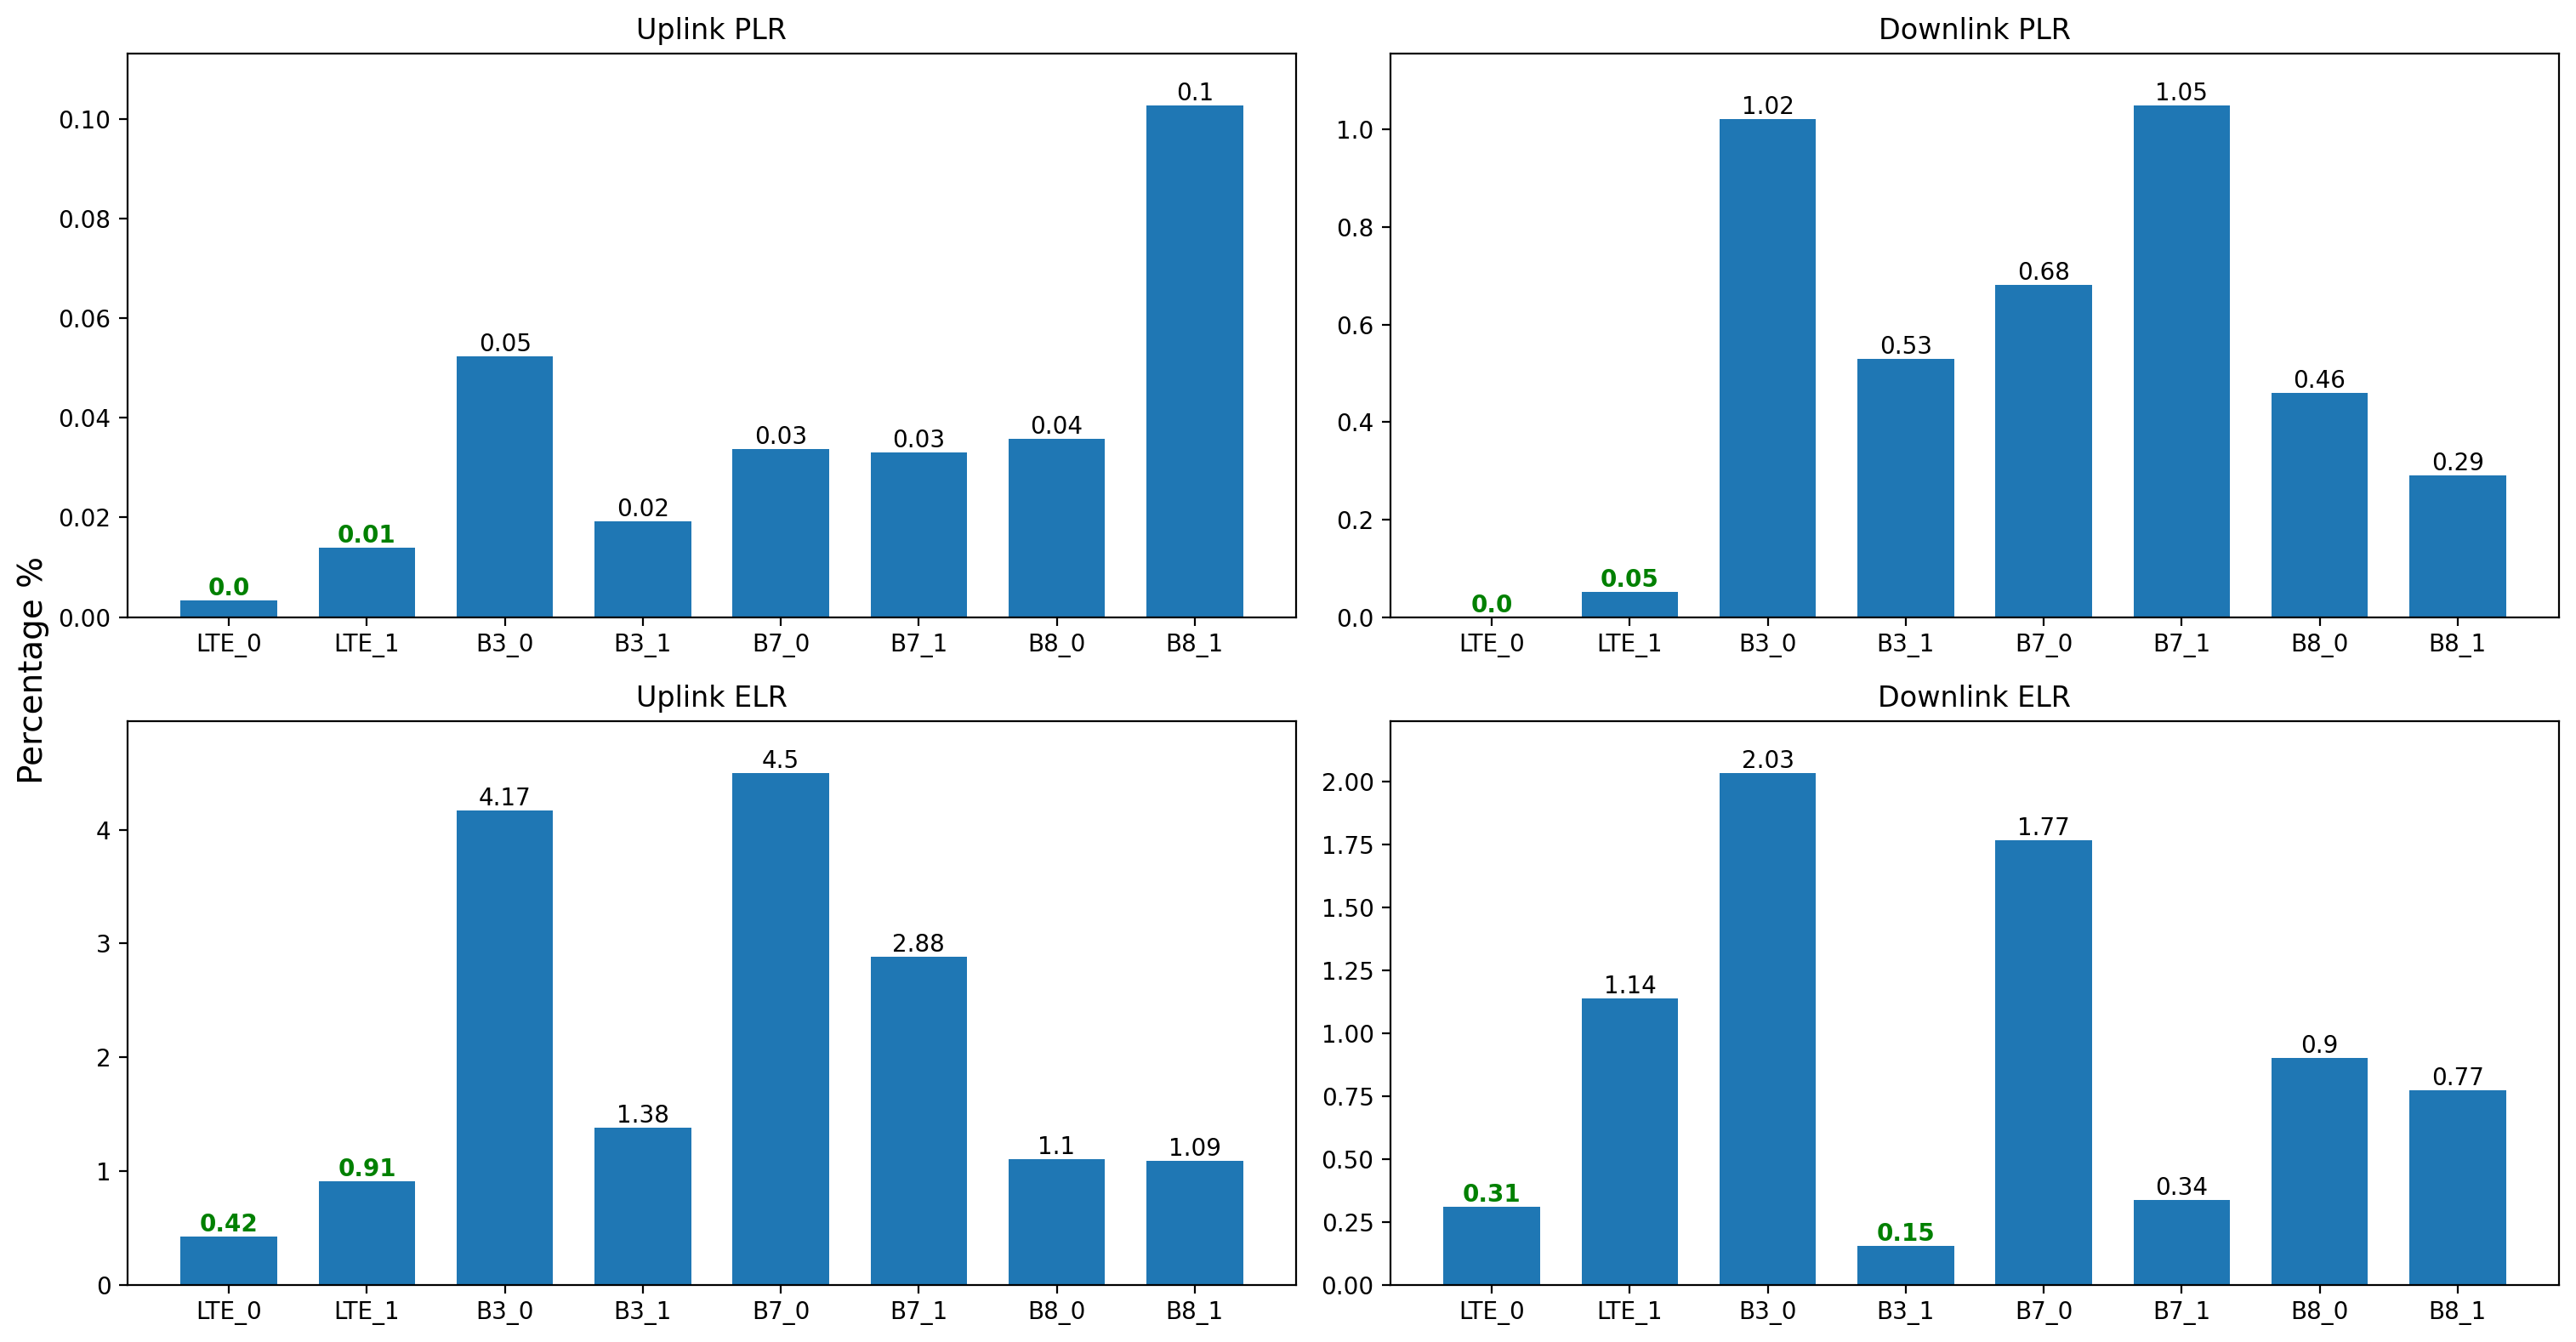

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #04


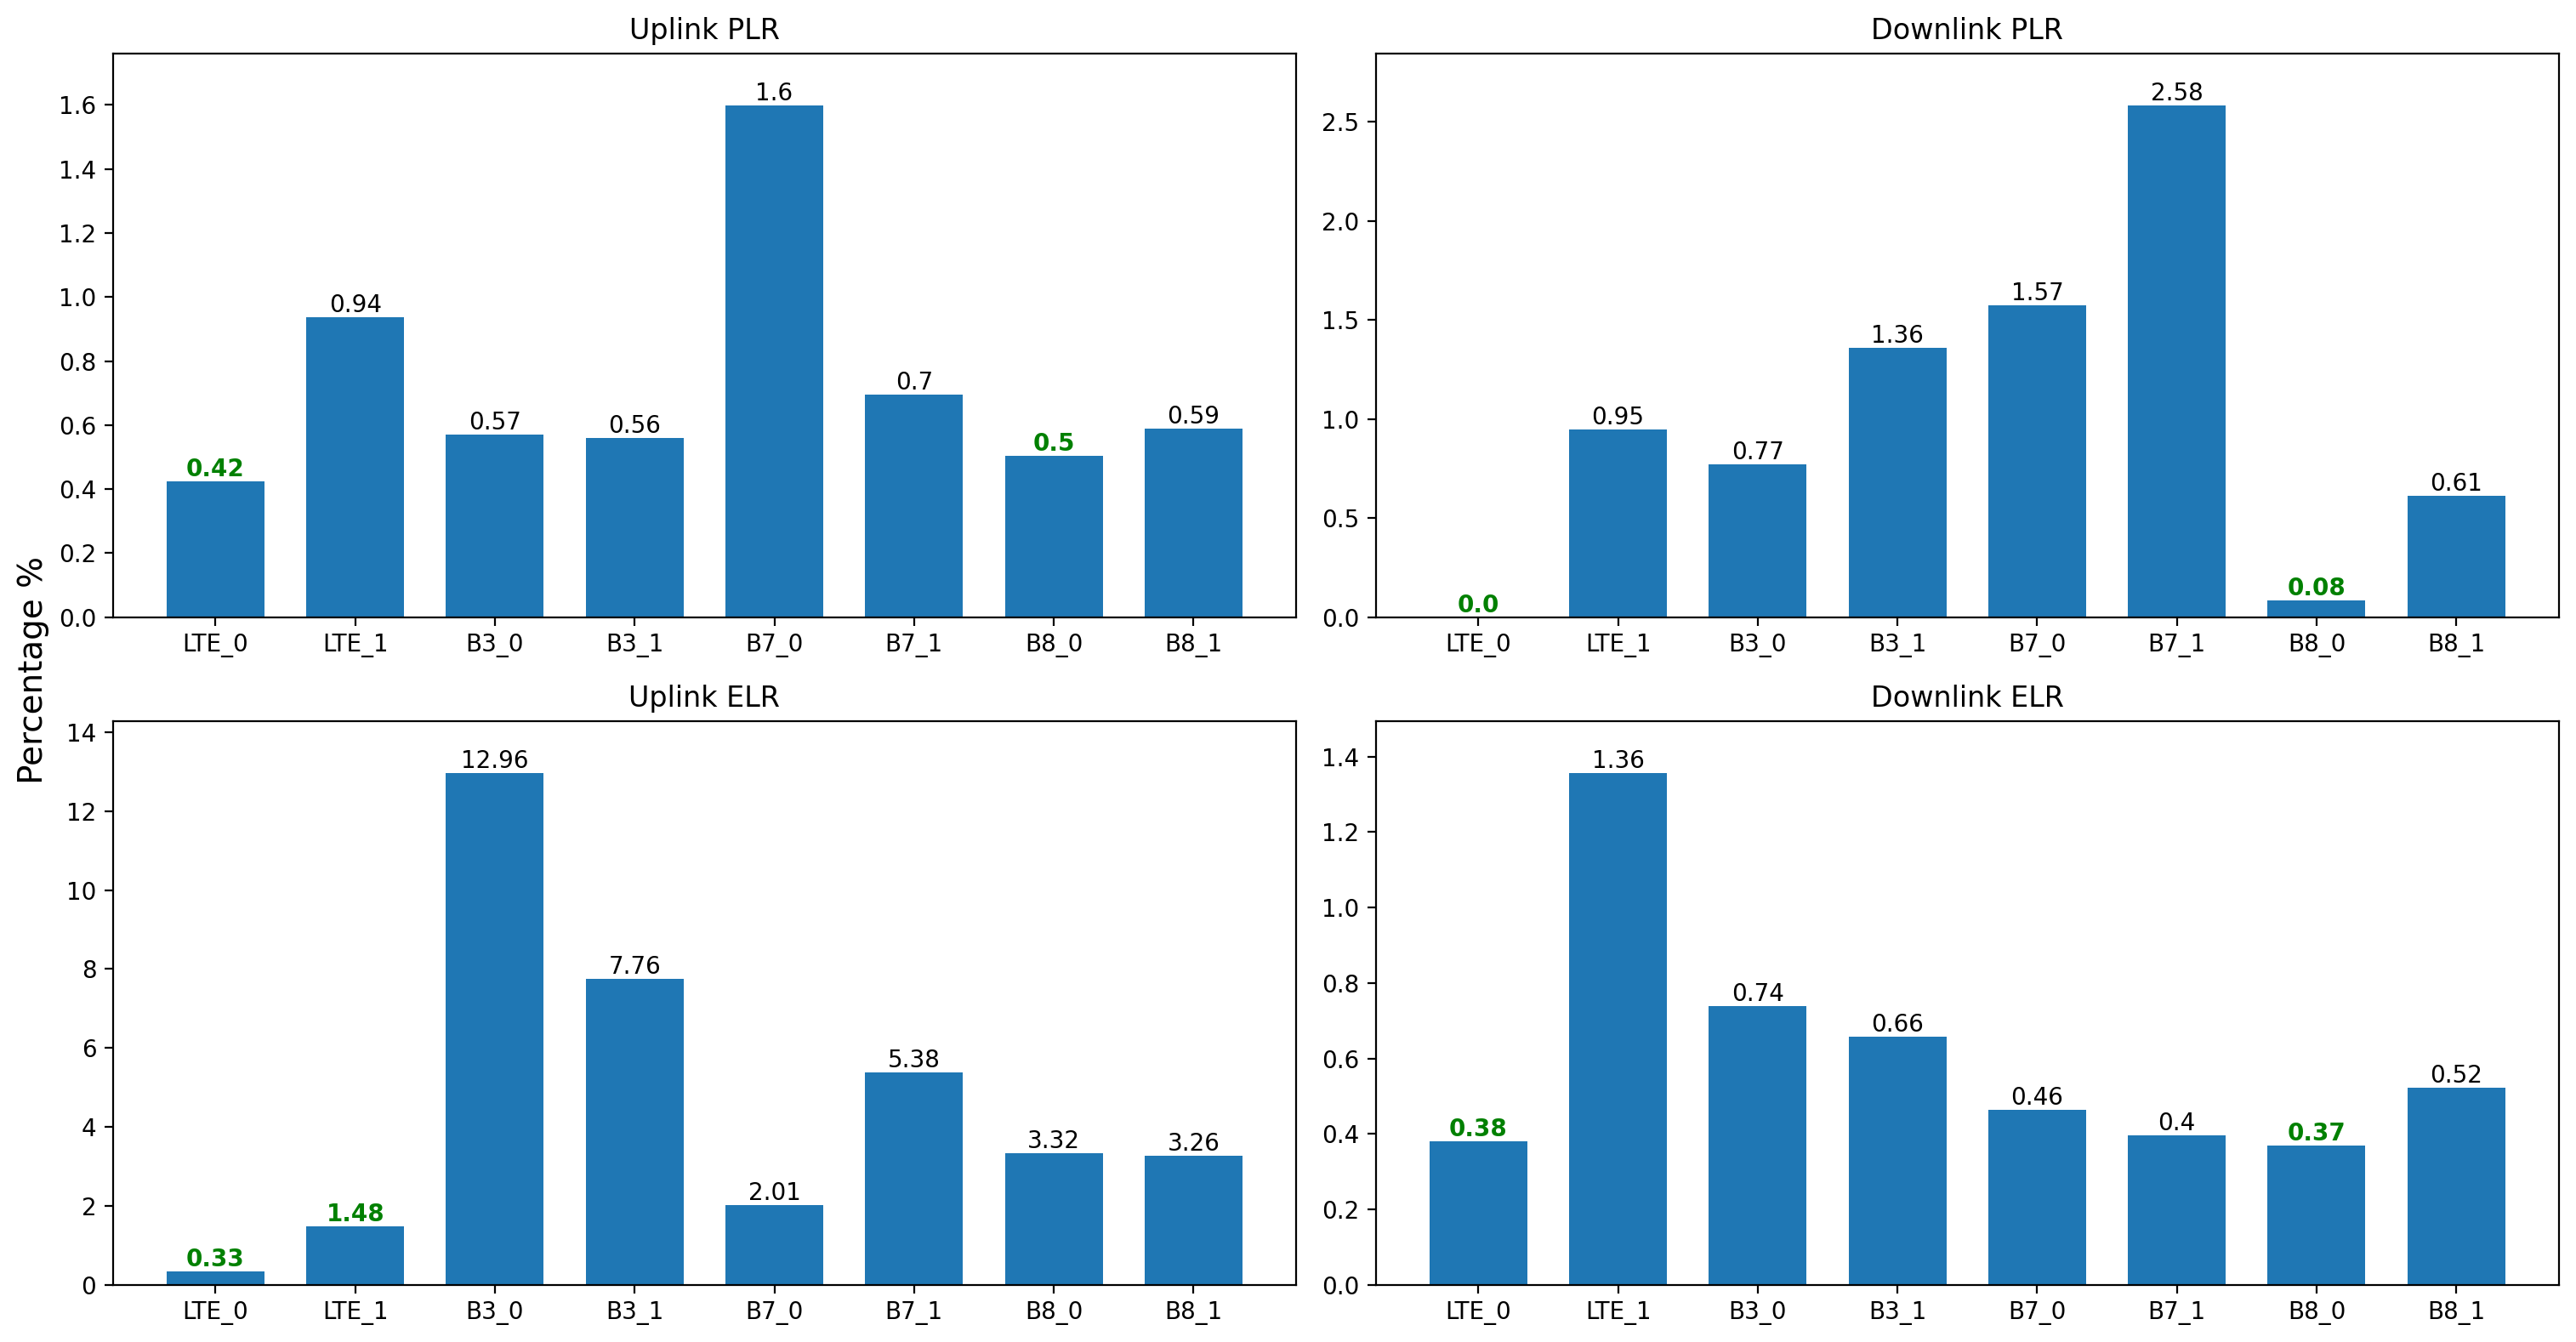

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #05


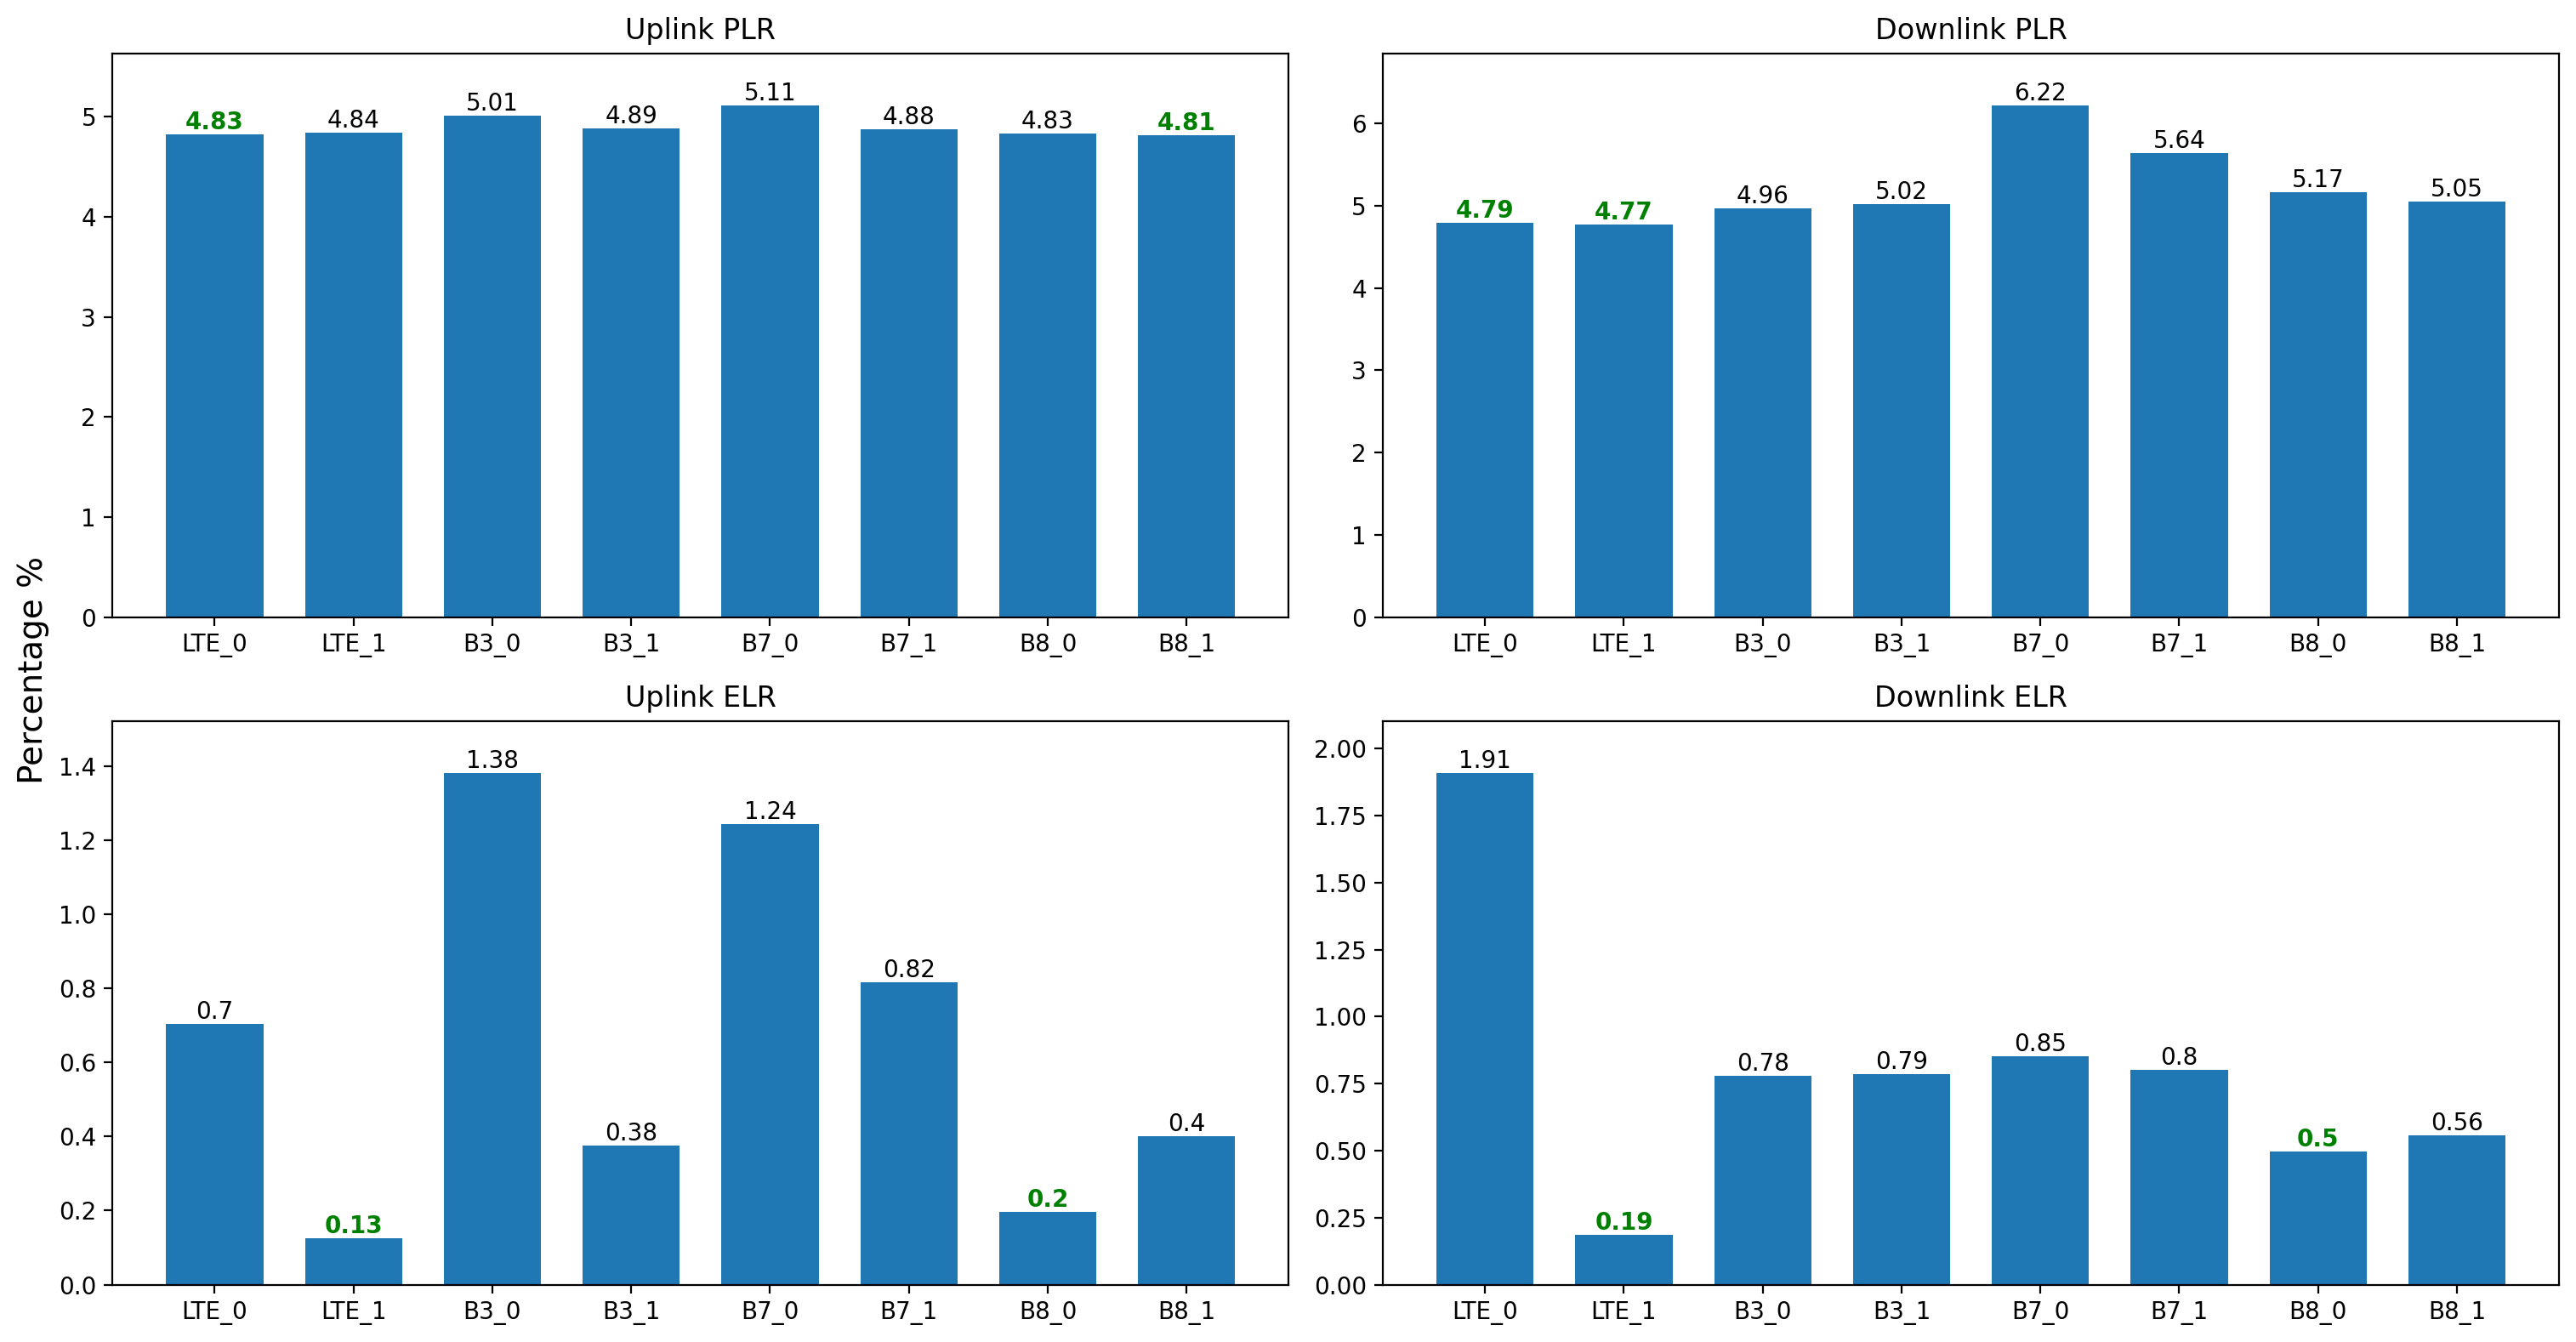

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #06


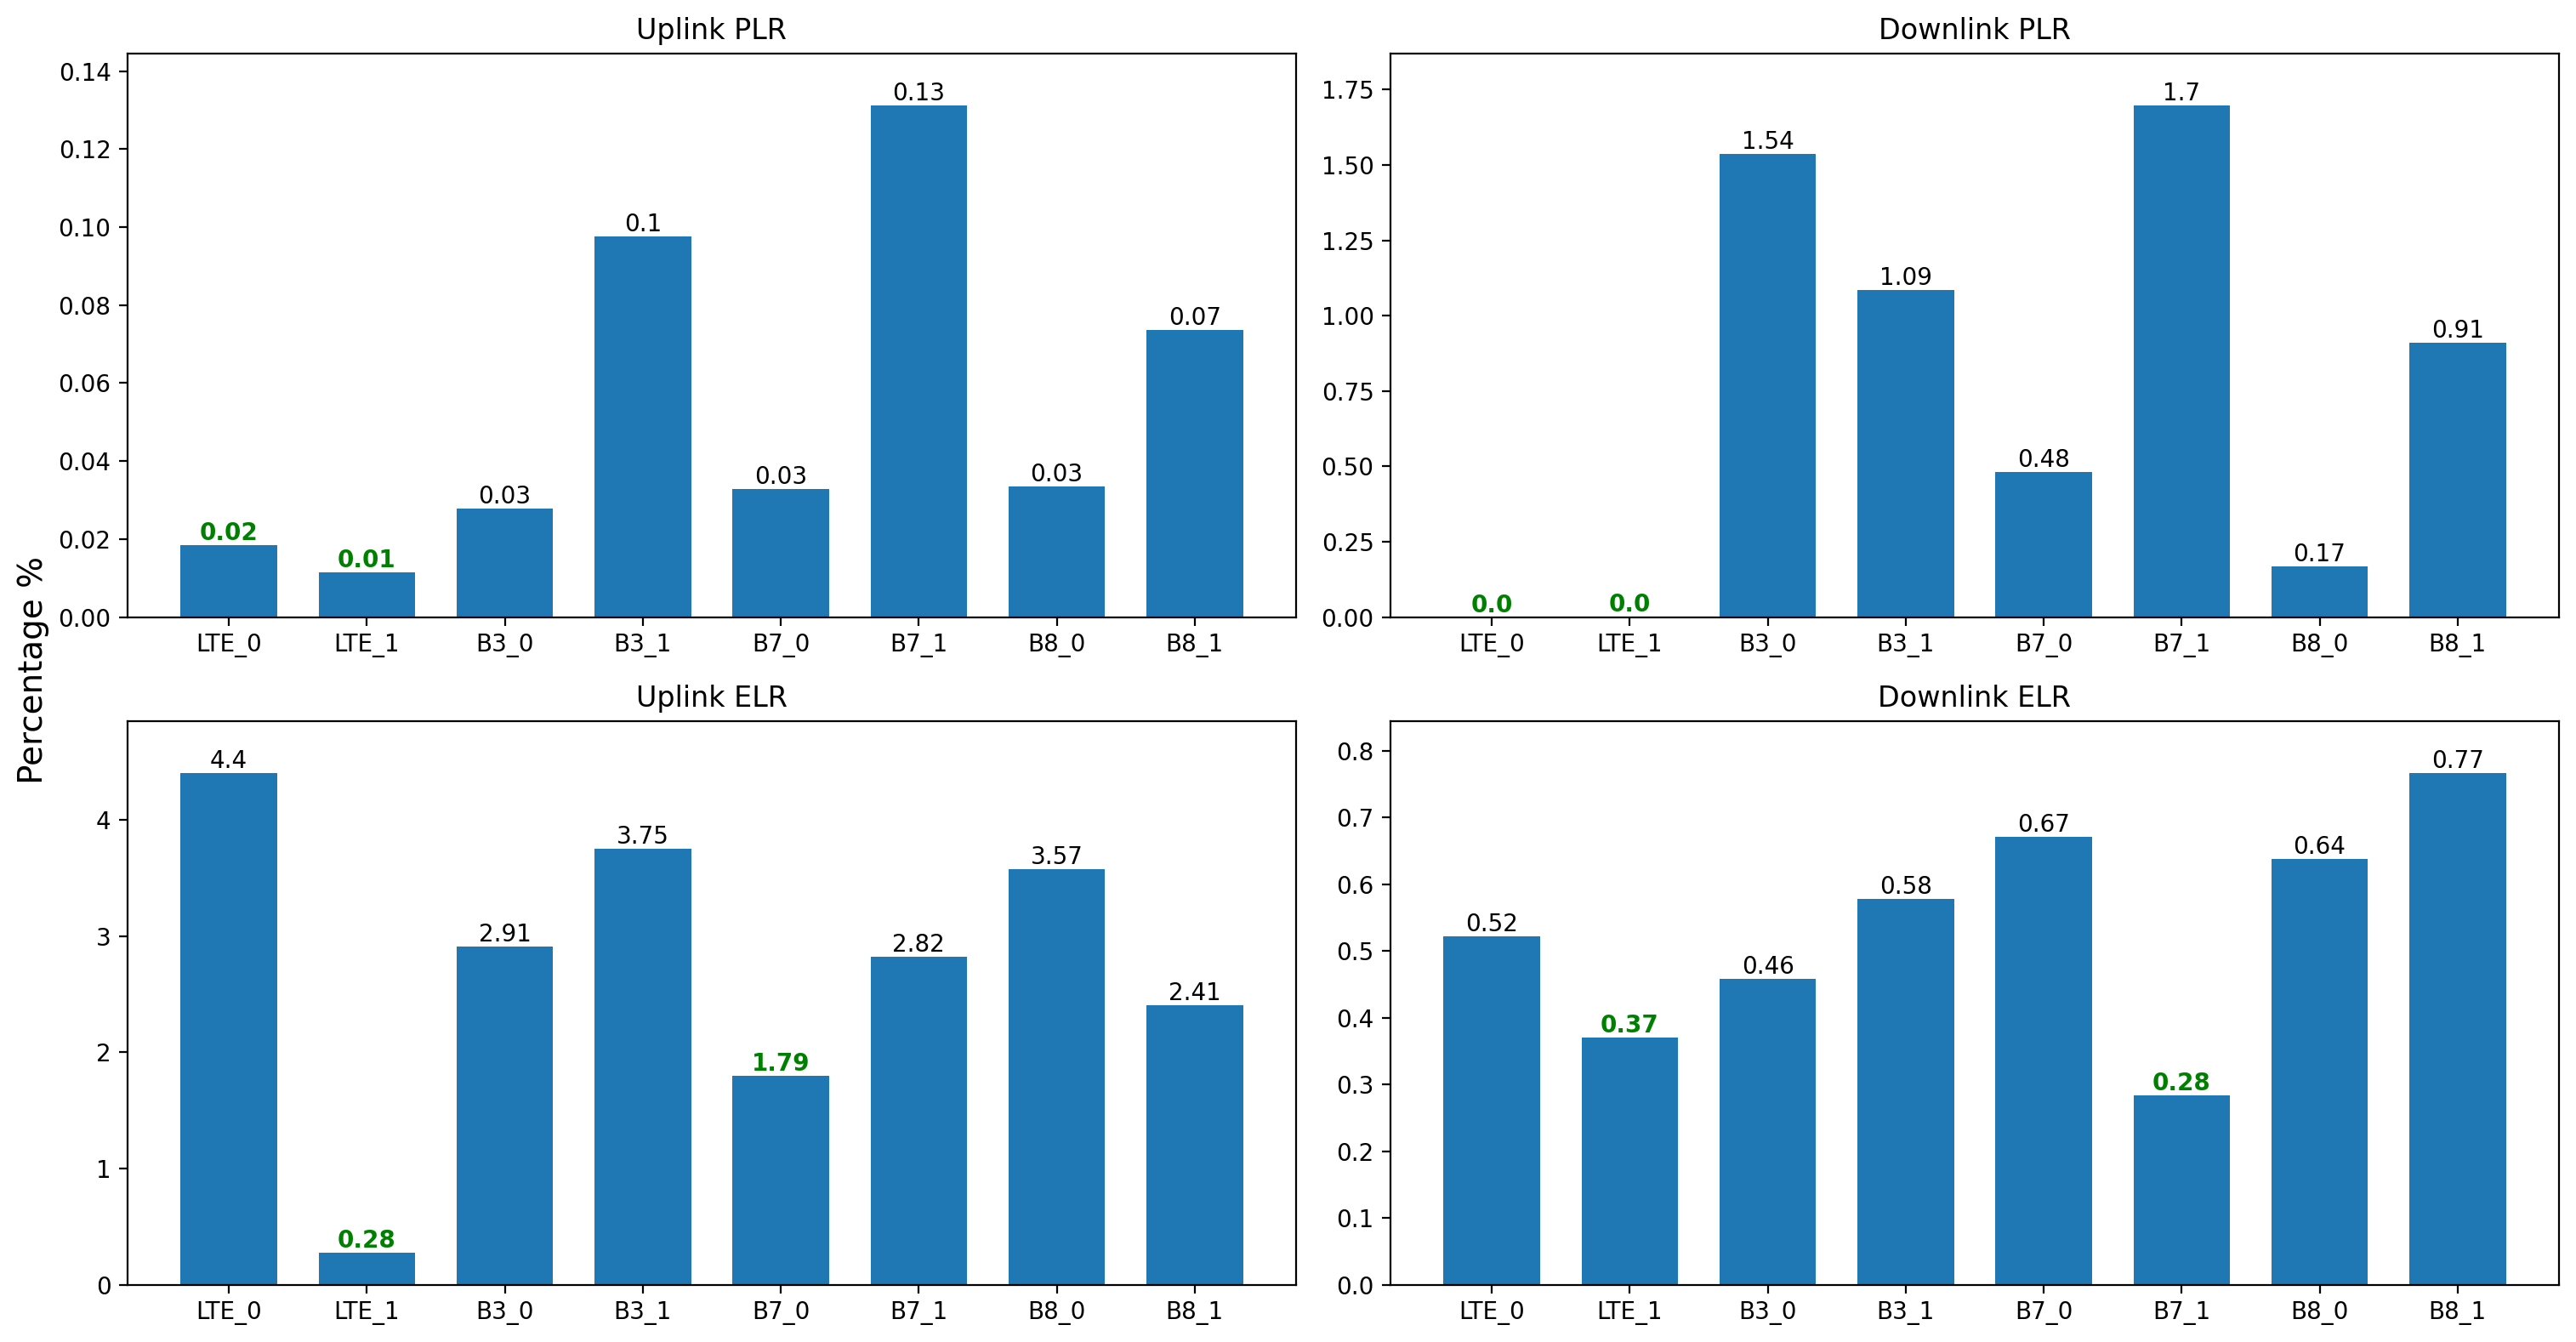

In [13]:
for expr, metrics_dict in zip(exp_list, single_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)
    
    ### Ranking
    devices = expr.setting.keys()
    for tag in ['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']:
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        print(f'{title} Ranking:')
        
        data_dict = {k: v[tag] for k, v in metrics_dict.items()}
        
        # ranking_dict = {'Schm': {k: v for k, v in zip(expr.setting.keys(), add_suffix_to_duplicate_category(expr.setting.values()))}}
        ranking_dict = {}
        score_dict = {k: [] for k in devices}
        
        for i, tr in enumerate(expr.traces):
            # print(i, tr)
            data = [v[i] for v in data_dict.values()]
            data = [num if num >= 0 else np.inf for num in data]
            na_indices = [i for i, num in enumerate(data) if np.isinf(num)]
            
            sorted_indices = [i for i, x in sorted(enumerate(data), key=lambda x: x[1])]
            ranking = np.zeros(len(data))
            ranking[sorted_indices] = np.arange(1, len(data) + 1)
            ranking[na_indices] = np.nan
            # ranking = [num if not np.isnan(num) else '-' for num in ranking]
            ranking_dict[tr] = {k: v for k, v in zip(devices, ranking)}
            
            # _ranking = [num for num in ranking if num != '-']
            _ranking = [num for num in ranking if not np.isnan(num)]
            _max = max(_ranking); _min = min(_ranking)
            for k, rank in zip(devices, ranking):
                if rank == _min: score_dict[k].append(2)
                elif rank == _min + 1: score_dict[k].append(1)
                elif rank == _max - 1: score_dict[k].append(-1)
                elif rank == _max: score_dict[k].append(-2)
                else: score_dict[k].append(0)
        
        score = [sum(v) for v in score_dict.values()]
        ranking_dict['Score'] = {k: v for k, v in zip(devices, score)}
        
        sorted_indices = [i for i, x in sorted(enumerate(score), key=lambda x: x[1], reverse=True)]
        score_ranking = np.zeros(len(score))
        score_ranking[sorted_indices] = np.arange(1, len(score) + 1)
        ranking_dict['Ranking'] = {k: round(v) for k, v in zip(devices, score_ranking)}
        
        # 转换成两层标头的 DataFrame
        devices = list(expr.setting.keys())
        schemes = add_suffix_to_duplicate_category(expr.setting.values())

        updated_data = {k: {(dev, schm): v[dev] for dev, schm in zip(devices, schemes)}
                        for k, v in ranking_dict.items()}

        ranking_table = pd.DataFrame(updated_data).T
        # ranking_table = pd.DataFrame.from_dict(ranking_dict, orient='index') #.reset_index().rename(columns={'index':'Tr.'})
        
        expr.ranking[tag] = ranking_table
        display(ranking_table)
    
    ### 建立表格方便製圖
    metrics_table = {}
    for pos, tag in enumerate(['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']):
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        # 根據字典建立好閱讀的表格
        metrics_table[tag] = pd.DataFrame(data={k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}, index=expr.traces).reset_index().rename(columns={'index':'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
        
    for idx, tr in enumerate(expr.traces):
        print(f'{expr.date} | {expr.name} -> {tr}')
        
        ### 繪製 Bar Charts
        fig, axes = plt.subplots(2, 2, figsize=(15, 8))
        for pos, tag in enumerate(['ul_loss', 'ul_excl', 'dl_loss', 'dl_excl']):
            title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
            i = pos % 2; j = pos // 2
            
            # Sample data including N/A values
            # categories = list(metrics_dict.keys())
            categories = add_suffix_to_duplicate_category([expr.setting[k] for k in metrics_dict.keys()])
            values = [num if num != '-' else np.nan for num in metrics_table[tag].iloc[idx].tolist()[1:]]
            
            # Create a bar chart using ax.bar()
            axes[i][j].bar(categories, values, width=0.7)
            axes[i][j].set_title(title)

            # Add labels for non-missing values
            _values = values.copy()
            min1 = np.nanmin(_values)
            _values.remove(min1)
            min2 = np.nanmin(_values)
            for k, v in enumerate(values):
                if not np.isnan(v):
                    if v in [min1, min2]:
                        axes[i][j].text(k, v, str(round(v, 2)), ha='center', va='bottom', color='green', fontweight='bold')
                    else:
                        axes[i][j].text(k, v, str(round(v, 2)), ha='center', va='bottom')

            # Add "N/A" label for missing values
            for k, v in enumerate(values):
                if np.isnan(v):
                    axes[i][j].text(k, 0, "N/A", ha='center', va='bottom', color='red', fontweight='bold')
            
            axes[i][j].set_ylim(top=axes[i][j].get_ylim()[1]*1.05)
        
        fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
    
        plt.tight_layout()
        plt.show()

# Dual Radio

In [14]:
def calc_dual_loss_excl_rate(filepath1, filepath2):
    
    if not (os.path.isfile(filepath1) and os.path.isfile(filepath2)):
        return -1, -1
    
    df1 = pd.read_pickle(filepath1) if filepath1.endswith('.pkl') else pd.read_csv(filepath1)
    df2 = pd.read_pickle(filepath2) if filepath2.endswith('.pkl') else pd.read_csv(filepath2)

    st_seq = max([df1['seq'].array[0], df2['seq'].array[0]])
    ed_seq = min([df1['seq'].array[-1], df2['seq'].array[-1]])
    df1 = df1[(df1['seq'] >= st_seq) & (df1['seq'] <= ed_seq)].reset_index(drop=True)
    df2 = df2[(df2['seq'] >= st_seq) & (df2['seq'] <= ed_seq)].reset_index(drop=True)
    
    # PLR Calculation
    loss_condition = df1['lost'] & df2['lost']
    system_loss_rate = loss_condition.mean() * 100

    ### ELR Calculation
    # excl_threshold = 100e-3
    # excl_condition = (df1[~loss_condition]['latency'] > excl_threshold) & (df2[~loss_condition]['latency'] > excl_threshold)
    excl_condition = df1[~loss_condition]['excl'] & df2[~loss_condition]['excl']
    system_excl_rate = excl_condition.mean() * 100
    
    return system_loss_rate, system_excl_rate

dual_metrics_list = []
for expr in exp_list:

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    
    metrics_dict = {}
    
    ### Single Radio
    string_counts = {}
    schemes = add_suffix_to_duplicate_category(expr.setting.values())
    for (dev, ul_paths), (_, dl_paths), schm in tqdm(zip(expr.ul_paths.items(), expr.dl_paths.items(), schemes), ncols=1000):
        
        metrics_dict[schm] = {}
        ul_loss_rates, ul_excl_rates = [], []
        dl_loss_rates, dl_excl_rates = [], []
        for ul_path, dl_path in zip(ul_paths, dl_paths):
            ul_loss_rate, ul_excl_rate = calc_loss_excl_rate(ul_path)
            dl_loss_rate, dl_excl_rate = calc_loss_excl_rate(dl_path)
            
            ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate)
            dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate)
            
        metrics_dict[schm]['ul_loss'] = ul_loss_rates
        metrics_dict[schm]['ul_excl'] = ul_excl_rates
        metrics_dict[schm]['dl_loss'] = dl_loss_rates
        metrics_dict[schm]['dl_excl'] = dl_excl_rates
    
    ### Dual Radio
    devices = list(it.combinations(expr.setting.keys(), 2))
    schemes = list(it.combinations(add_suffix_to_duplicate_category(expr.setting.values()), 2))
    for (dev1, dev2), schm in tqdm(zip(devices, schemes), ncols=1000):
        # print(dev1, dev2)
        schm = '+'.join(schm)
        
        ul_paths1 = expr.ul_paths[dev1]; ul_paths2 = expr.ul_paths[dev2]
        dl_paths1 = expr.dl_paths[dev1]; dl_paths2 = expr.dl_paths[dev2]
        
        metrics_dict[schm] = {}
        ul_loss_rates, ul_excl_rates = [], []
        dl_loss_rates, dl_excl_rates = [], []
        for ul_path1, ul_path2, dl_path1, dl_path2 in zip(ul_paths1, ul_paths2, dl_paths1, dl_paths2):
            ul_loss_rate, ul_excl_rate = calc_dual_loss_excl_rate(ul_path1, ul_path2)
            dl_loss_rate, dl_excl_rate = calc_dual_loss_excl_rate(dl_path1, dl_path2)
            
            ul_loss_rates.append(ul_loss_rate); ul_excl_rates.append(ul_excl_rate)
            dl_loss_rates.append(dl_loss_rate); dl_excl_rates.append(dl_excl_rate)
        
        metrics_dict[schm]['ul_loss'] = ul_loss_rates
        metrics_dict[schm]['ul_excl'] = ul_excl_rates
        metrics_dict[schm]['dl_loss'] = dl_loss_rates
        metrics_dict[schm]['dl_excl'] = dl_excl_rates
    
    dual_metrics_list.append(metrics_dict)
    
    ### Display Table
    metrics_table = {}
    for pos, tag in enumerate(['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']):
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        # 根據字典建立好閱讀的表格
        metrics_table[tag] = pd.DataFrame(data={k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}, index=expr.traces).reset_index().rename(columns={'index':'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    ### Single Ranking
    print('Single Radio Ranking')
    display(expr.metadata)
    
    ### Dual Ranking
    size = len(expr.setting)
    for i, tag in enumerate(['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']):
        if i == 0:
            schemes = metrics_table[tag].columns[1:size+1]
            schm_list = metrics_table[tag].columns[size+1:]
            
            expr.metadata_dual = pd.DataFrame({'Schm': schm_list})
            traces_dict = {k: v.split(', ') for k, v in zip(schemes, expr.dev_traces.values())}
            traces = []
            for schms in schm_list:
                schm1 = schms.split('+')[0]
                schm2 = schms.split('+')[1]
                traces.append(', '.join(sorted(list(set(traces_dict[schm1]) & set(traces_dict[schm2])))))
            expr.metadata_dual = pd.DataFrame({'Schm': schm_list, 'Traces': traces})
        
        # print({k: v[tag] for k, v in metrics_dict.items()})
        data = [np.mean([num for num in v[tag] if num >= 0]) for v in metrics_dict.values()][size:]
        # print(data)
        sorted_indices = [i for i, x in sorted(enumerate(data), key=lambda x: x[1])]
        ranking = np.zeros(len(data))
        ranking[sorted_indices] = np.arange(1, len(data) + 1)

        expr.metadata_dual[f'avg_{tag}'] = data
        expr.metadata_dual[f'{tag}_rank'] = [round(num) for num in ranking]

    print('Dual Radio Ranking:')
    display(expr.metadata_dual)

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Single Radio Ranking


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Dual Radio Ranking:


Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   All_0+All_1  #01, #02, #03, #04     0.017132            25     0.009754   
1    All_0+B3_0  #01, #02, #03, #04     0.009782            11     0.100379   
2    All_0+B3_1  #01, #02, #03, #04     0.009306             9     0.109208   
3    All_0+B7_0  #01, #02, #03, #04     0.011298            15     0.212467   
4    All_0+B7_1  #01, #02, #03, #04     0.014524            22     0.156036   
5    All_0+B8_0  #01, #02, #03, #04     0.016483            24     0.008374   
6    All_0+B8_1  #01, #02, #03, #04     0.009144             7     0.017000   
7    All_1+B3_0  #01, #02, #03, #04     0.014850            23     0.023164   
8    All_1+B3_1  #01, #02, #03, #04     0.013385            19     0.022727   
9    All_1+B7_0  #01, #02, #03, #04     0.012074            16     0.082244   
10   All_1+B7_1  #01, #02, #03, #04     0.012567            17     0.063534   
11   All_1+B8_0  #01, #02, #03, #04     0.022538            27     0.066177   
12   All_1+B8_1  #01, #02, #03, #04     0.009144             8     0.003086   
13    B3_0+B3_1  #01, #02, #03, #04     0.011085            14     0.154154   
14    B3_0+B7_0  #01, #02, #03, #04     0.010279            12     0.131356   
15    B3_0+B7_1  #01, #02, #03, #04     0.082872            28     0.091406   
16    B3_0+B8_0  #01, #02, #03, #04     0.020405            26     0.004052   
17    B3_0+B8_1  #01, #02, #03, #04     0.006390             1     0.037390   
18    B3_1+B7_0  #01, #02, #03, #04     0.007995             2     0.036802   
19    B3_1+B7_1  #01, #02, #03, #04     0.014228            20     0.031035   
20    B3_1+B8_0  #01, #02, #03, #04     0.014392            21     0.003700   
21    B3_1+B8_1  #01, #02, #03, #04     0.008164             3     0.037212   
22    B7_0+B7_1  #01, #02, #03, #04     0.008537             6     0.150562   
23    B7_0+B8_0  #01, #02, #03, #04     0.010932            13     0.002643   
24    B7_0+B8_1  #01, #02, #03, #04     0.008349             4     0.026321   
25    B7_1+B8_0  #01, #02, #03, #04     0.013230            18     0.048492   
26    B7_1+B8_1  #01, #02, #03, #04     0.009516            10     0.038884   
27    B8_0+B8_1  #01, #02, #03, #04     0.008401             5     0.069271   

    dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0              6     1.060746             3     0.251097            27  
1             22     1.333517            11     0.058754             3  
2             23     1.327328            10     0.125105            10  
3             28     1.322553             9     0.199198            23  
4             27     1.364544            12     0.195594            22  
5              5     1.321083             8     0.126338            11  
6              7     0.764731             1     0.208866            25  
7              9     1.438489            15     0.067973             4  
8              8     1.511727            16     0.191392            19  
9             20     1.410283            13     0.205839            24  
10            17     1.598695            17     0.296444            28  
11            18     1.601976            18     0.118767             9  
12             2     1.039685             2     0.185483            18  
13            26     2.864911            27     0.082260             6  
14            24     2.470136            24     0.070277             5  
15            21     2.169666            21     0.147499            13  
16             4     4.437835            28     0.050003             1  
17            14     1.318347             7     0.107196             8  
18            12     2.339875            23     0.129240            12  
19            11     2.172002            22     0.193380            21  
20             3     2.755402            26     0.057578             2  
21            13     1.312336             6     0.097666             7  
22            25     2.104571           

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Single Radio Ranking


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             6   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             4   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             5   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7  #01, #02, #03, #04, #05, #06     1.072479             7   
6   sm06   B8  #01, #02, #03, #04, #05, #06     0.992900             2   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             3   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             5     0.831878   
5     2.280974             8     3.266161             6     0.730304   
6     1.036093             3     2.564579             4     0.495090   
7     1.476035             4     2.474258             3     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             4  
6             1  
7             3

Dual Radio Ranking:


Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   LTE_0+LTE_1  #01, #02, #03, #04, #05, #06     0.799353            23   
1    LTE_0+B3_0  #01, #02, #03, #04, #05, #06     0.792909             7   
2    LTE_0+B3_1  #01, #02, #03, #04, #05, #06     0.793947            11   
3    LTE_0+B7_0  #01, #02, #03, #04, #05, #06     0.792712             6   
4    LTE_0+B7_1  #01, #02, #03, #04, #05, #06     0.792925             8   
5    LTE_0+B8_0  #01, #02, #03, #04, #05, #06     0.791031             1   
6    LTE_0+B8_1  #01, #02, #03, #04, #05, #06     0.798440            22   
7    LTE_1+B3_0  #01, #02, #03, #04, #05, #06     0.795283            16   
8    LTE_1+B3_1  #01, #02, #03, #04, #05, #06     0.793711            10   
9    LTE_1+B7_0  #01, #02, #03, #04, #05, #06     0.808278            25   
10   LTE_1+B7_1  #01, #02, #03, #04, #05, #06     0.796430            19   
11   LTE_1+B8_0  #01, #02, #03, #04, #05, #06     0.796003            18   
12   LTE_1+B8_1  #01, #02, #03, #04, #05, #06     0.798366            21   
13    B3_0+B3_1  #01, #02, #03, #04, #05, #06     0.801080            24   
14    B3_0+B7_0  #01, #02, #03, #04, #05, #06     0.811982            27   
15    B3_0+B7_1  #01, #02, #03, #04, #05, #06     0.798042            20   
16    B3_0+B8_0  #01, #02, #03, #04, #05, #06     0.792419             4   
17    B3_0+B8_1  #01, #02, #03, #04, #05, #06     0.794188            13   
18    B3_1+B7_0  #01, #02, #03, #04, #05, #06     0.794039            12   
19    B3_1+B7_1  #01, #02, #03, #04, #05, #06     0.794898            15   
20    B3_1+B8_0  #01, #02, #03, #04, #05, #06     0.792515             5   
21    B3_1+B8_1  #01, #02, #03, #04, #05, #06     0.792049             3   
22    B7_0+B7_1  #01, #02, #03, #04, #05, #06     0.824537            28   
23    B7_0+B8_0  #01, #02, #03, #04, #05, #06     0.795820            17   
24    B7_0+B8_1  #01, #02, #03, #04, #05, #06     0.811029            26   
25    B7_1+B8_0  #01, #02, #03, #04, #05, #06     0.794782            14   
26    B7_1+B8_1  #01, #02, #03, #04, #05, #06     0.791179             2   
27    B8_0+B8_1  #01, #02, #03, #04, #05, #06     0.793554             9   

    avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0      0.792646             1     0.028843             3     0.294806   
1      0.792950             5     0.039773             5     0.044183   
2      0.792854             3     0.048648             6     0.046718   
3      0.798591             8     0.082327             7     0.227947   
4      0.792683             2     0.024031             2     0.192922   
5      0.792891             4     0.032729             4     0.015147   
6      0.795002             7     0.022611             1     0.068341   
7      0.875096            14     0.197426            12     0.023538   
8      0.893729            16     0.187152            11     0.014780   
9      0.900598            17     0.170452            10     0.095096   
10     0.903550            18     0.204839            13     0.134513   
11     0.794801             6     0.108931             8     0.019560   
12     0.887442            15     0.131847             9     0.020412   
13     1.086348            27     2.813977            28     0.135948   
14     0.998914            21     1.823793            23     0.291474   
15     0.979449            19     2.039648            24     0.073756   
16     0.815163            10     2.087060            25     0.086485   
17     1.036675            24     1.556509            20     0.062557   
18     0.982675            20     1.546468            18     0.118466   
19     1.015215            22     2.187086            27     0.084308   
20     0.819588            12     2.112702            26     0.122067   
21     1.024718            23     1.689115            21     0.107599   
22     1.169328            28     1.528424            17     0.080726   
23     0.809010             9     1.368674            

## Heatmap

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   All_0+All_1  #01, #02, #03, #04     0.017132            25     0.009754   
1    All_0+B3_0  #01, #02, #03, #04     0.009782            11     0.100379   
2    All_0+B3_1  #01, #02, #03, #04     0.009306             9     0.109208   
3    All_0+B7_0  #01, #02, #03, #04     0.011298            15     0.212467   
4    All_0+B7_1  #01, #02, #03, #04     0.014524            22     0.156036   
5    All_0+B8_0  #01, #02, #03, #04     0.016483            24     0.008374   
6    All_0+B8_1  #01, #02, #03, #04     0.009144             7     0.017000   
7    All_1+B3_0  #01, #02, #03, #04     0.014850            23     0.023164   
8    All_1+B3_1  #01, #02, #03, #04     0.013385            19     0.022727   
9    All_1+B7_0  #01, #02, #03, #04     0.012074            16     0.082244   
10   All_1+B7_1  #01, #02, #03, #04     0.012567            17     0.063534   
11   All_1+B8_0  #01, #02, #03, #04     0.022538            27     0.066177   
12   All_1+B8_1  #01, #02, #03, #04     0.009144             8     0.003086   
13    B3_0+B3_1  #01, #02, #03, #04     0.011085            14     0.154154   
14    B3_0+B7_0  #01, #02, #03, #04     0.010279            12     0.131356   
15    B3_0+B7_1  #01, #02, #03, #04     0.082872            28     0.091406   
16    B3_0+B8_0  #01, #02, #03, #04     0.020405            26     0.004052   
17    B3_0+B8_1  #01, #02, #03, #04     0.006390             1     0.037390   
18    B3_1+B7_0  #01, #02, #03, #04     0.007995             2     0.036802   
19    B3_1+B7_1  #01, #02, #03, #04     0.014228            20     0.031035   
20    B3_1+B8_0  #01, #02, #03, #04     0.014392            21     0.003700   
21    B3_1+B8_1  #01, #02, #03, #04     0.008164             3     0.037212   
22    B7_0+B7_1  #01, #02, #03, #04     0.008537             6     0.150562   
23    B7_0+B8_0  #01, #02, #03, #04     0.010932            13     0.002643   
24    B7_0+B8_1  #01, #02, #03, #04     0.008349             4     0.026321   
25    B7_1+B8_0  #01, #02, #03, #04     0.013230            18     0.048492   
26    B7_1+B8_1  #01, #02, #03, #04     0.009516            10     0.038884   
27    B8_0+B8_1  #01, #02, #03, #04     0.008401             5     0.069271   

    dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0              6     1.060746             3     0.251097            27  
1             22     1.333517            11     0.058754             3  
2             23     1.327328            10     0.125105            10  
3             28     1.322553             9     0.199198            23  
4             27     1.364544            12     0.195594            22  
5              5     1.321083             8     0.126338            11  
6              7     0.764731             1     0.208866            25  
7              9     1.438489            15     0.067973             4  
8              8     1.511727            16     0.191392            19  
9             20     1.410283            13     0.205839            24  
10            17     1.598695            17     0.296444            28  
11            18     1.601976            18     0.118767             9  
12             2     1.039685             2     0.185483            18  
13            26     2.864911            27     0.082260             6  
14            24     2.470136            24     0.070277             5  
15            21     2.169666            21     0.147499            13  
16             4     4.437835            28     0.050003             1  
17            14     1.318347             7     0.107196             8  
18            12     2.339875            23     0.129240            12  
19            11     2.172002            22     0.193380            21  
20             3     2.755402            26     0.057578             2  
21            13     1.312336             6     0.097666             7  
22            25     2.104571           

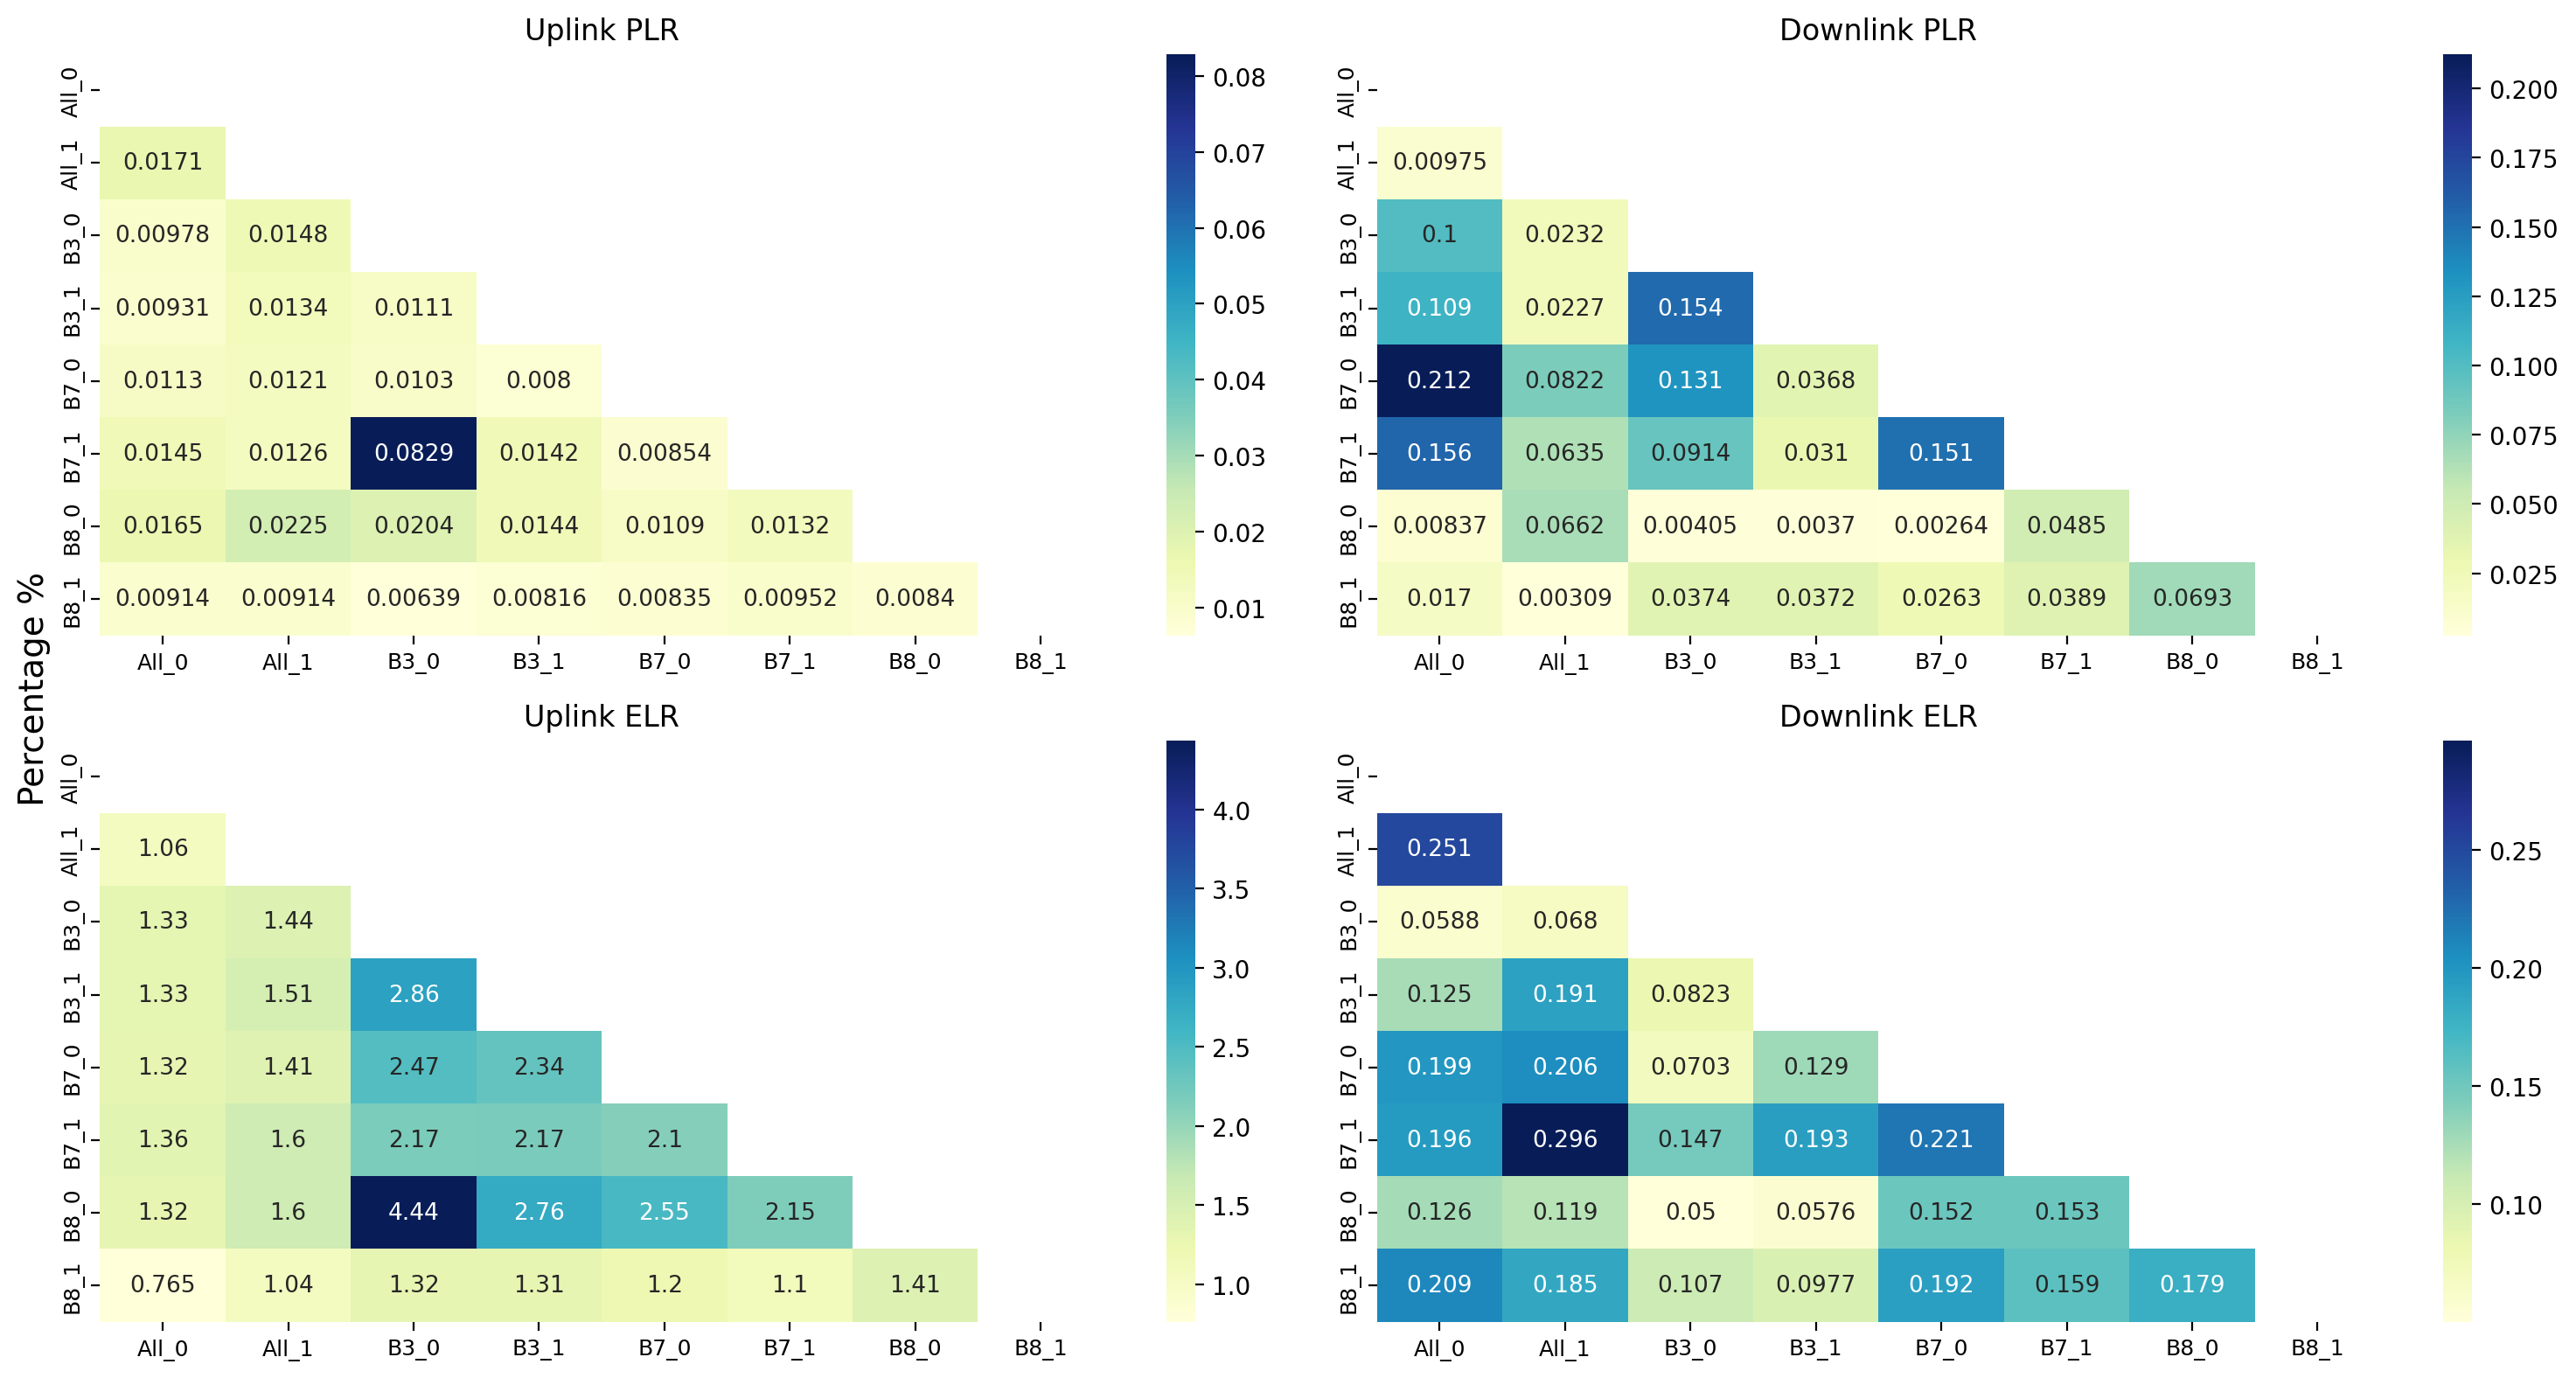

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             6   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             4   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             5   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7  #01, #02, #03, #04, #05, #06     1.072479             7   
6   sm06   B8  #01, #02, #03, #04, #05, #06     0.992900             2   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             3   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             5     0.831878   
5     2.280974             8     3.266161             6     0.730304   
6     1.036093             3     2.564579             4     0.495090   
7     1.476035             4     2.474258             3     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             4  
6             1  
7             3

Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   LTE_0+LTE_1  #01, #02, #03, #04, #05, #06     0.799353            23   
1    LTE_0+B3_0  #01, #02, #03, #04, #05, #06     0.792909             7   
2    LTE_0+B3_1  #01, #02, #03, #04, #05, #06     0.793947            11   
3    LTE_0+B7_0  #01, #02, #03, #04, #05, #06     0.792712             6   
4    LTE_0+B7_1  #01, #02, #03, #04, #05, #06     0.792925             8   
5    LTE_0+B8_0  #01, #02, #03, #04, #05, #06     0.791031             1   
6    LTE_0+B8_1  #01, #02, #03, #04, #05, #06     0.798440            22   
7    LTE_1+B3_0  #01, #02, #03, #04, #05, #06     0.795283            16   
8    LTE_1+B3_1  #01, #02, #03, #04, #05, #06     0.793711            10   
9    LTE_1+B7_0  #01, #02, #03, #04, #05, #06     0.808278            25   
10   LTE_1+B7_1  #01, #02, #03, #04, #05, #06     0.796430            19   
11   LTE_1+B8_0  #01, #02, #03, #04, #05, #06     0.796003            18   
12   LTE_1+B8_1  #01, #02, #03, #04, #05, #06     0.798366            21   
13    B3_0+B3_1  #01, #02, #03, #04, #05, #06     0.801080            24   
14    B3_0+B7_0  #01, #02, #03, #04, #05, #06     0.811982            27   
15    B3_0+B7_1  #01, #02, #03, #04, #05, #06     0.798042            20   
16    B3_0+B8_0  #01, #02, #03, #04, #05, #06     0.792419             4   
17    B3_0+B8_1  #01, #02, #03, #04, #05, #06     0.794188            13   
18    B3_1+B7_0  #01, #02, #03, #04, #05, #06     0.794039            12   
19    B3_1+B7_1  #01, #02, #03, #04, #05, #06     0.794898            15   
20    B3_1+B8_0  #01, #02, #03, #04, #05, #06     0.792515             5   
21    B3_1+B8_1  #01, #02, #03, #04, #05, #06     0.792049             3   
22    B7_0+B7_1  #01, #02, #03, #04, #05, #06     0.824537            28   
23    B7_0+B8_0  #01, #02, #03, #04, #05, #06     0.795820            17   
24    B7_0+B8_1  #01, #02, #03, #04, #05, #06     0.811029            26   
25    B7_1+B8_0  #01, #02, #03, #04, #05, #06     0.794782            14   
26    B7_1+B8_1  #01, #02, #03, #04, #05, #06     0.791179             2   
27    B8_0+B8_1  #01, #02, #03, #04, #05, #06     0.793554             9   

    avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0      0.792646             1     0.028843             3     0.294806   
1      0.792950             5     0.039773             5     0.044183   
2      0.792854             3     0.048648             6     0.046718   
3      0.798591             8     0.082327             7     0.227947   
4      0.792683             2     0.024031             2     0.192922   
5      0.792891             4     0.032729             4     0.015147   
6      0.795002             7     0.022611             1     0.068341   
7      0.875096            14     0.197426            12     0.023538   
8      0.893729            16     0.187152            11     0.014780   
9      0.900598            17     0.170452            10     0.095096   
10     0.903550            18     0.204839            13     0.134513   
11     0.794801             6     0.108931             8     0.019560   
12     0.887442            15     0.131847             9     0.020412   
13     1.086348            27     2.813977            28     0.135948   
14     0.998914            21     1.823793            23     0.291474   
15     0.979449            19     2.039648            24     0.073756   
16     0.815163            10     2.087060            25     0.086485   
17     1.036675            24     1.556509            20     0.062557   
18     0.982675            20     1.546468            18     0.118466   
19     1.015215            22     2.187086            27     0.084308   
20     0.819588            12     2.112702            26     0.122067   
21     1.024718            23     1.689115            21     0.107599   
22     1.169328            28     1.528424            17     0.080726   
23     0.809010             9     1.368674            

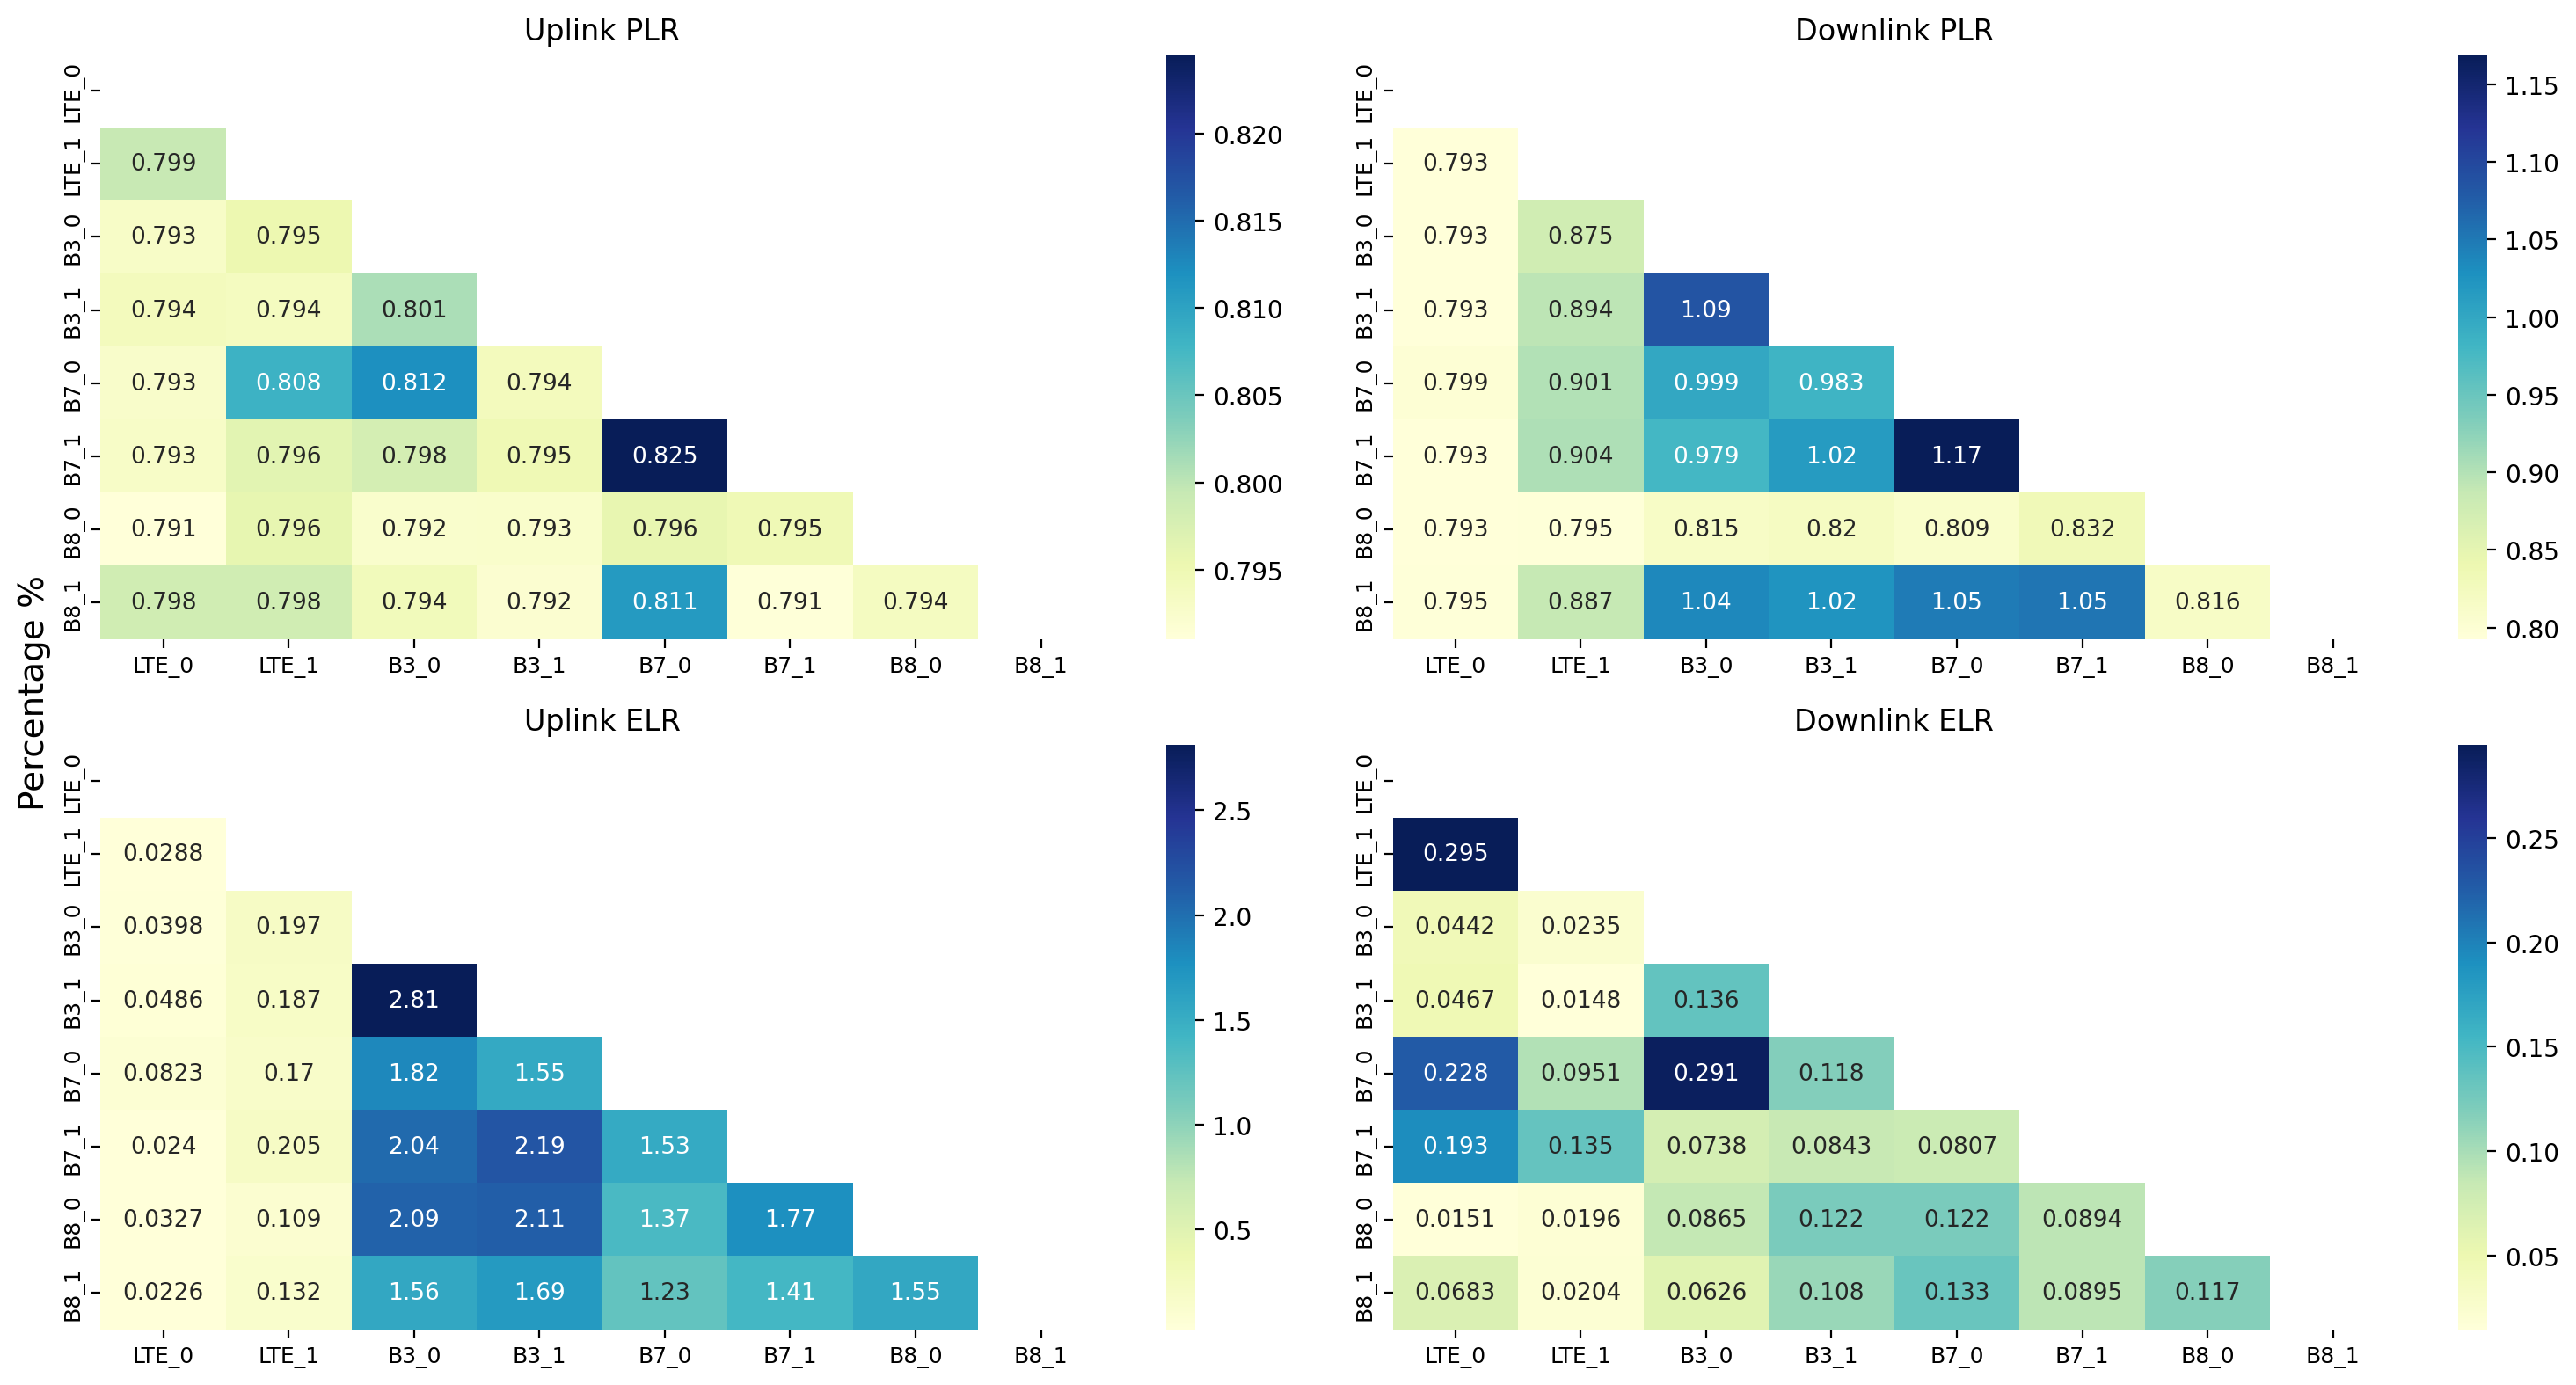

In [15]:
def mask(size, mode='lower', diag=True):
    
    mask = np.ones((size, size))
    if mode == 'lower': # 保留下三角(遮蔽上三角)
        mask[np.tril_indices(size)] = 0
    elif mode == 'upper': # 保留上三角(遮蔽下三角)
        mask[np.triu_indices(size)] = 0
    elif mode == 'square': # 全保留
        mask = np.zeros((size, size))
    else:
        print(f"Warning: mask() has no option '{mode}' for argument: 'mode'.")
        print("Please specify 'upper', 'lower', or 'square' instead.")
    
    if not diag: # 不保留對角線(遮蔽對角線)
        mask[np.diag_indices(size)] = 1

    return mask

for expr, metrics_dict in zip(exp_list, dual_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)
    display(expr.metadata_dual)
    
    ### 建立表格方便製圖
    metrics_table = {}
    for pos, tag in enumerate(['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']):
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        # 根據字典建立好閱讀的表格
        metrics_table[tag] = pd.DataFrame(data={k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}, index=expr.traces).reset_index().rename(columns={'index':'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    schemes = add_suffix_to_duplicate_category(expr.setting.values())
    combinations = ['+'.join(s) if s[0] != s[1] else s[0] for s in it.product(schemes, repeat=2)]
    
    size = len(expr.setting)
    
    ### Average
    # print(f'{expr.date} | {expr.name}')
    # for ndiag in [False, True]:
    for ndiag in [True]:
        fig, axes = plt.subplots(2, 2, figsize=(15, 8))
        for pos, tag in enumerate(['ul_loss', 'ul_excl', 'dl_loss', 'dl_excl']):
            title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
            i = pos % 2; j = pos // 2
            
            data = [np.nanmean([num if num >= 0 else np.nan for num in metrics_dict[comb][tag]]) if comb in metrics_dict else -1 for comb in combinations]
            reshaped_data = np.array(data).reshape(size, size)
            sns.heatmap(reshaped_data.T, ax=axes[i][j], annot=True, fmt='.3g', mask=mask(size, diag=not ndiag), annot_kws={"size": 9.5}, cmap="YlGnBu")
            axes[i][j].set_xticklabels(schemes, fontsize=9)
            axes[i][j].set_yticklabels(schemes, fontsize=9)
            axes[i][j].set_title(title)
            
            # 在相应位置上标注"N/A"
            _mask = mask(size, diag=not ndiag)
            rows, cols = reshaped_data.shape
            for k in range(rows):
                for l in range(cols):
                    if np.isnan(reshaped_data.T[k][l]) and _mask[k][l] == 0:
                        axes[i][j].text(l + 0.5, k + 0.5, "N/A", ha='center', va='center', color='red', fontweight='bold')
        
        fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
        
        plt.tight_layout()
        plt.show()

## Heatmap: Per Round

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   All_0+All_1  #01, #02, #03, #04     0.017132            25     0.009754   
1    All_0+B3_0  #01, #02, #03, #04     0.009782            11     0.100379   
2    All_0+B3_1  #01, #02, #03, #04     0.009306             9     0.109208   
3    All_0+B7_0  #01, #02, #03, #04     0.011298            15     0.212467   
4    All_0+B7_1  #01, #02, #03, #04     0.014524            22     0.156036   
5    All_0+B8_0  #01, #02, #03, #04     0.016483            24     0.008374   
6    All_0+B8_1  #01, #02, #03, #04     0.009144             7     0.017000   
7    All_1+B3_0  #01, #02, #03, #04     0.014850            23     0.023164   
8    All_1+B3_1  #01, #02, #03, #04     0.013385            19     0.022727   
9    All_1+B7_0  #01, #02, #03, #04     0.012074            16     0.082244   
10   All_1+B7_1  #01, #02, #03, #04     0.012567            17     0.063534   
11   All_1+B8_0  #01, #02, #03, #04     0.022538            27     0.066177   
12   All_1+B8_1  #01, #02, #03, #04     0.009144             8     0.003086   
13    B3_0+B3_1  #01, #02, #03, #04     0.011085            14     0.154154   
14    B3_0+B7_0  #01, #02, #03, #04     0.010279            12     0.131356   
15    B3_0+B7_1  #01, #02, #03, #04     0.082872            28     0.091406   
16    B3_0+B8_0  #01, #02, #03, #04     0.020405            26     0.004052   
17    B3_0+B8_1  #01, #02, #03, #04     0.006390             1     0.037390   
18    B3_1+B7_0  #01, #02, #03, #04     0.007995             2     0.036802   
19    B3_1+B7_1  #01, #02, #03, #04     0.014228            20     0.031035   
20    B3_1+B8_0  #01, #02, #03, #04     0.014392            21     0.003700   
21    B3_1+B8_1  #01, #02, #03, #04     0.008164             3     0.037212   
22    B7_0+B7_1  #01, #02, #03, #04     0.008537             6     0.150562   
23    B7_0+B8_0  #01, #02, #03, #04     0.010932            13     0.002643   
24    B7_0+B8_1  #01, #02, #03, #04     0.008349             4     0.026321   
25    B7_1+B8_0  #01, #02, #03, #04     0.013230            18     0.048492   
26    B7_1+B8_1  #01, #02, #03, #04     0.009516            10     0.038884   
27    B8_0+B8_1  #01, #02, #03, #04     0.008401             5     0.069271   

    dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0              6     1.060746             3     0.251097            27  
1             22     1.333517            11     0.058754             3  
2             23     1.327328            10     0.125105            10  
3             28     1.322553             9     0.199198            23  
4             27     1.364544            12     0.195594            22  
5              5     1.321083             8     0.126338            11  
6              7     0.764731             1     0.208866            25  
7              9     1.438489            15     0.067973             4  
8              8     1.511727            16     0.191392            19  
9             20     1.410283            13     0.205839            24  
10            17     1.598695            17     0.296444            28  
11            18     1.601976            18     0.118767             9  
12             2     1.039685             2     0.185483            18  
13            26     2.864911            27     0.082260             6  
14            24     2.470136            24     0.070277             5  
15            21     2.169666            21     0.147499            13  
16             4     4.437835            28     0.050003             1  
17            14     1.318347             7     0.107196             8  
18            12     2.339875            23     0.129240            12  
19            11     2.172002            22     0.193380            21  
20             3     2.755402            26     0.057578             2  
21            13     1.312336             6     0.097666             7  
22            25     2.104571           

Uplink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       3.0   7.0  8.0  2.0  4.0  5.0  1.0  6.0
#02       5.0   8.0  6.0  1.0  7.0  3.0  2.0  4.0
#03       3.0   6.0  7.0  1.0  2.0  8.0  5.0  4.0
#04       6.0   5.0  1.0  3.0  8.0  4.0  7.0  2.0
Score     0.0  -3.0 -1.0  5.0 -2.0 -2.0  2.0  1.0
Ranking   4.0   8.0  5.0  1.0  6.0  7.0  2.0  3.0

All_0+All_1  All_0+B3_0  All_0+B3_1  All_0+B7_0  All_0+B7_1  \
#01              1.0         2.0         3.0         4.0         5.0   
#02             24.0         1.0         2.0        26.0         3.0   
#03             25.0        11.0         8.0        13.0        22.0   
#04              1.0         2.0        19.0        22.0        17.0   
Score            6.0         7.0         3.0        -2.0         1.0   
Ranking          2.0         1.0         3.0        23.0         5.0   

         All_0+B8_0  All_0+B8_1  All_1+B3_0  All_1+B3_1  All_1+B7_0  \
#01            25.0         6.0         7.0        26.0         8.0   
#02             4.0         5.0        23.0         6.0         7.0   
#03            24.0         9.0        23.0        19.0        16.0   
#04             3.0         4.0         5.0         6.0         7.0   
Score           1.0         0.0         0.0        -2.0         0.0   
Ranking         6.0         7.0         8.0        24.0         9.0   

         All_1+B7_1  All_1+B8_0  All_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01             9.0        10.0        11.0       12.0       13.0       27.0   
#02             8.0         9.0        10.0       11.0       12.0       13.0   
#03            17.0        27.0        10.0       15.0       12.0       28.0   
#04            18.0        24.0         8.0        9.0       10.0       23.0   
Score           0.0        -1.0         0.0        0.0        0.0       -4.0   
Ranking        10.0        21.0        11.0       12.0       13.0       27.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01           24.0       21.0       14.0       19.0       20.0       15.0   
#02           25.0       27.0       14.0       15.0       16.0       17.0   
#03           26.0        1.0        4.0       20.0       21.0        6.0   
#04           11.0       12.0       13.0       25.0       26.0       14.0   
Score         -2.0        2.0        0.0        0.0       -2.0        0.0   
Ranking       25.0        4.0       14.0       15.0       26.0       16.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           16.0       17.0       22.0       18.0       28.0       23.0  
#02           18.0       19.0       20.0       21.0       28.0       22.0  
#03            3.0       14.0        5.0       18.0        7.0        2.0  
#04           27.0       15.0       20.0       21.0       16.0       28.0  
Score          0.0        0.0        0.0        0.0       -6.0       -1.0  
Ranking       17.0       18.0       19.0       20.0       28.0       22.0

Downlink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       8.0   3.0  5.0  2.0  4.0  1.0  6.0  7.0
#02       8.0   3.0  4.0  7.0  6.0  5.0  1.0  2.0
#03       1.0   5.0  6.0  3.0  4.0  8.0  2.0  7.0
#04       7.0   2.0  6.0  4.0  8.0  5.0  3.0  1.0
Score    -3.0   1.0  0.0  0.0 -2.0  0.0  3.0  1.0
Ranking   8.0   2.0  4.0  5.0  7.0  6.0  1.0  3.0

All_0+All_1  All_0+B3_0  All_0+B3_1  All_0+B7_0  All_0+B7_1  \
#01             23.0         1.0        24.0        26.0        27.0   
#02              1.0        25.0        23.0        28.0        26.0   
#03              1.0         2.0         3.0         4.0         5.0   
#04             10.0        21.0        23.0         1.0        25.0   
Score            6.0         5.0         1.0        -2.0        -3.0   
Ranking          1.0         2.0         4.0        22.0        25.0   

         All_0+B8_0  All_0+B8_1  All_1+B3_0  All_1+B3_1  All_1+B7_0  \
#01            22.0        17.0         2.0        20.0        25.0   
#02             2.0        12.0         7.0        10.0        18.0   
#03             6.0         7.0        20.0        21.0        25.0   
#04             2.0         3.0        26.0        18.0         4.0   
Score           4.0         1.0         0.0         0.0         0.0   
Ranking         3.0         5.0         8.0         9.0        10.0   

         All_1+B7_1  All_1+B8_0  All_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            15.0         3.0        18.0        4.0        5.0        6.0   
#02            16.0        21.0         3.0       27.0       20.0       22.0   
#03            26.0        22.0         8.0        9.0       10.0       23.0   
#04             5.0         6.0        12.0       27.0       28.0       22.0   
Score          -2.0         1.0         1.0       -2.0       -3.0        0.0   
Ranking        23.0         6.0         7.0       24.0       26.0       11.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            7.0        8.0       21.0        9.0       10.0       11.0   
#02            4.0       19.0       15.0       13.0        5.0       17.0   
#03           11.0       12.0       13.0       14.0       15.0       16.0   
#04           17.0       13.0       11.0       20.0       16.0       14.0   
Score          0.0        0.0        0.0        0.0        0.0        0.0   
Ranking       12.0       13.0       14.0       15.0       16.0       17.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           14.0       12.0       19.0       13.0       16.0       28.0  
#02           24.0        6.0        8.0       14.0        9.0       11.0  
#03           28.0       17.0       24.0       18.0       27.0       19.0  
#04           19.0       15.0        7.0       24.0        8.0        9.0  
Score         -3.0        0.0        0.0        0.0       -1.0       -3.0  
Ranking       27.0       18.0       19.0       20.0       21.0       28.0

Uplink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       6.0   7.0  5.0  3.0  8.0  2.0  1.0  4.0
#02       3.0   2.0  8.0  6.0  5.0  4.0  7.0  1.0
#03       8.0   6.0  1.0  7.0  5.0  3.0  4.0  2.0
#04       1.0   5.0  7.0  8.0  3.0  6.0  4.0  2.0
Score     0.0   0.0 -1.0 -3.0 -2.0  1.0  1.0  4.0
Ranking   4.0   5.0  6.0  8.0  7.0  2.0  3.0  1.0

All_0+All_1  All_0+B3_0  All_0+B3_1  All_0+B7_0  All_0+B7_1  \
#01             18.0         7.0        25.0        28.0        19.0   
#02              9.0        16.0        14.0        17.0        15.0   
#03             28.0        10.0        18.0         8.0        21.0   
#04              3.0         6.0         5.0         1.0         7.0   
Score           -2.0         0.0         0.0         0.0         0.0   
Ranking         26.0         7.0         8.0         9.0        10.0   

         All_0+B8_0  All_0+B8_1  All_1+B3_0  All_1+B3_1  All_1+B7_0  \
#01             3.0        26.0        11.0        24.0        23.0   
#02            18.0         2.0         4.0         8.0        12.0   
#03            27.0        17.0        14.0        23.0        22.0   
#04             2.0         4.0        27.0        21.0        12.0   
Score           2.0         0.0        -1.0         0.0         0.0   
Ranking         3.0        11.0        23.0        12.0        13.0   

         All_1+B7_1  All_1+B8_0  All_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            16.0         1.0        20.0        9.0       10.0        8.0   
#02            10.0        11.0         1.0       25.0       24.0       19.0   
#03            24.0        26.0        13.0        9.0        1.0        2.0   
#04            22.0        25.0        14.0       28.0       13.0       26.0   
Score           0.0         1.0         3.0       -3.0        3.0        0.0   
Ranking        14.0         4.0         1.0       27.0        2.0       15.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            4.0       12.0       21.0       15.0        5.0       22.0   
#02           28.0        7.0       23.0       20.0       27.0        5.0   
#03           11.0        6.0       16.0       15.0       20.0        3.0   
#04           24.0       17.0        9.0       23.0       19.0       18.0   
Score         -3.0        0.0        0.0        0.0       -1.0        1.0   
Ranking       28.0       16.0       17.0       18.0       24.0        5.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           17.0        2.0       27.0        6.0       13.0       14.0  
#02           22.0       26.0        6.0       21.0        3.0       13.0  
#03           25.0        4.0        7.0       19.0       12.0        5.0  
#04           15.0       11.0        8.0       20.0       16.0       10.0  
Score          0.0        0.0       -1.0        0.0        1.0        0.0  
Ranking       19.0       20.0       25.0       21.0        6.0       22.0

Downlink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        All_0 All_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       5.0   6.0  3.0  4.0  8.0  2.0  1.0  7.0
#02       3.0   8.0  1.0  2.0  5.0  7.0  4.0  6.0
#03       7.0   4.0  3.0  5.0  2.0  8.0  6.0  1.0
#04       4.0   2.0  1.0  5.0  3.0  8.0  7.0  6.0
Score    -1.0  -1.0  4.0  1.0 -1.0 -4.0  1.0  1.0
Ranking   5.0   6.0  1.0  2.0  7.0  8.0  3.0  4.0

All_0+All_1  All_0+B3_0  All_0+B3_1  All_0+B7_0  All_0+B7_1  \
#01             20.0         9.0        17.0        24.0        11.0   
#02             25.0         9.0        12.0        15.0         3.0   
#03             27.0        11.0        13.0        17.0        28.0   
#04             12.0         1.0         9.0        19.0        27.0   
Score           -1.0         3.0         0.0         0.0        -3.0   
Ranking         20.0         1.0         8.0         9.0        26.0   

         All_0+B8_0  All_0+B8_1  All_1+B3_0  All_1+B3_1  All_1+B7_0  \
#01            14.0        25.0         2.0        16.0        26.0   
#02             6.0        16.0        18.0        20.0        10.0   
#03            20.0        24.0        12.0        21.0        18.0   
#04             3.0         6.0        10.0        20.0        15.0   
Score           1.0         0.0         2.0         0.0        -2.0   
Ranking         7.0        10.0         5.0        11.0        24.0   

         All_1+B7_1  All_1+B8_0  All_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            23.0         5.0        27.0        8.0        7.0        4.0   
#02            27.0        17.0         5.0        7.0        8.0       11.0   
#03            26.0        19.0        16.0       14.0        3.0       25.0   
#04             2.0        16.0        11.0       14.0       26.0       24.0   
Score          -1.0         0.0        -1.0        0.0       -1.0        0.0   
Ranking        21.0        12.0        22.0       13.0       23.0       14.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            3.0       19.0       13.0       12.0        6.0       21.0   
#02            2.0       14.0       19.0       22.0        1.0        4.0   
#03            5.0        4.0       10.0       22.0        6.0        2.0   
#04           23.0        7.0       13.0       17.0       21.0        8.0   
Score          3.0        0.0        0.0        0.0        3.0        2.0   
Ranking        2.0       15.0       16.0       17.0        3.0        6.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           22.0       15.0       28.0        1.0       18.0       10.0  
#02           23.0       13.0       21.0       24.0       26.0       28.0  
#03            7.0       15.0        1.0       23.0        8.0        9.0  
#04           28.0       25.0        5.0       22.0        4.0       18.0  
Score         -3.0        0.0        0.0        3.0       -2.0       -3.0  
Ranking       27.0       18.0       19.0        4.0       25.0       28.0

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #01


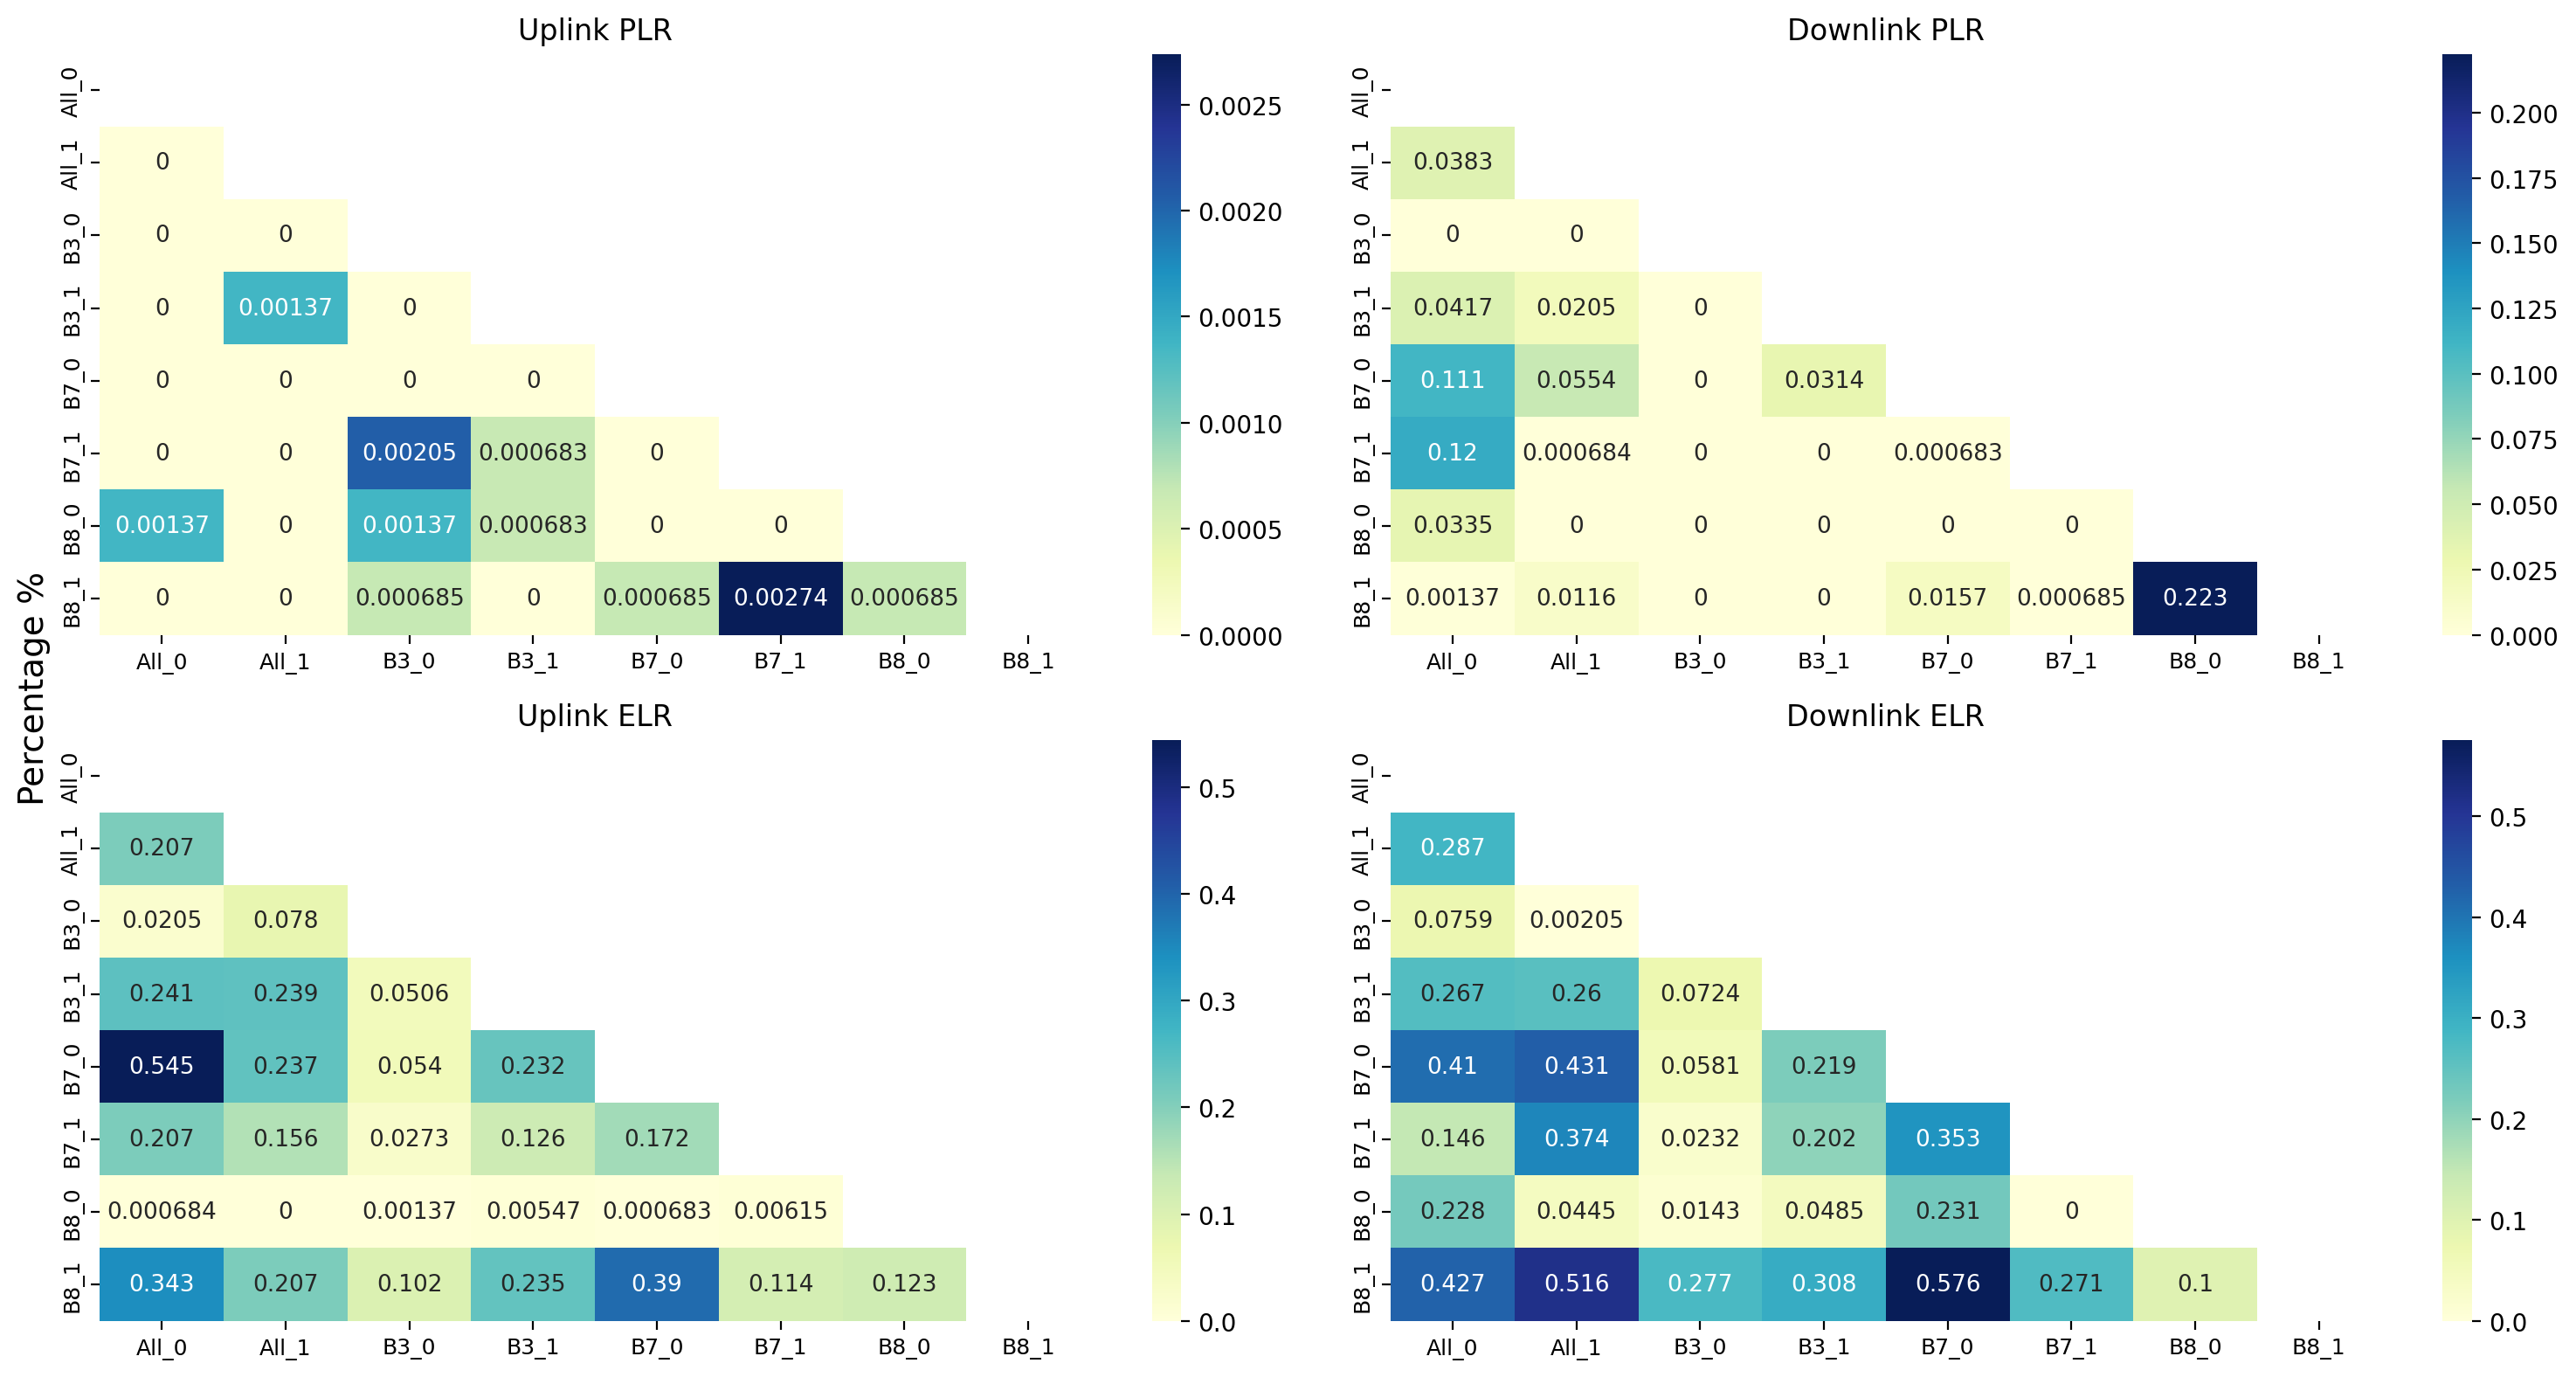

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #02


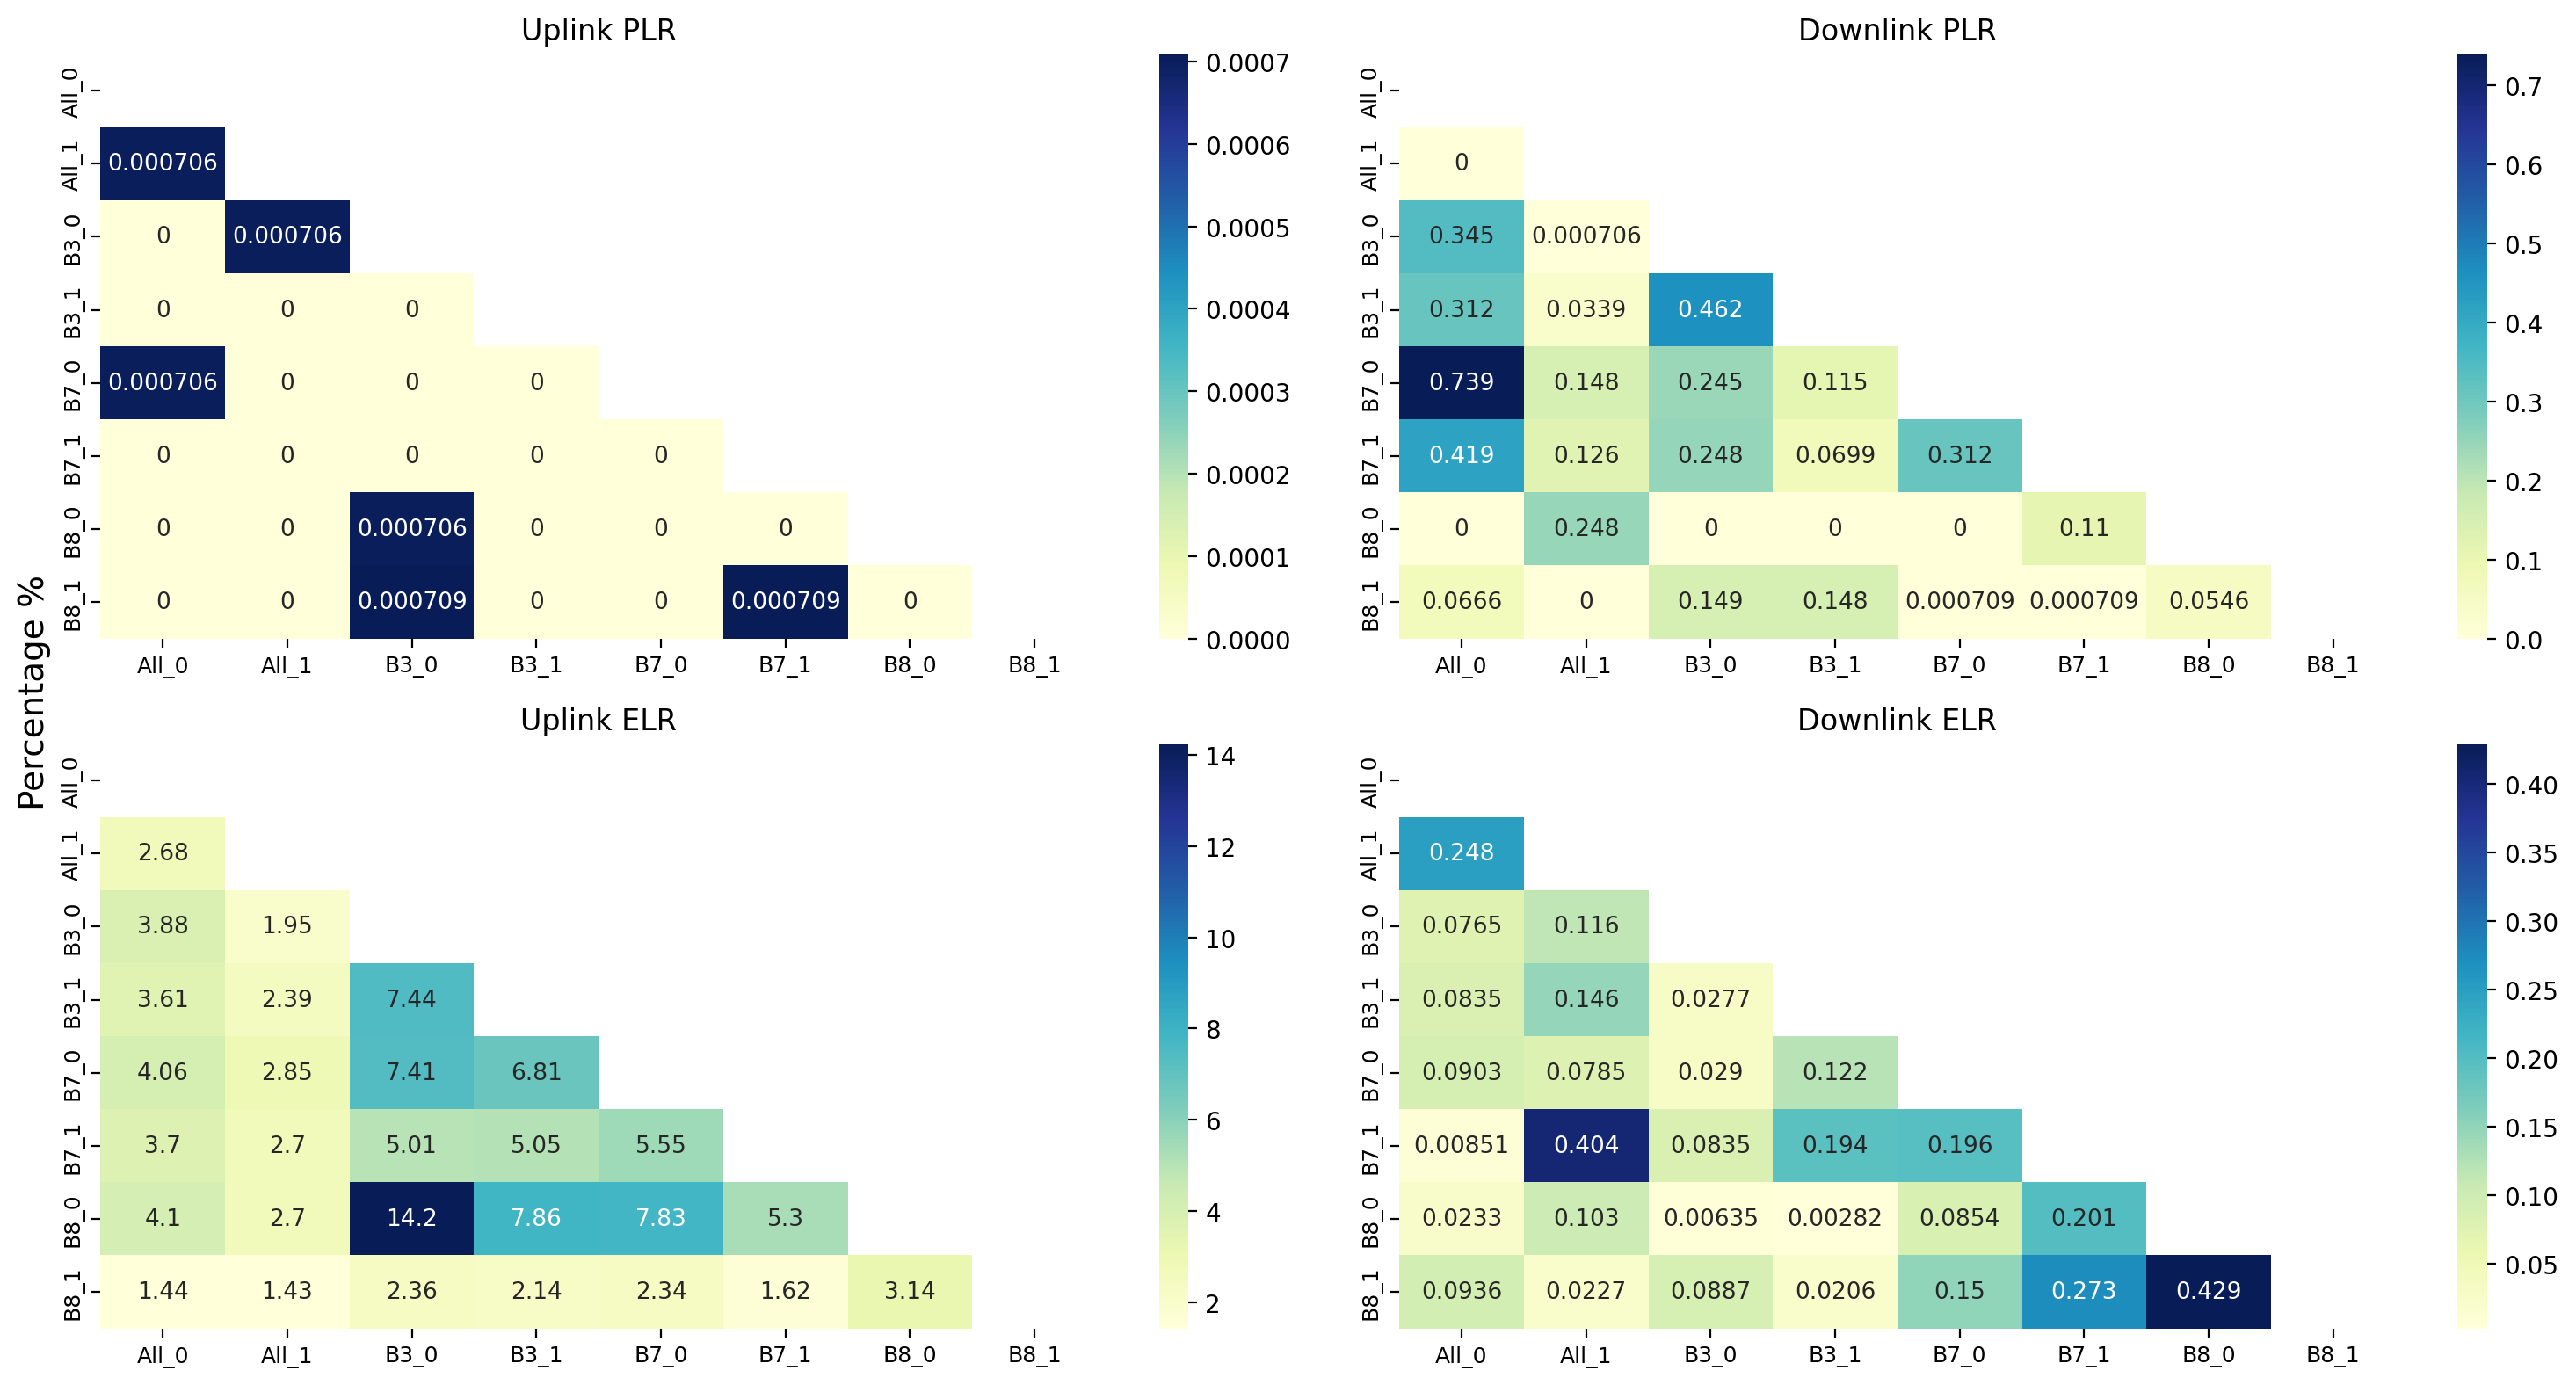

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #03


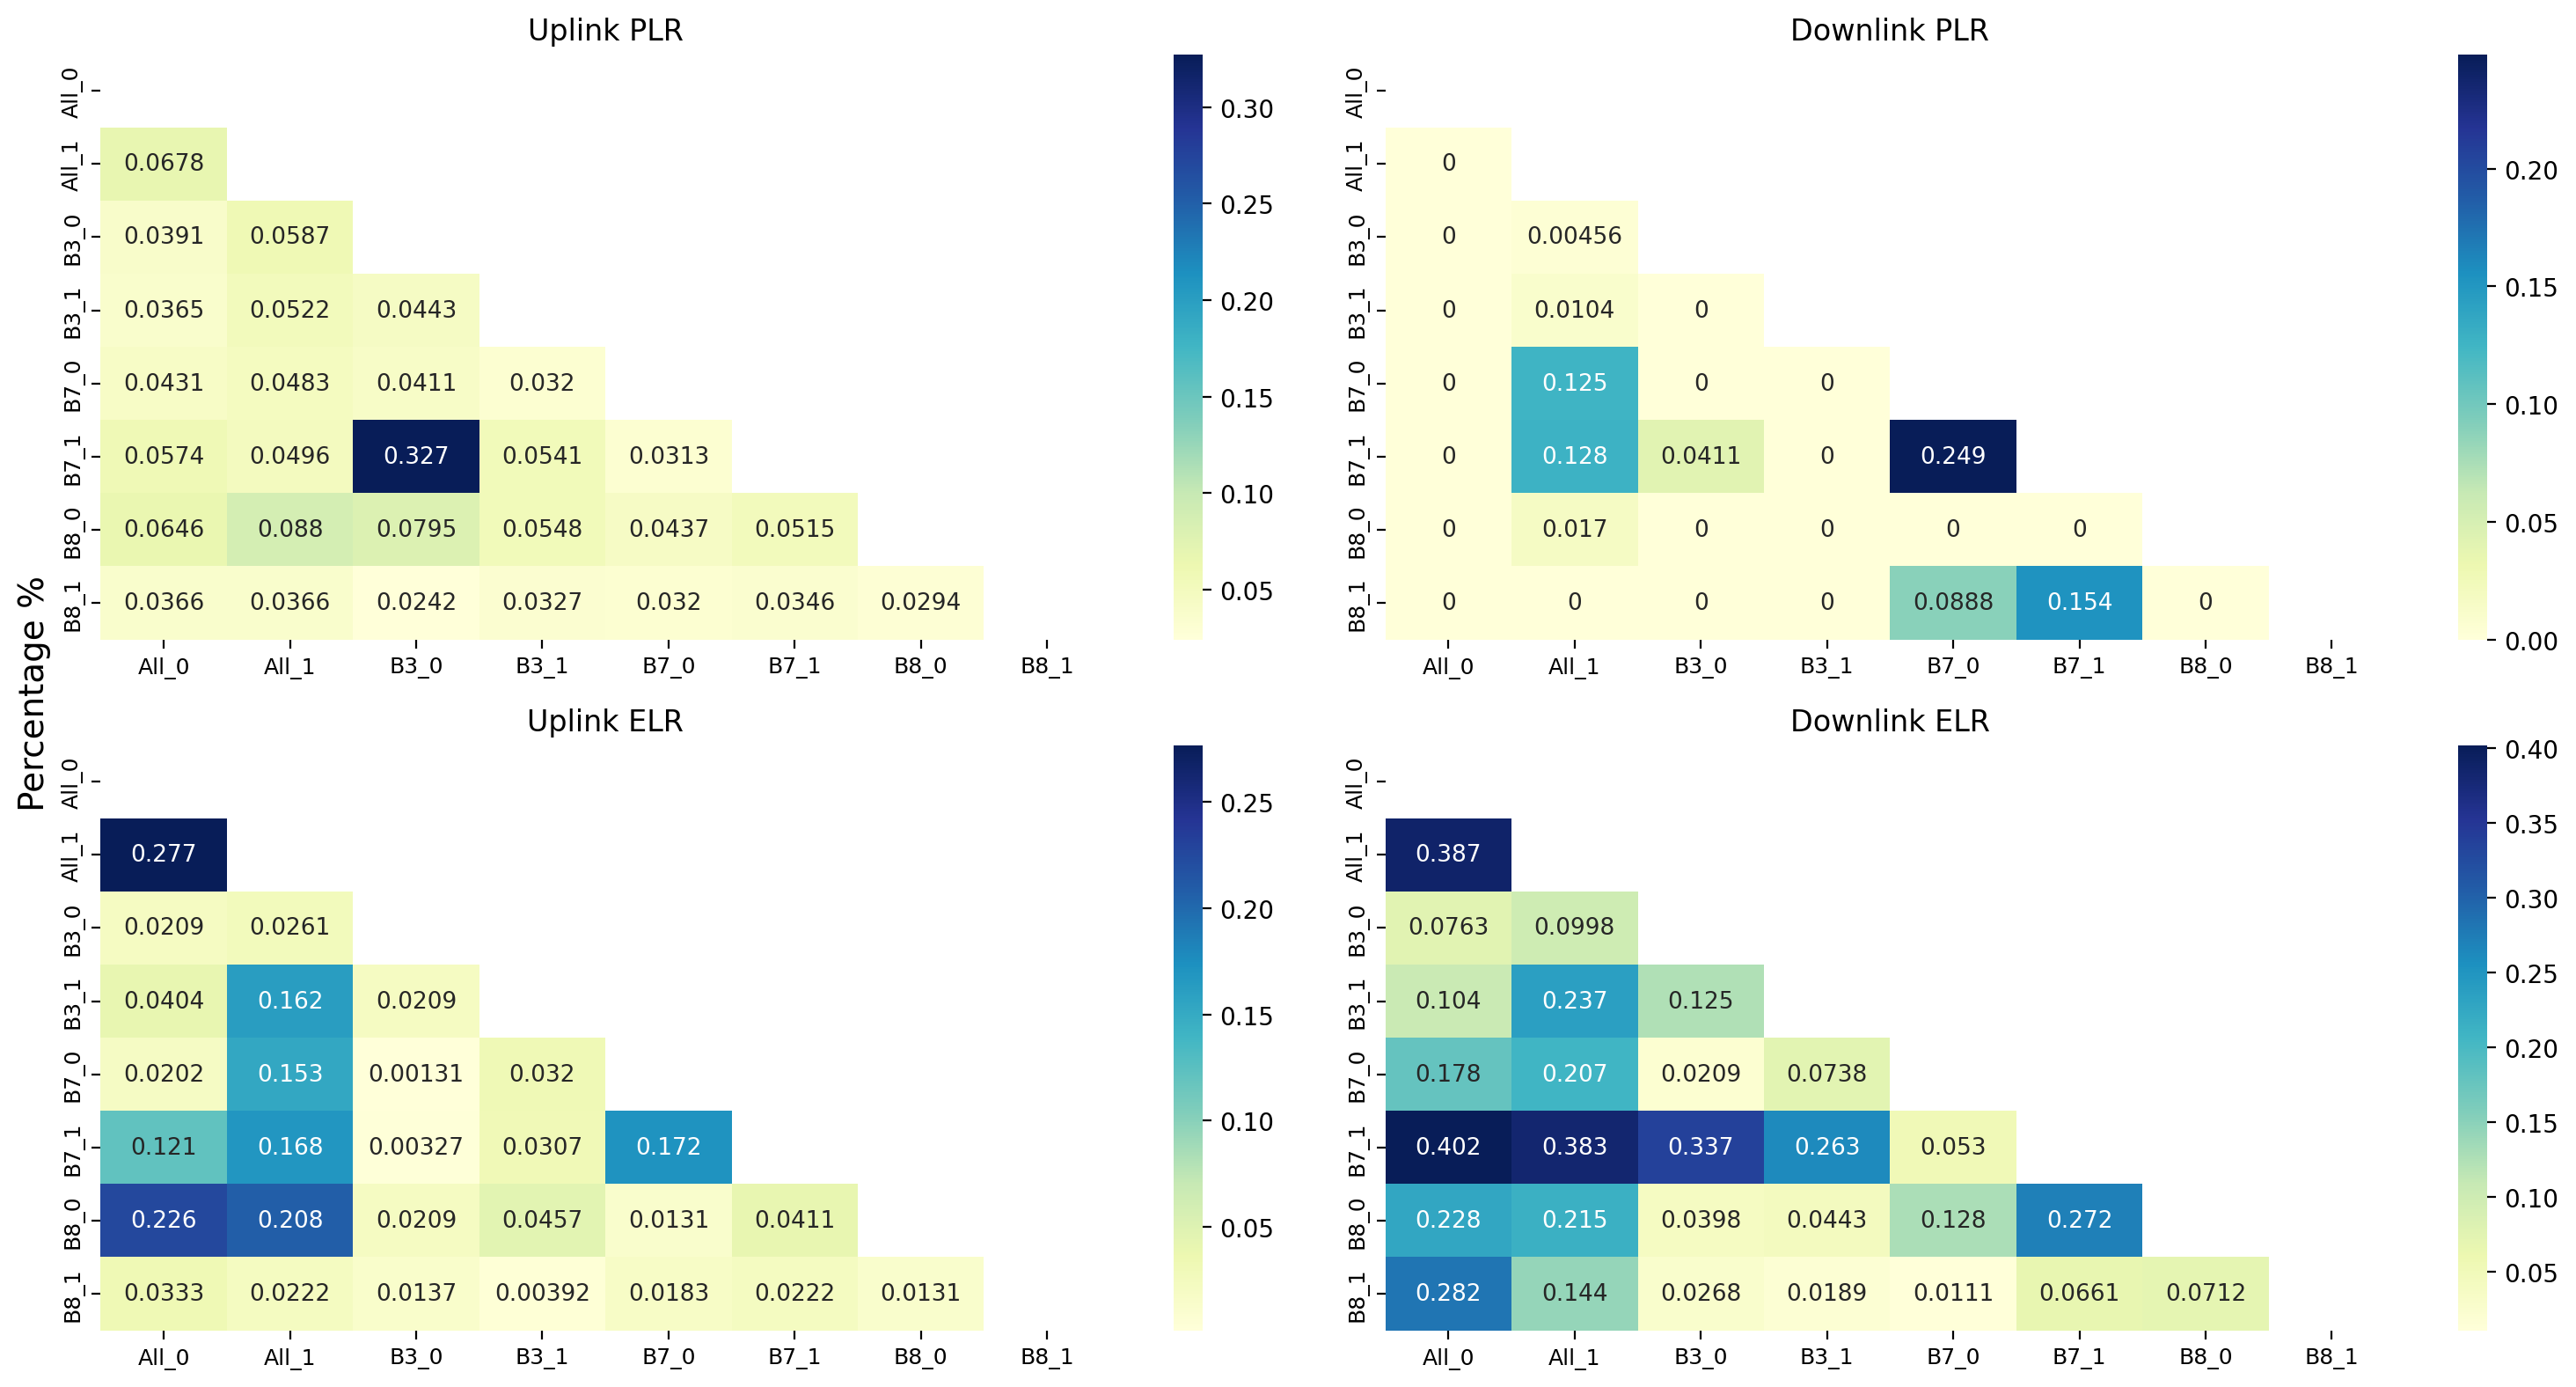

2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> #04


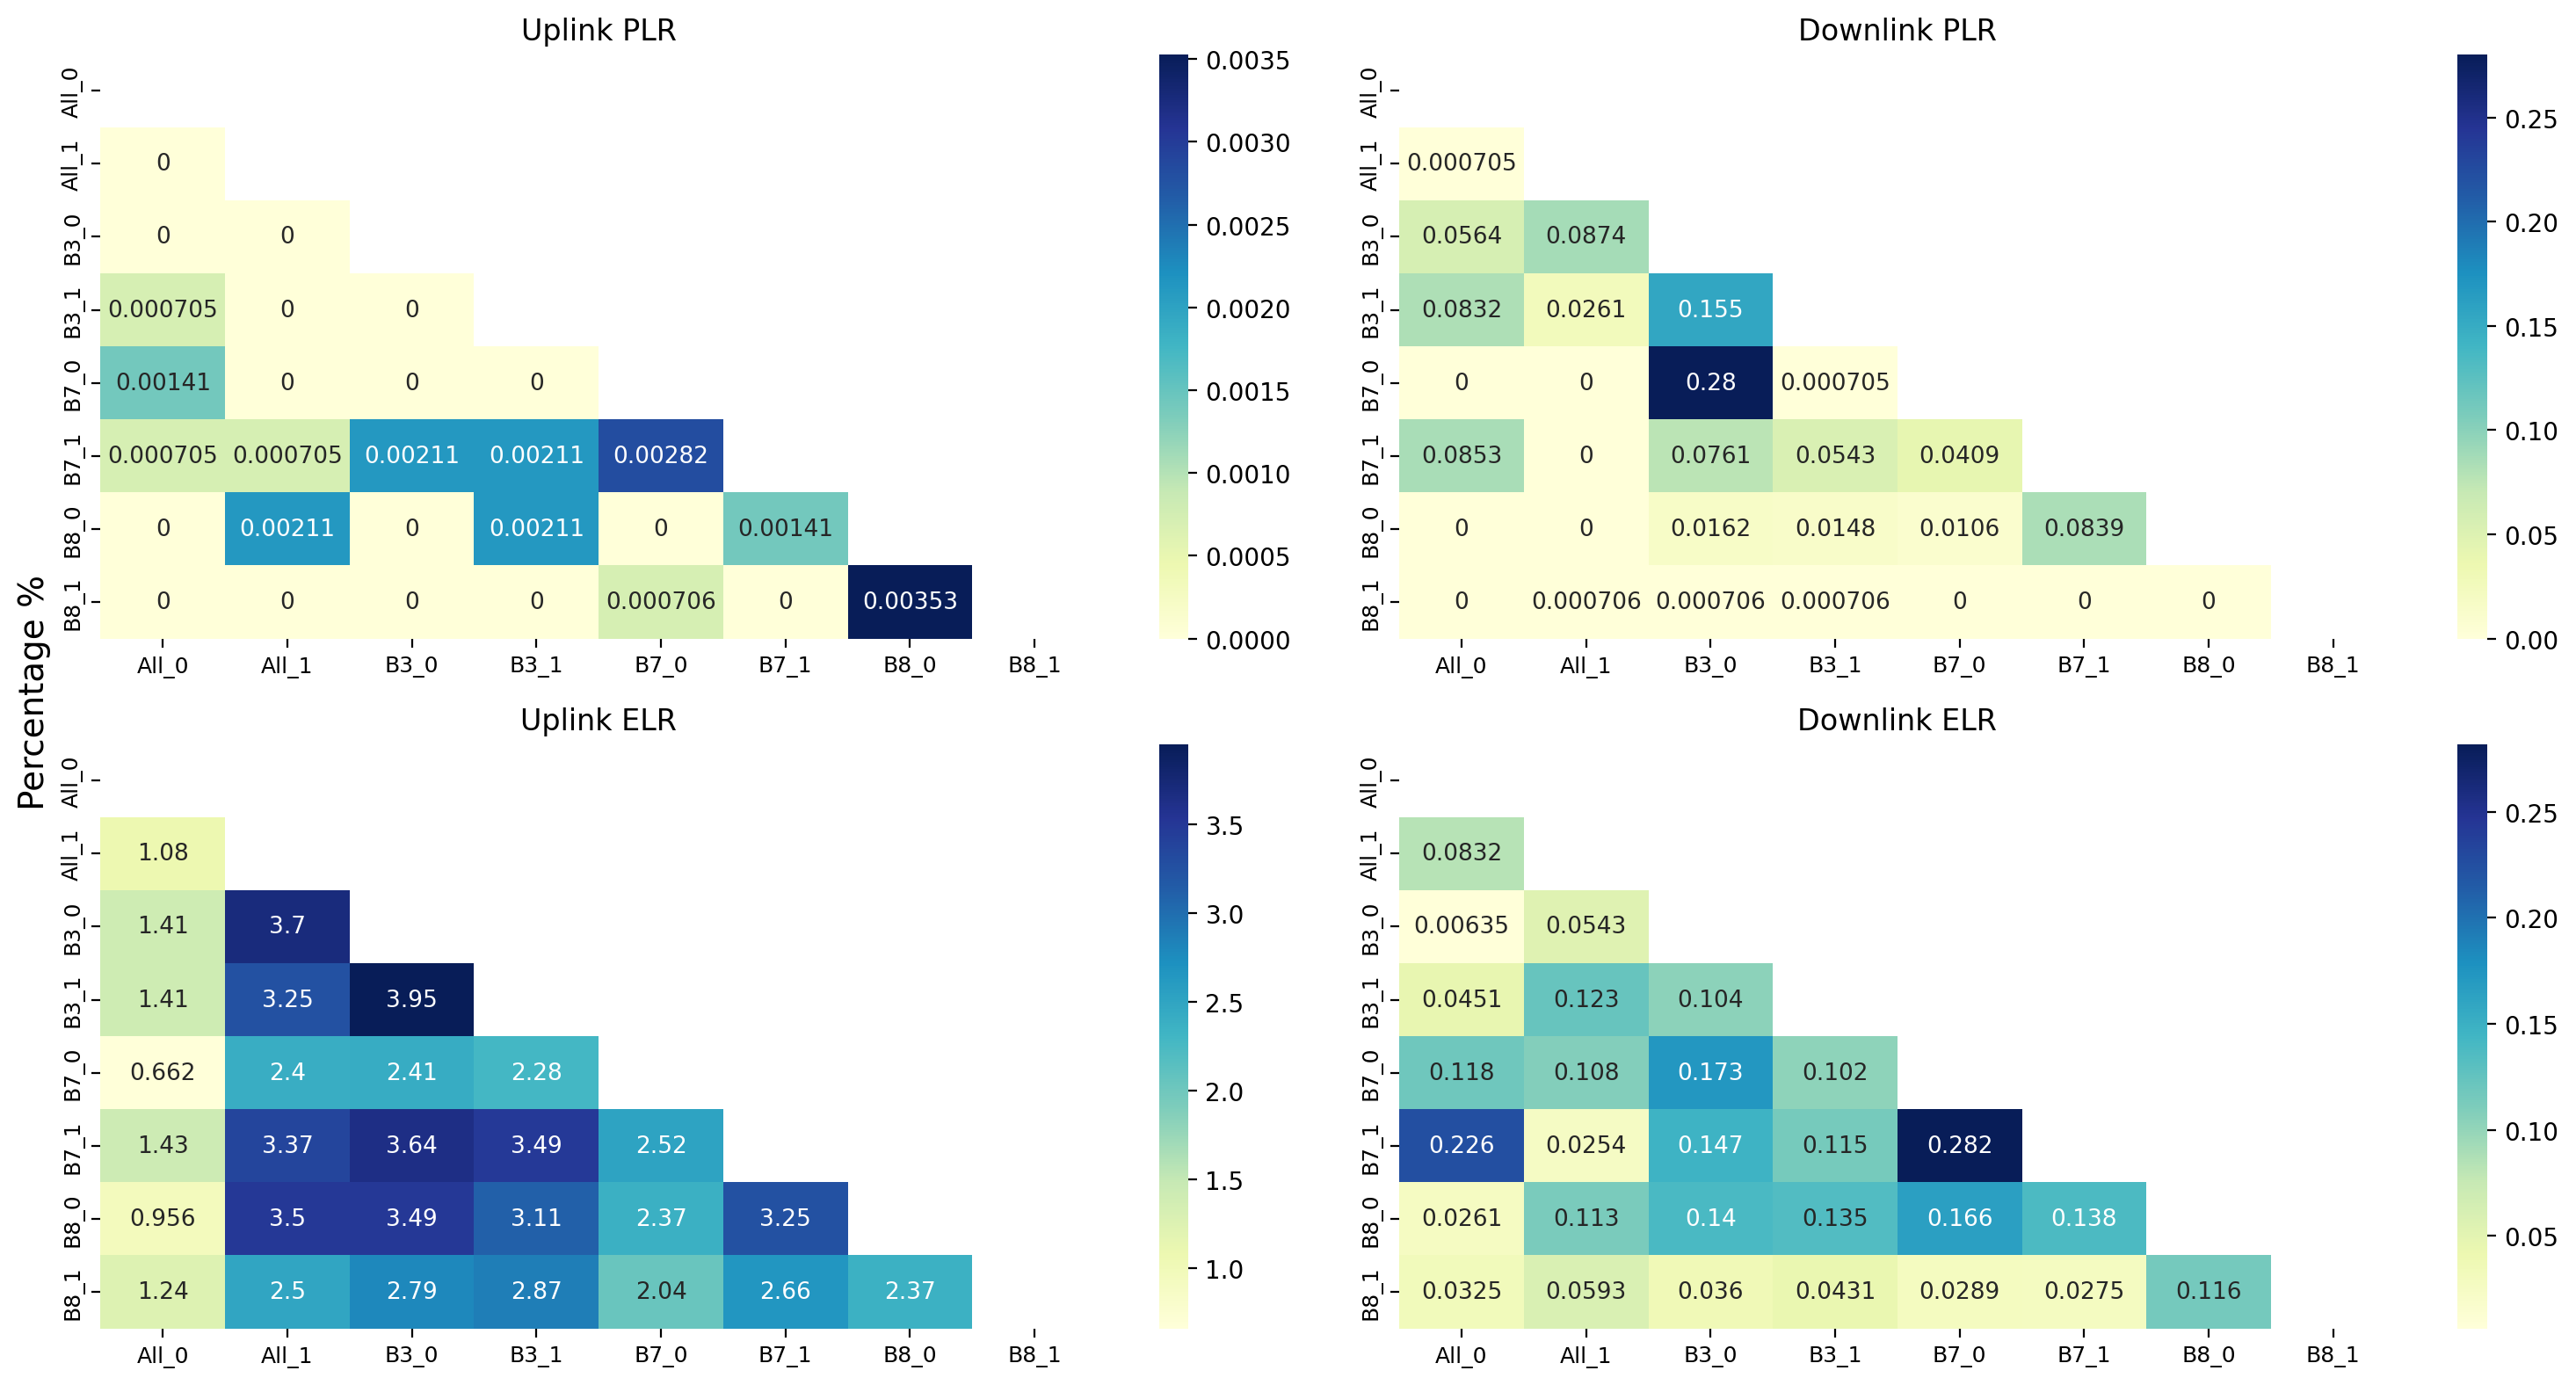

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             6   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             4   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             5   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7  #01, #02, #03, #04, #05, #06     1.072479             7   
6   sm06   B8  #01, #02, #03, #04, #05, #06     0.992900             2   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             3   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             5     0.831878   
5     2.280974             8     3.266161             6     0.730304   
6     1.036093             3     2.564579             4     0.495090   
7     1.476035             4     2.474258             3     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             4  
6             1  
7             3

Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   LTE_0+LTE_1  #01, #02, #03, #04, #05, #06     0.799353            23   
1    LTE_0+B3_0  #01, #02, #03, #04, #05, #06     0.792909             7   
2    LTE_0+B3_1  #01, #02, #03, #04, #05, #06     0.793947            11   
3    LTE_0+B7_0  #01, #02, #03, #04, #05, #06     0.792712             6   
4    LTE_0+B7_1  #01, #02, #03, #04, #05, #06     0.792925             8   
5    LTE_0+B8_0  #01, #02, #03, #04, #05, #06     0.791031             1   
6    LTE_0+B8_1  #01, #02, #03, #04, #05, #06     0.798440            22   
7    LTE_1+B3_0  #01, #02, #03, #04, #05, #06     0.795283            16   
8    LTE_1+B3_1  #01, #02, #03, #04, #05, #06     0.793711            10   
9    LTE_1+B7_0  #01, #02, #03, #04, #05, #06     0.808278            25   
10   LTE_1+B7_1  #01, #02, #03, #04, #05, #06     0.796430            19   
11   LTE_1+B8_0  #01, #02, #03, #04, #05, #06     0.796003            18   
12   LTE_1+B8_1  #01, #02, #03, #04, #05, #06     0.798366            21   
13    B3_0+B3_1  #01, #02, #03, #04, #05, #06     0.801080            24   
14    B3_0+B7_0  #01, #02, #03, #04, #05, #06     0.811982            27   
15    B3_0+B7_1  #01, #02, #03, #04, #05, #06     0.798042            20   
16    B3_0+B8_0  #01, #02, #03, #04, #05, #06     0.792419             4   
17    B3_0+B8_1  #01, #02, #03, #04, #05, #06     0.794188            13   
18    B3_1+B7_0  #01, #02, #03, #04, #05, #06     0.794039            12   
19    B3_1+B7_1  #01, #02, #03, #04, #05, #06     0.794898            15   
20    B3_1+B8_0  #01, #02, #03, #04, #05, #06     0.792515             5   
21    B3_1+B8_1  #01, #02, #03, #04, #05, #06     0.792049             3   
22    B7_0+B7_1  #01, #02, #03, #04, #05, #06     0.824537            28   
23    B7_0+B8_0  #01, #02, #03, #04, #05, #06     0.795820            17   
24    B7_0+B8_1  #01, #02, #03, #04, #05, #06     0.811029            26   
25    B7_1+B8_0  #01, #02, #03, #04, #05, #06     0.794782            14   
26    B7_1+B8_1  #01, #02, #03, #04, #05, #06     0.791179             2   
27    B8_0+B8_1  #01, #02, #03, #04, #05, #06     0.793554             9   

    avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0      0.792646             1     0.028843             3     0.294806   
1      0.792950             5     0.039773             5     0.044183   
2      0.792854             3     0.048648             6     0.046718   
3      0.798591             8     0.082327             7     0.227947   
4      0.792683             2     0.024031             2     0.192922   
5      0.792891             4     0.032729             4     0.015147   
6      0.795002             7     0.022611             1     0.068341   
7      0.875096            14     0.197426            12     0.023538   
8      0.893729            16     0.187152            11     0.014780   
9      0.900598            17     0.170452            10     0.095096   
10     0.903550            18     0.204839            13     0.134513   
11     0.794801             6     0.108931             8     0.019560   
12     0.887442            15     0.131847             9     0.020412   
13     1.086348            27     2.813977            28     0.135948   
14     0.998914            21     1.823793            23     0.291474   
15     0.979449            19     2.039648            24     0.073756   
16     0.815163            10     2.087060            25     0.086485   
17     1.036675            24     1.556509            20     0.062557   
18     0.982675            20     1.546468            18     0.118466   
19     1.015215            22     2.187086            27     0.084308   
20     0.819588            12     2.112702            26     0.122067   
21     1.024718            23     1.689115            21     0.107599   
22     1.169328            28     1.528424            17     0.080726   
23     0.809010             9     1.368674            

Uplink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       5.0   3.0  6.0  8.0  4.0  7.0  1.0  2.0
#02       2.0   1.0  3.0  6.0  8.0  5.0  4.0  7.0
#03       1.0   2.0  7.0  3.0  5.0  4.0  6.0  8.0
#04       1.0   7.0  4.0  3.0  8.0  6.0  2.0  5.0
#05       2.0   4.0  7.0  6.0  8.0  5.0  3.0  1.0
#06       2.0   1.0  3.0  7.0  4.0  8.0  5.0  6.0
Score     7.0   4.0 -2.0 -3.0 -6.0 -3.0  3.0  0.0
Ranking   1.0   2.0  5.0  6.0  8.0  7.0  3.0  4.0

LTE_0+LTE_1  LTE_0+B3_0  LTE_0+B3_1  LTE_0+B7_0  LTE_0+B7_1  \
#01             22.0        25.0        16.0        14.0         8.0   
#02              1.0         2.0         3.0         4.0         5.0   
#03              1.0         2.0         3.0         4.0         5.0   
#04             21.0         1.0        10.0         7.0        14.0   
#05             16.0         8.0        10.0         7.0        11.0   
#06              1.0         2.0         3.0         4.0         5.0   
Score            9.0         9.0         3.0         0.0         0.0   
Ranking          1.0         2.0         3.0         8.0         9.0   

         LTE_0+B8_0  LTE_0+B8_1  LTE_1+B3_0  LTE_1+B3_1  LTE_1+B7_0  \
#01            13.0        10.0        26.0        17.0        28.0   
#02             6.0         7.0        23.0         8.0         9.0   
#03             6.0         7.0         8.0         9.0        10.0   
#04             5.0         8.0        16.0        22.0        25.0   
#05             5.0        27.0         3.0         1.0         6.0   
#06             6.0         7.0         8.0         9.0        10.0   
Score           0.0        -1.0        -1.0         3.0        -3.0   
Ranking        10.0        18.0        19.0         4.0        23.0   

         LTE_1+B7_1  LTE_1+B8_0  LTE_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            20.0        18.0        15.0       27.0       23.0       21.0   
#02            10.0        11.0        12.0       13.0       24.0       14.0   
#03            11.0        12.0        13.0       14.0       15.0       28.0   
#04            23.0        24.0        19.0        2.0       27.0        6.0   
#05             4.0         2.0        25.0       28.0       26.0       24.0   
#06            11.0        12.0        13.0       28.0       14.0       15.0   
Score           0.0         2.0         0.0       -5.0       -3.0       -3.0   
Ranking        11.0         5.0        12.0       27.0       24.0       25.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            1.0       11.0        7.0        6.0        4.0       12.0   
#02           26.0       15.0       16.0       17.0       18.0       19.0   
#03           16.0       17.0       18.0       19.0       20.0       21.0   
#04           11.0       13.0       17.0       15.0        9.0        3.0   
#05           22.0       17.0       15.0       23.0       19.0       13.0   
#06           16.0       27.0       17.0       18.0       25.0       19.0   
Score          1.0       -1.0        0.0        0.0        0.0        1.0   
Ranking        6.0       20.0       13.0       14.0       15.0        7.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           24.0        9.0        5.0       19.0        2.0        3.0  
#02           25.0       27.0       28.0       20.0       21.0       22.0  
#03           22.0       23.0       24.0       25.0       26.0       27.0  
#04           28.0       18.0       26.0       12.0        4.0       20.0  
#05           12.0       20.0       21.0       14.0       18.0        9.0  
#06           20.0       21.0       22.0       23.0       26.0       24.0  
Score         -3.0       -1.0       -5.0        0.0       -2.0        0.0  
Ranking       26.0       21.0       28.0       16.0       22.0       17.0

Downlink PLR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       1.0   2.0  4.0  7.0  6.0  8.0  3.0  5.0
#02       1.0   2.0  7.0  4.0  8.0  5.0  3.0  6.0
#03       1.0   2.0  7.0  5.0  6.0  8.0  4.0  3.0
#04       1.0   5.0  4.0  6.0  7.0  8.0  2.0  3.0
#05       2.0   1.0  3.0  4.0  8.0  7.0  6.0  5.0
#06       1.0   2.0  7.0  6.0  4.0  8.0  3.0  5.0
Score    11.0   6.0 -3.0 -1.0 -5.0 -9.0  1.0  0.0
Ranking   1.0   2.0  6.0  5.0  7.0  8.0  3.0  4.0

LTE_0+LTE_1  LTE_0+B3_0  LTE_0+B3_1  LTE_0+B7_0  LTE_0+B7_1  \
#01              1.0         2.0         3.0         4.0         5.0   
#02              1.0         2.0         3.0         4.0         5.0   
#03              1.0         2.0         3.0         4.0         5.0   
#04              1.0         2.0         3.0         4.0         5.0   
#05              1.0         5.0         3.0        22.0         2.0   
#06              1.0         2.0         3.0         4.0         5.0   
Score           18.0        10.0         6.0         0.0         2.0   
Ranking          1.0         2.0         3.0         5.0         4.0   

         LTE_0+B8_0  LTE_0+B8_1  LTE_1+B3_0  LTE_1+B3_1  LTE_1+B7_0  \
#01             6.0         7.0         8.0         9.0        10.0   
#02             6.0         7.0         8.0         9.0        10.0   
#03             6.0         7.0         8.0         9.0        10.0   
#04             6.0         7.0        15.0        23.0        26.0   
#05             4.0        13.0        11.0         8.0         9.0   
#06             6.0         7.0         8.0         9.0        10.0   
Score           0.0         0.0         0.0         0.0        -2.0   
Ranking         6.0         7.0         8.0         9.0        19.0   

         LTE_1+B7_1  LTE_1+B8_0  LTE_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            11.0        12.0        13.0       25.0       14.0       22.0   
#02            11.0        12.0        13.0       27.0       28.0       14.0   
#03            11.0        12.0        13.0       24.0       25.0       28.0   
#04            27.0         8.0        19.0       24.0       16.0       25.0   
#05             6.0        10.0        17.0       23.0       14.0        7.0   
#06            11.0        12.0        13.0       25.0       17.0       23.0   
Score          -1.0         0.0         0.0       -1.0       -3.0       -3.0   
Ranking        15.0        10.0        11.0       16.0       24.0       25.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01           15.0       16.0       17.0       24.0       18.0       19.0   
#02           15.0       22.0       25.0       16.0       17.0       23.0   
#03           22.0       20.0       26.0       14.0       15.0       21.0   
#04            9.0       14.0       20.0       21.0       10.0       22.0   
#05           12.0       19.0       15.0       24.0       27.0       20.0   
#06           21.0       28.0       19.0       27.0       22.0       26.0   
Score          0.0       -3.0       -2.0       -1.0       -1.0       -2.0   
Ranking       12.0       26.0       20.0       17.0       18.0       21.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           28.0       20.0       26.0       21.0       27.0       23.0  
#02           24.0       20.0       26.0       21.0       18.0       19.0  
#03           16.0       17.0       18.0       23.0       27.0       19.0  
#04           28.0       11.0       17.0       12.0       18.0       13.0  
#05           28.0       16.0       21.0       26.0       18.0       25.0  
#06           14.0       15.0       16.0       18.0       24.0       20.0  
Score         -9.0        0.0       -4.0       -2.0       -2.0        0.0  
Ranking       28.0       13.0       27.0       22.0       23.0       14.0

Uplink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       5.0   6.0  3.0  7.0  4.0  8.0  1.0  2.0
#02       1.0   2.0  8.0  7.0  4.0  3.0  5.0  6.0
#03       1.0   2.0  7.0  5.0  8.0  6.0  4.0  3.0
#04       1.0   2.0  8.0  7.0  3.0  6.0  5.0  4.0
#05       5.0   1.0  8.0  3.0  7.0  6.0  2.0  4.0
#06       8.0   1.0  5.0  7.0  2.0  4.0  6.0  3.0
Score     4.0   7.0 -7.0 -4.0 -2.0 -2.0  3.0  1.0
Ranking   2.0   1.0  8.0  7.0  5.0  6.0  3.0  4.0

LTE_0+LTE_1  LTE_0+B3_0  LTE_0+B3_1  LTE_0+B7_0  LTE_0+B7_1  \
#01             24.0        22.0        23.0        20.0        15.0   
#02              1.0         2.0         7.0         3.0         4.0   
#03              1.0         2.0        15.0        10.0        11.0   
#04              3.0         7.0         5.0         6.0         2.0   
#05              1.0        13.0         2.0        28.0        16.0   
#06             11.0         5.0        12.0         2.0         3.0   
Score           10.0         4.0         2.0         0.0         3.0   
Ranking          1.0         2.0         6.0        10.0         4.0   

         LTE_0+B8_0  LTE_0+B8_1  LTE_1+B3_0  LTE_1+B3_1  LTE_1+B7_0  \
#01             3.0        10.0        16.0        11.0        21.0   
#02             6.0         5.0        11.0        13.0         9.0   
#03             7.0        13.0         4.0         6.0        16.0   
#04             4.0         1.0        13.0        12.0        10.0   
#05             5.0         6.0         4.0         8.0         3.0   
#06             9.0         4.0        13.0         7.0         1.0   
Score           1.0         3.0         0.0         0.0         4.0   
Ranking         8.0         5.0        11.0        12.0         3.0   

         LTE_1+B7_1  LTE_1+B8_0  LTE_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            19.0        17.0        13.0       27.0       14.0        8.0   
#02             8.0        10.0        12.0       28.0       24.0       19.0   
#03            21.0         5.0         3.0        9.0       28.0       25.0   
#04            11.0         8.0         9.0       28.0       16.0       26.0   
#05             9.0        14.0         7.0       27.0       18.0       25.0   
#06             6.0         8.0        10.0       26.0       14.0       21.0   
Score           0.0         0.0         1.0      -10.0       -3.0       -2.0   
Ranking        13.0        14.0         9.0       28.0       23.0       22.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            1.0       18.0        9.0        6.0        7.0       12.0   
#02           26.0       16.0       25.0       21.0       27.0       18.0   
#03            8.0       23.0       20.0       27.0       12.0       17.0   
#04           22.0       23.0       18.0       27.0       21.0       24.0   
#05           19.0       11.0       21.0       26.0       10.0       12.0   
#06           27.0       18.0       19.0       23.0       28.0       24.0   
Score          0.0        0.0        0.0       -4.0       -4.0        0.0   
Ranking       15.0       16.0       17.0       25.0       26.0       18.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           26.0        2.0       25.0        5.0       28.0        4.0  
#02           22.0       23.0       15.0       20.0       14.0       17.0  
#03           26.0       19.0       24.0       18.0       14.0       22.0  
#04           17.0       14.0       15.0       20.0       25.0       19.0  
#05           24.0       17.0       22.0       20.0       23.0       15.0  
#06           16.0       17.0       15.0       25.0       20.0       22.0  
Score         -4.0        2.0        0.0        0.0       -3.0        0.0  
Ranking       27.0        7.0       19.0       20.0       24.0       21.0

Downlink ELR Ranking:


sm00  sm01 sm02 sm03 sm04 sm05 sm06 sm07
        LTE_0 LTE_1 B3_0 B3_1 B7_0 B7_1 B8_0 B8_1
#01       8.0   7.0  5.0  1.0  3.0  6.0  2.0  4.0
#02       7.0   8.0  1.0  4.0  5.0  6.0  2.0  3.0
#03       2.0   6.0  8.0  1.0  7.0  3.0  5.0  4.0
#04       2.0   8.0  7.0  6.0  4.0  3.0  1.0  5.0
#05       8.0   1.0  4.0  5.0  7.0  6.0  2.0  3.0
#06       4.0   2.0  3.0  5.0  7.0  1.0  6.0  8.0
Score    -3.0  -2.0 -1.0  4.0 -3.0  2.0  5.0 -2.0
Ranking   7.0   5.0  4.0  2.0  8.0  3.0  1.0  6.0

LTE_0+LTE_1  LTE_0+B3_0  LTE_0+B3_1  LTE_0+B7_0  LTE_0+B7_1  \
#01             25.0         9.0         1.0        28.0        27.0   
#02             28.0         4.0         8.0        15.0        27.0   
#03              1.0        26.0         4.0         8.0         6.0   
#04             27.0         5.0        12.0        22.0        16.0   
#05              8.0         7.0        21.0        28.0        24.0   
#06             21.0         8.0        13.0         1.0         2.0   
Score           -1.0        -2.0         3.0        -3.0         0.0   
Ranking         19.0        20.0         4.0        24.0        11.0   

         LTE_0+B8_0  LTE_0+B8_1  LTE_1+B3_0  LTE_1+B3_1  LTE_1+B7_0  \
#01             8.0        26.0        12.0         2.0        23.0   
#02             6.0         7.0         1.0         5.0        14.0   
#03             7.0         9.0        10.0         2.0        16.0   
#04             1.0        13.0        17.0        15.0        28.0   
#05            10.0         9.0         2.0         6.0         1.0   
#06            10.0         6.0        11.0         7.0         3.0   
Score           3.0        -2.0         5.0         4.0         1.0   
Ranking         5.0        21.0         1.0         2.0         7.0   

         LTE_1+B7_1  LTE_1+B8_0  LTE_1+B8_1  B3_0+B3_1  B3_0+B7_0  B3_0+B7_1  \
#01            22.0         3.0        11.0       10.0       24.0       18.0   
#02            26.0         2.0        12.0       10.0       19.0        3.0   
#03            24.0        18.0         5.0       13.0       28.0       15.0   
#04            19.0         4.0        11.0       26.0       23.0        7.0   
#05             5.0         3.0         4.0       27.0       14.0       20.0   
#06             4.0         5.0         9.0       23.0       27.0       19.0   
Score          -2.0         4.0         0.0       -3.0       -4.0        1.0   
Ranking        22.0         3.0        12.0       25.0       28.0        8.0   

         B3_0+B8_0  B3_0+B8_1  B3_1+B7_0  B3_1+B7_1  B3_1+B8_0  B3_1+B8_1  \
#01            4.0       15.0       17.0       13.0       21.0        5.0   
#02           17.0        9.0       23.0       11.0       16.0       18.0   
#03           21.0       17.0       19.0       11.0        3.0       14.0   
#04            9.0       21.0       14.0       20.0       25.0       24.0   
#05           18.0       11.0       13.0       26.0       22.0       25.0   
#06           18.0       15.0       28.0       16.0       24.0       14.0   
Score          0.0        0.0       -3.0       -2.0        1.0        0.0   
Ranking       13.0       14.0       26.0       23.0        9.0       15.0   

         B7_0+B7_1  B7_0+B8_0  B7_0+B8_1  B7_1+B8_0  B7_1+B8_1  B8_0+B8_1  
#01           20.0        6.0       16.0        7.0       19.0       14.0  
#02           13.0       21.0       25.0       20.0       22.0       24.0  
#03           20.0       27.0       25.0       22.0       12.0       23.0  
#04            3.0       18.0        6.0       10.0        8.0        2.0  
#05           23.0       12.0       16.0       15.0       17.0       19.0  
#06           12.0       26.0       22.0       17.0       20.0       25.0  
Score          1.0       -3.0        0.0        0.0        0.0        2.0  
Ranking       10.0       27.0       16.0       17.0       18.0        6.0

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #01


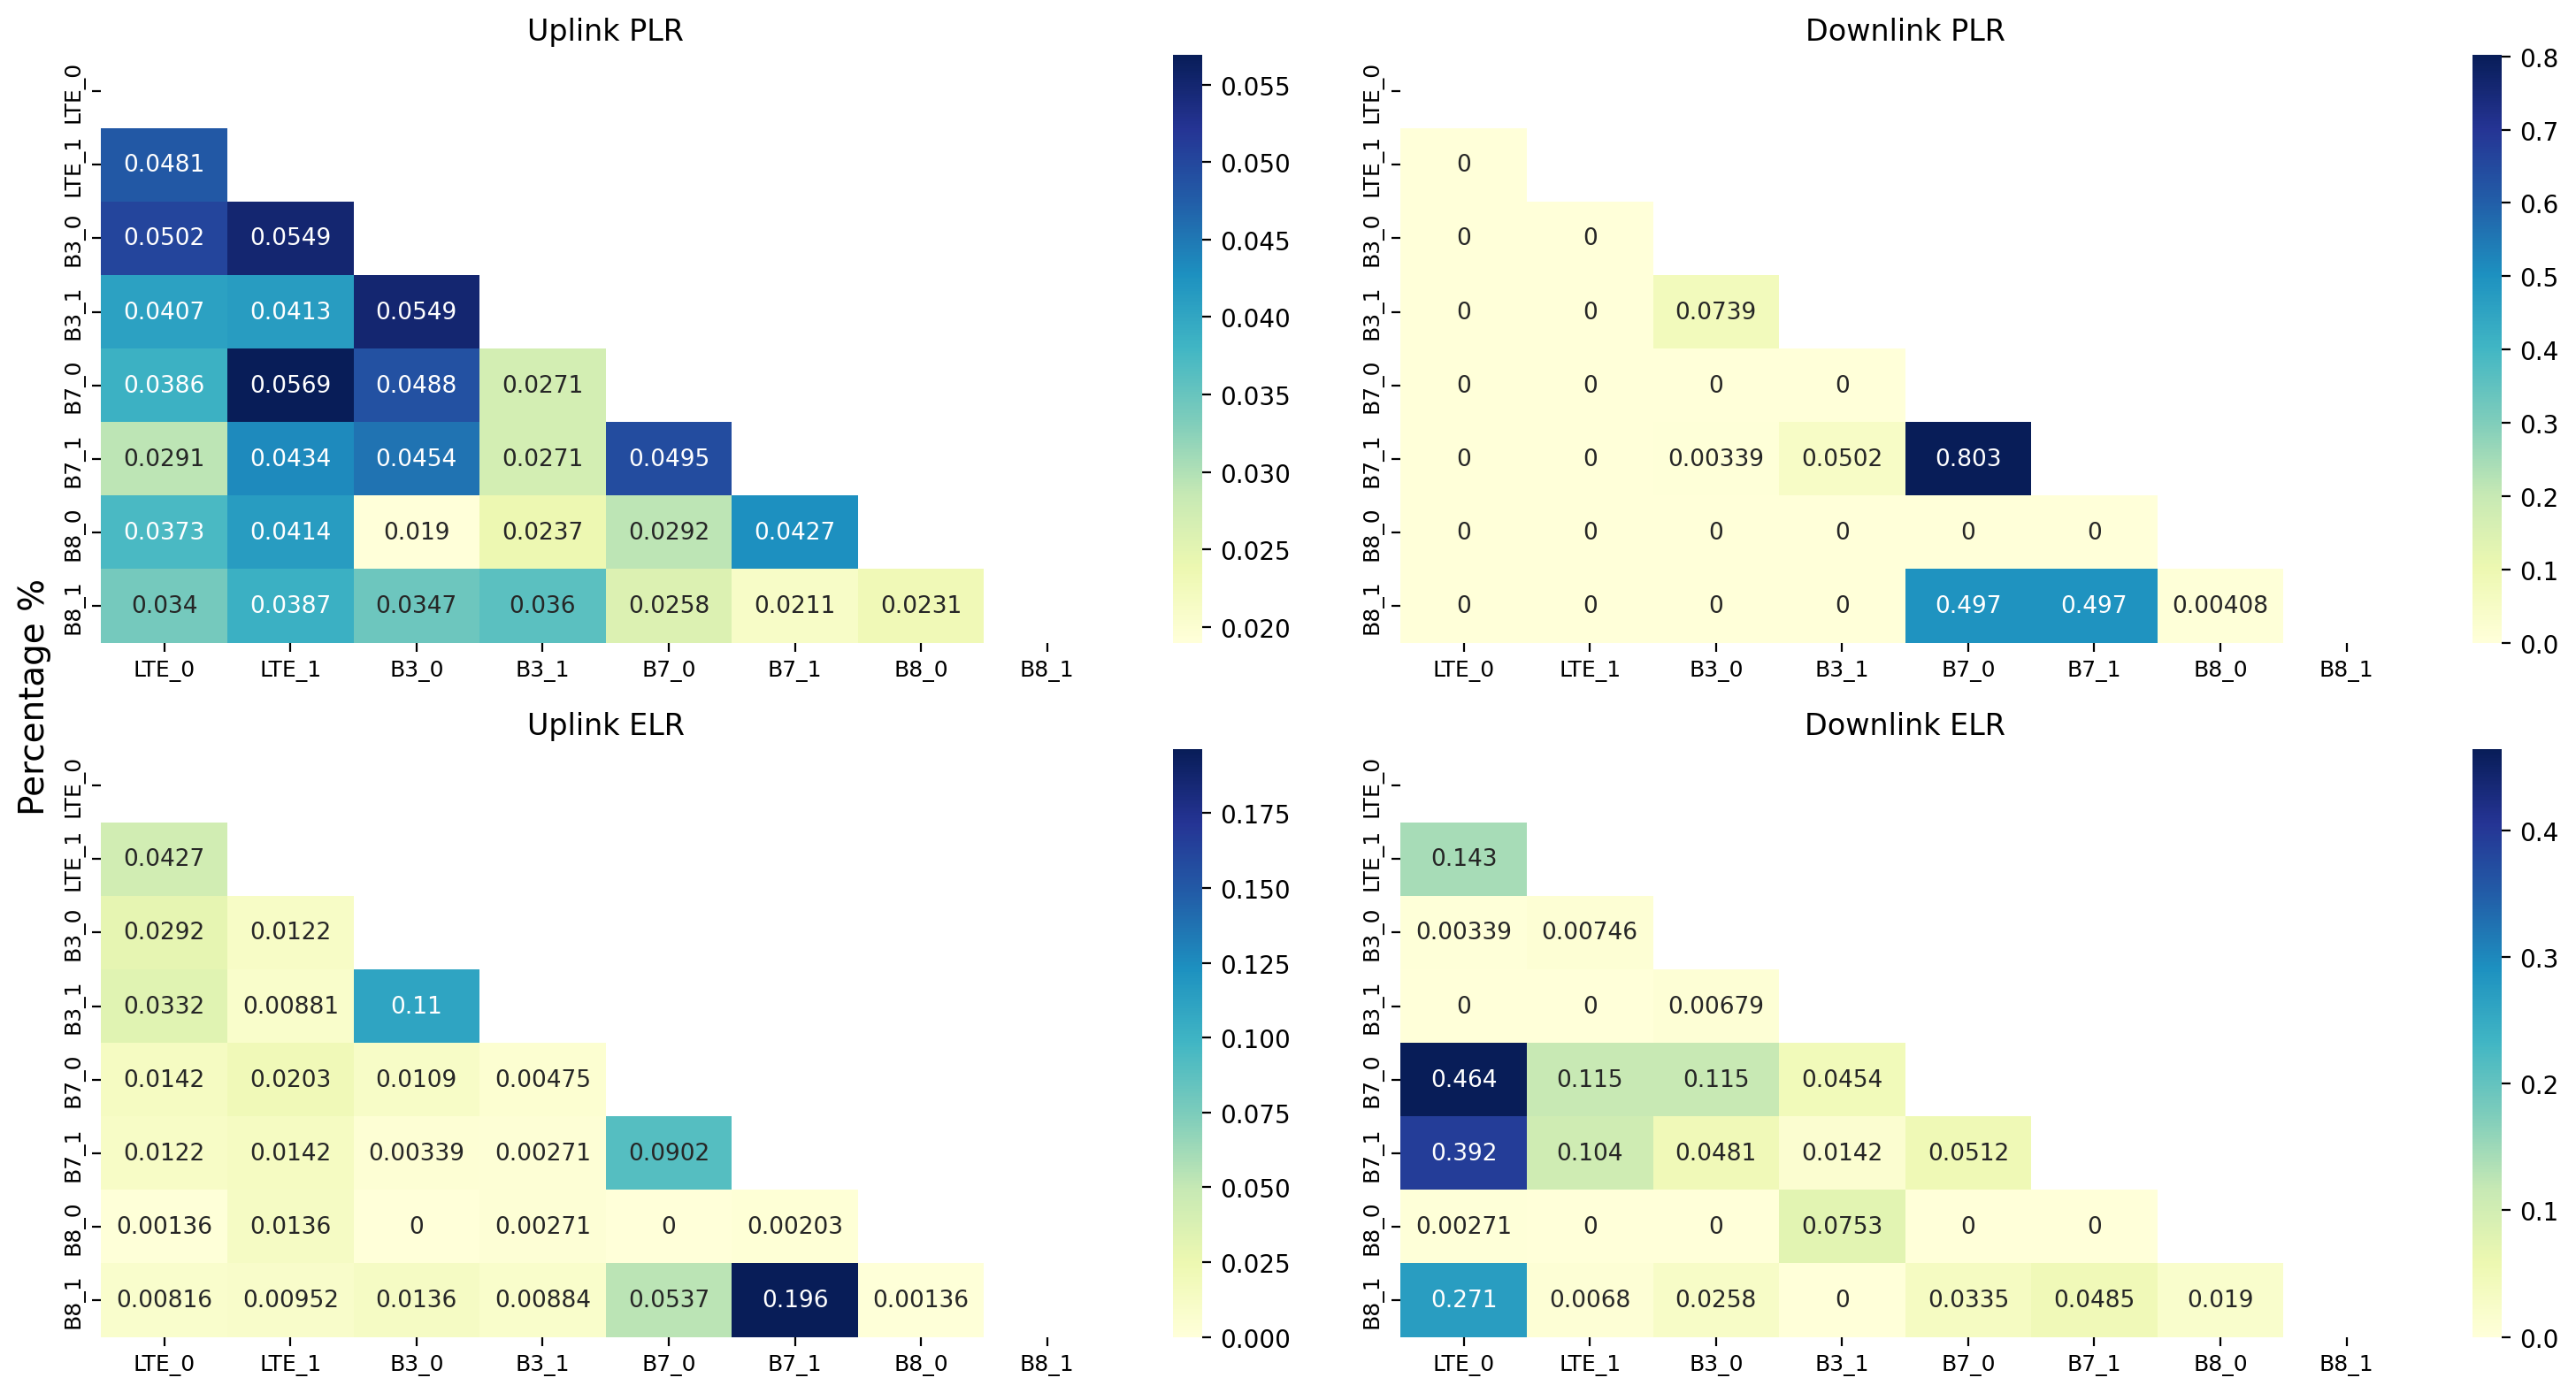

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #02


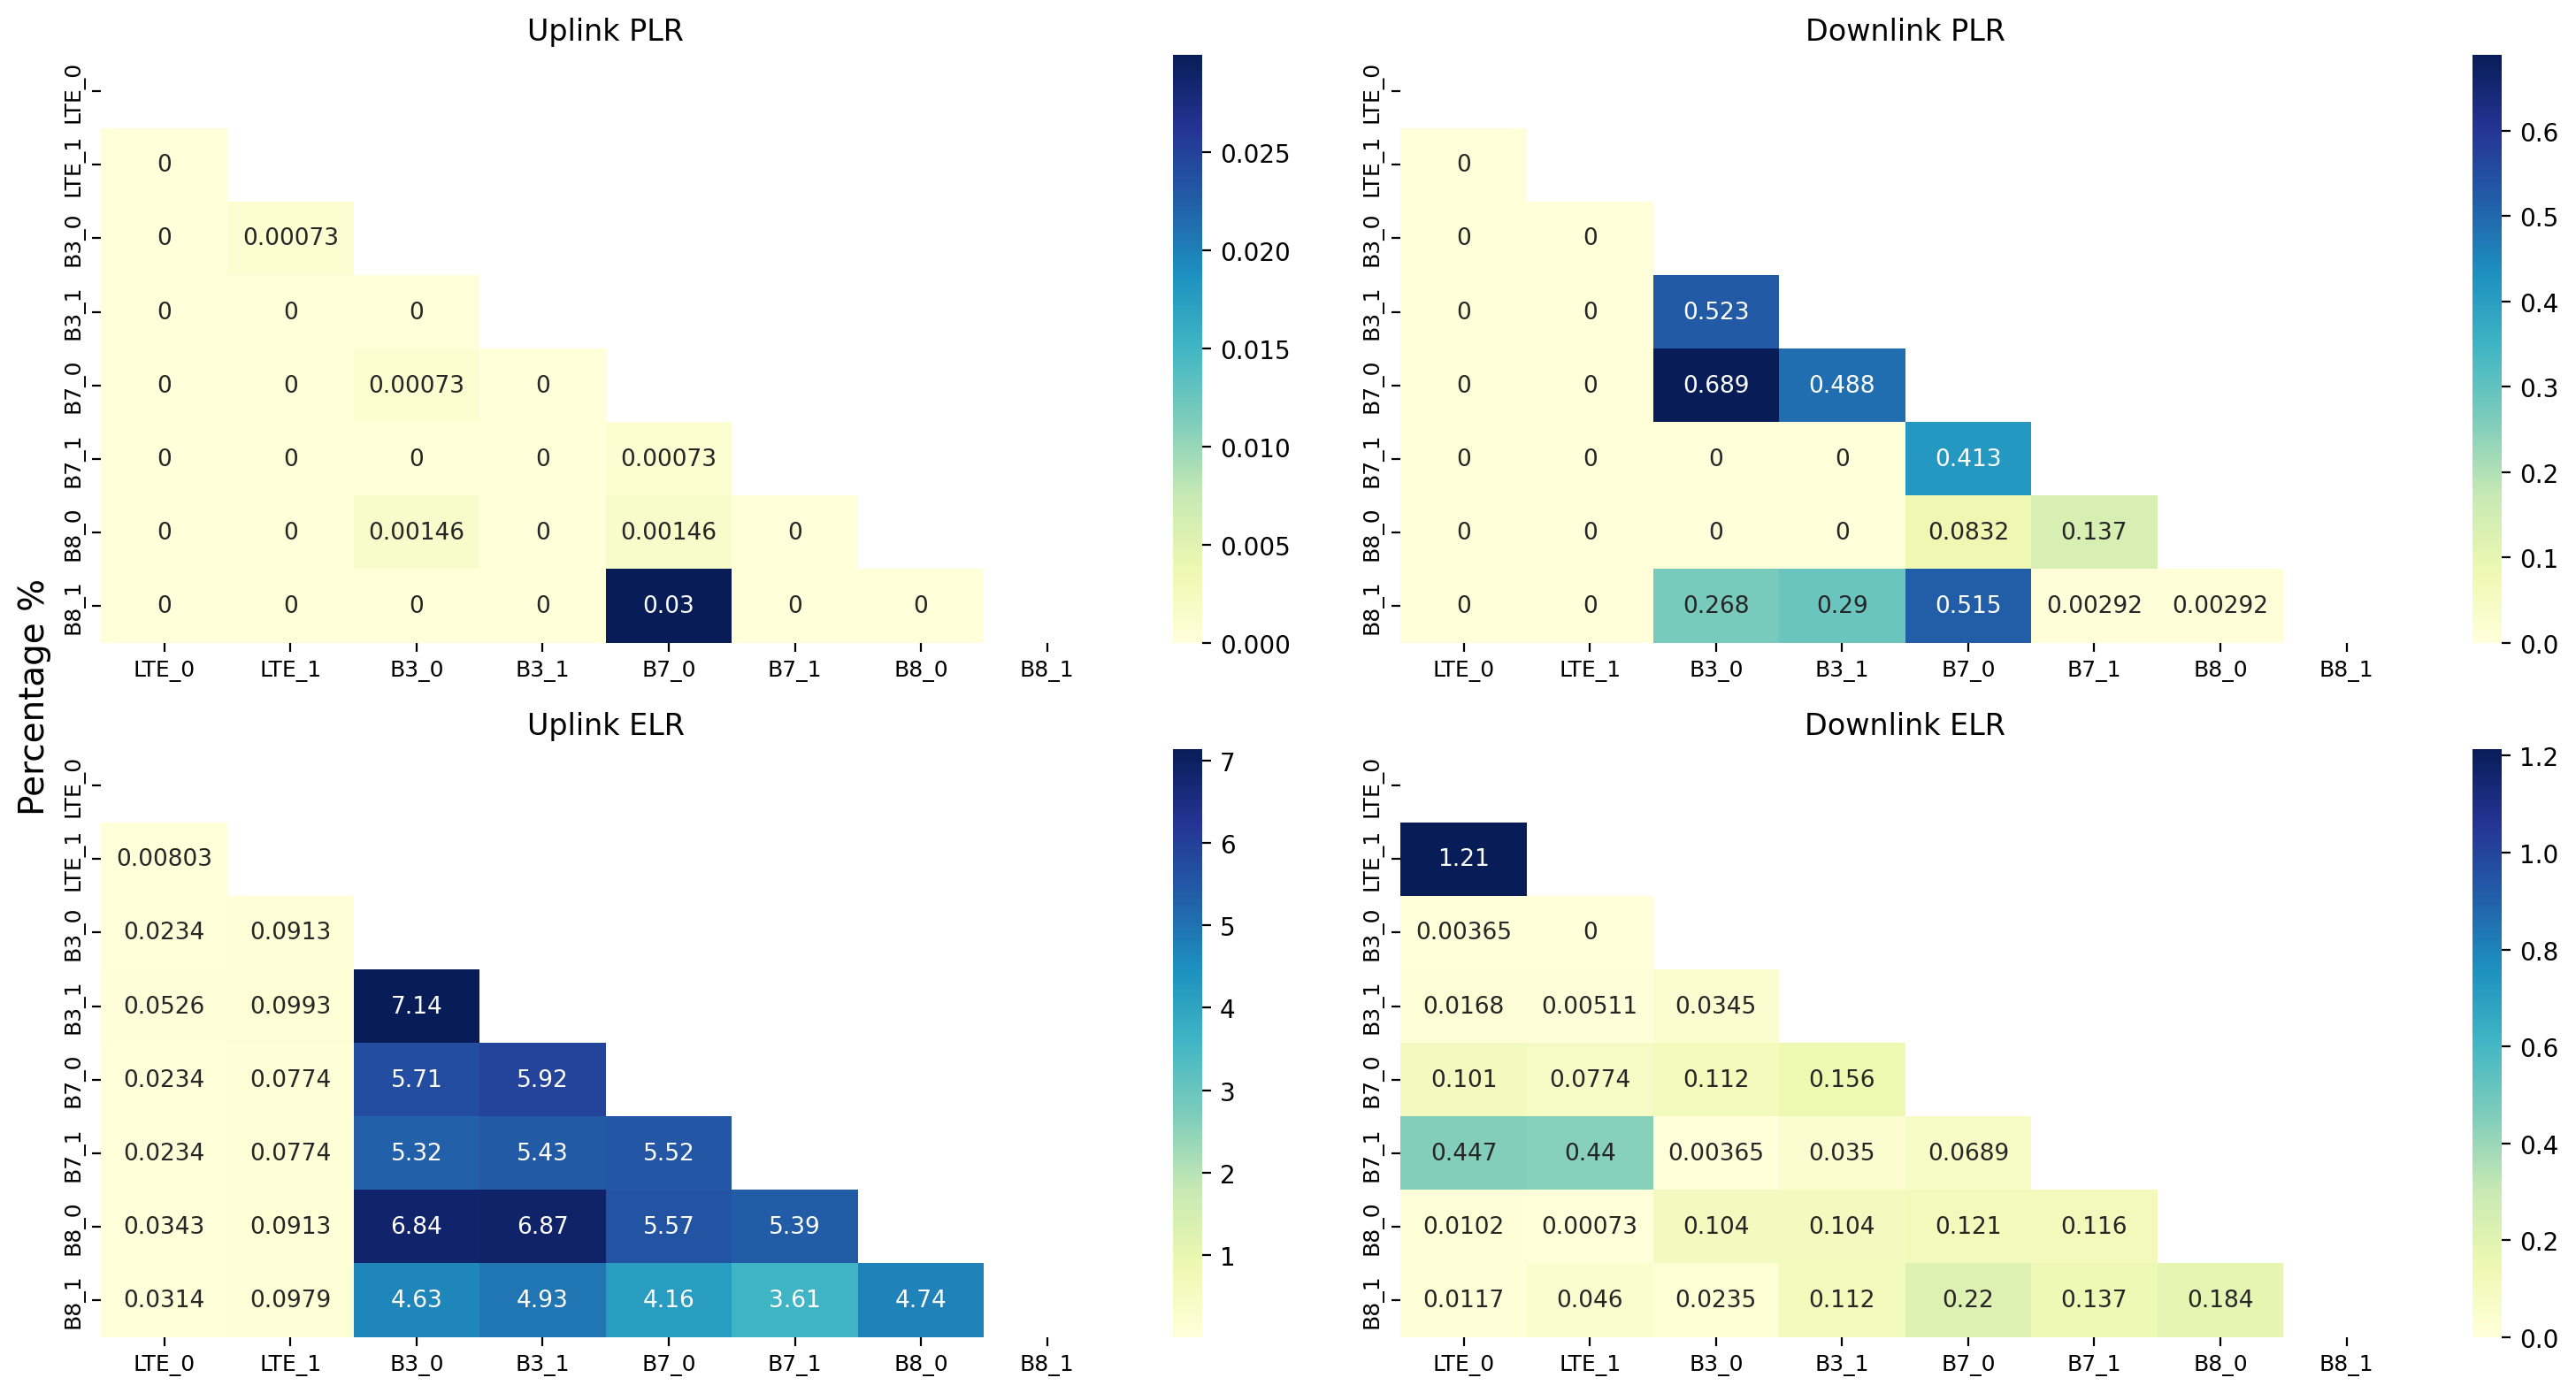

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #03


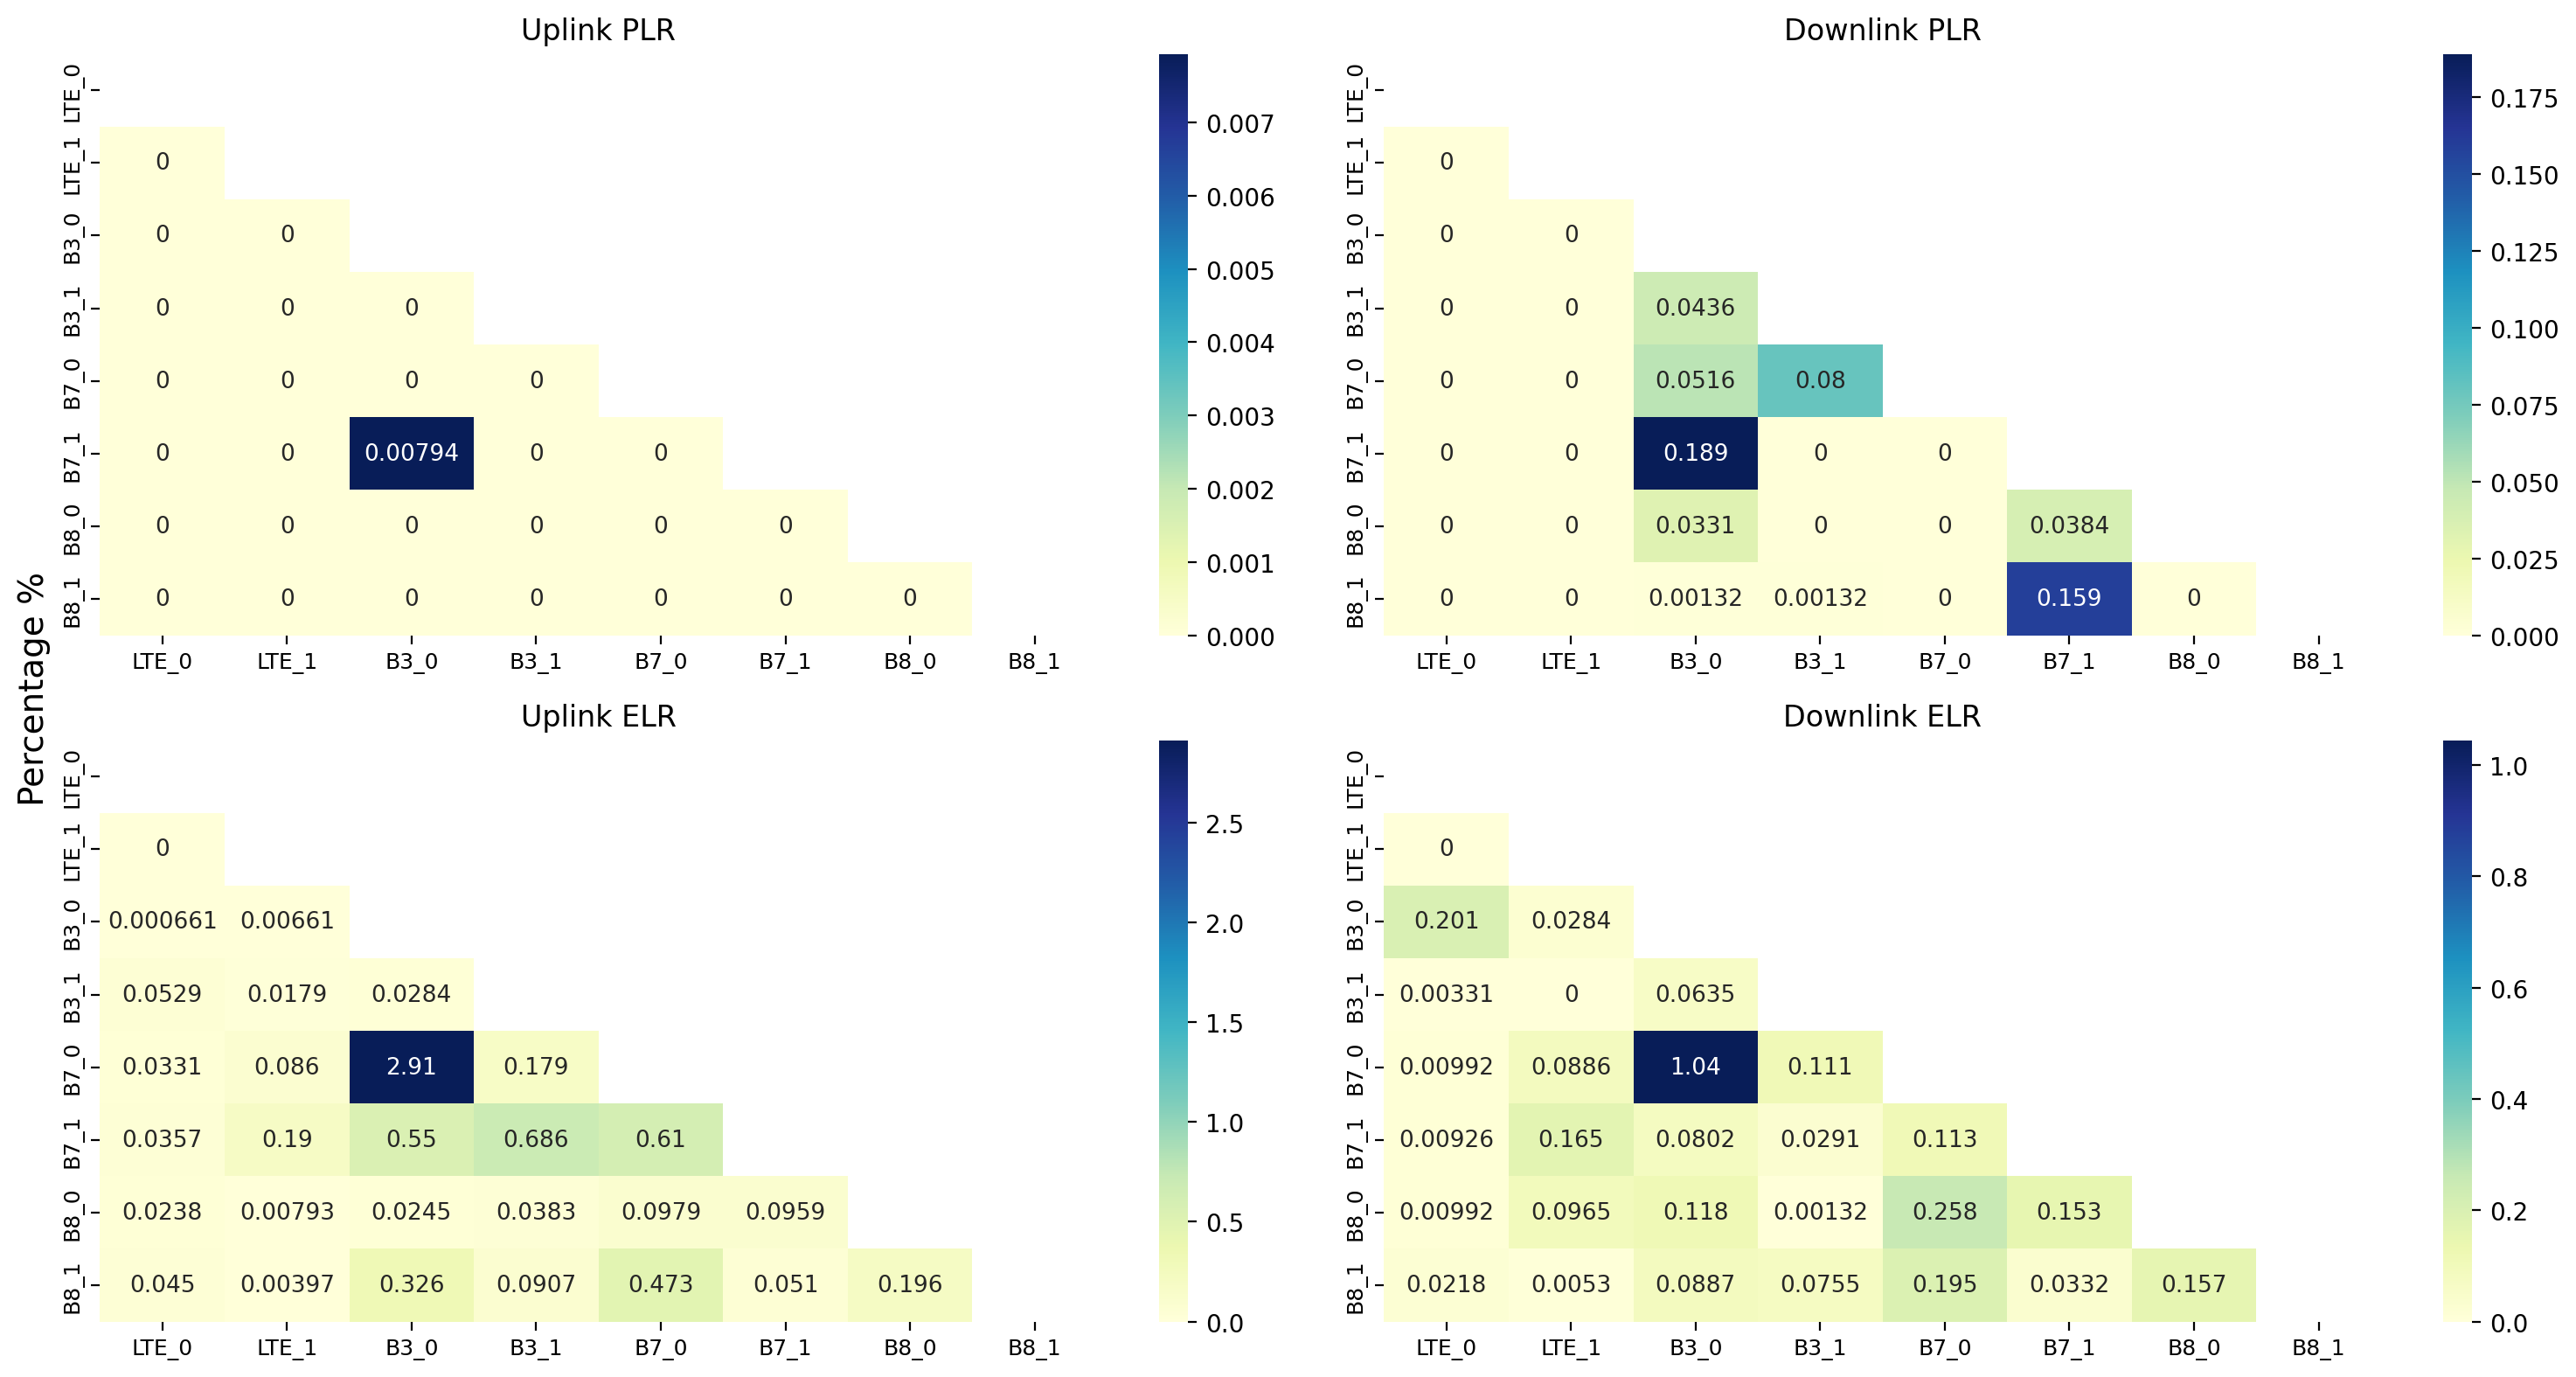

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #04


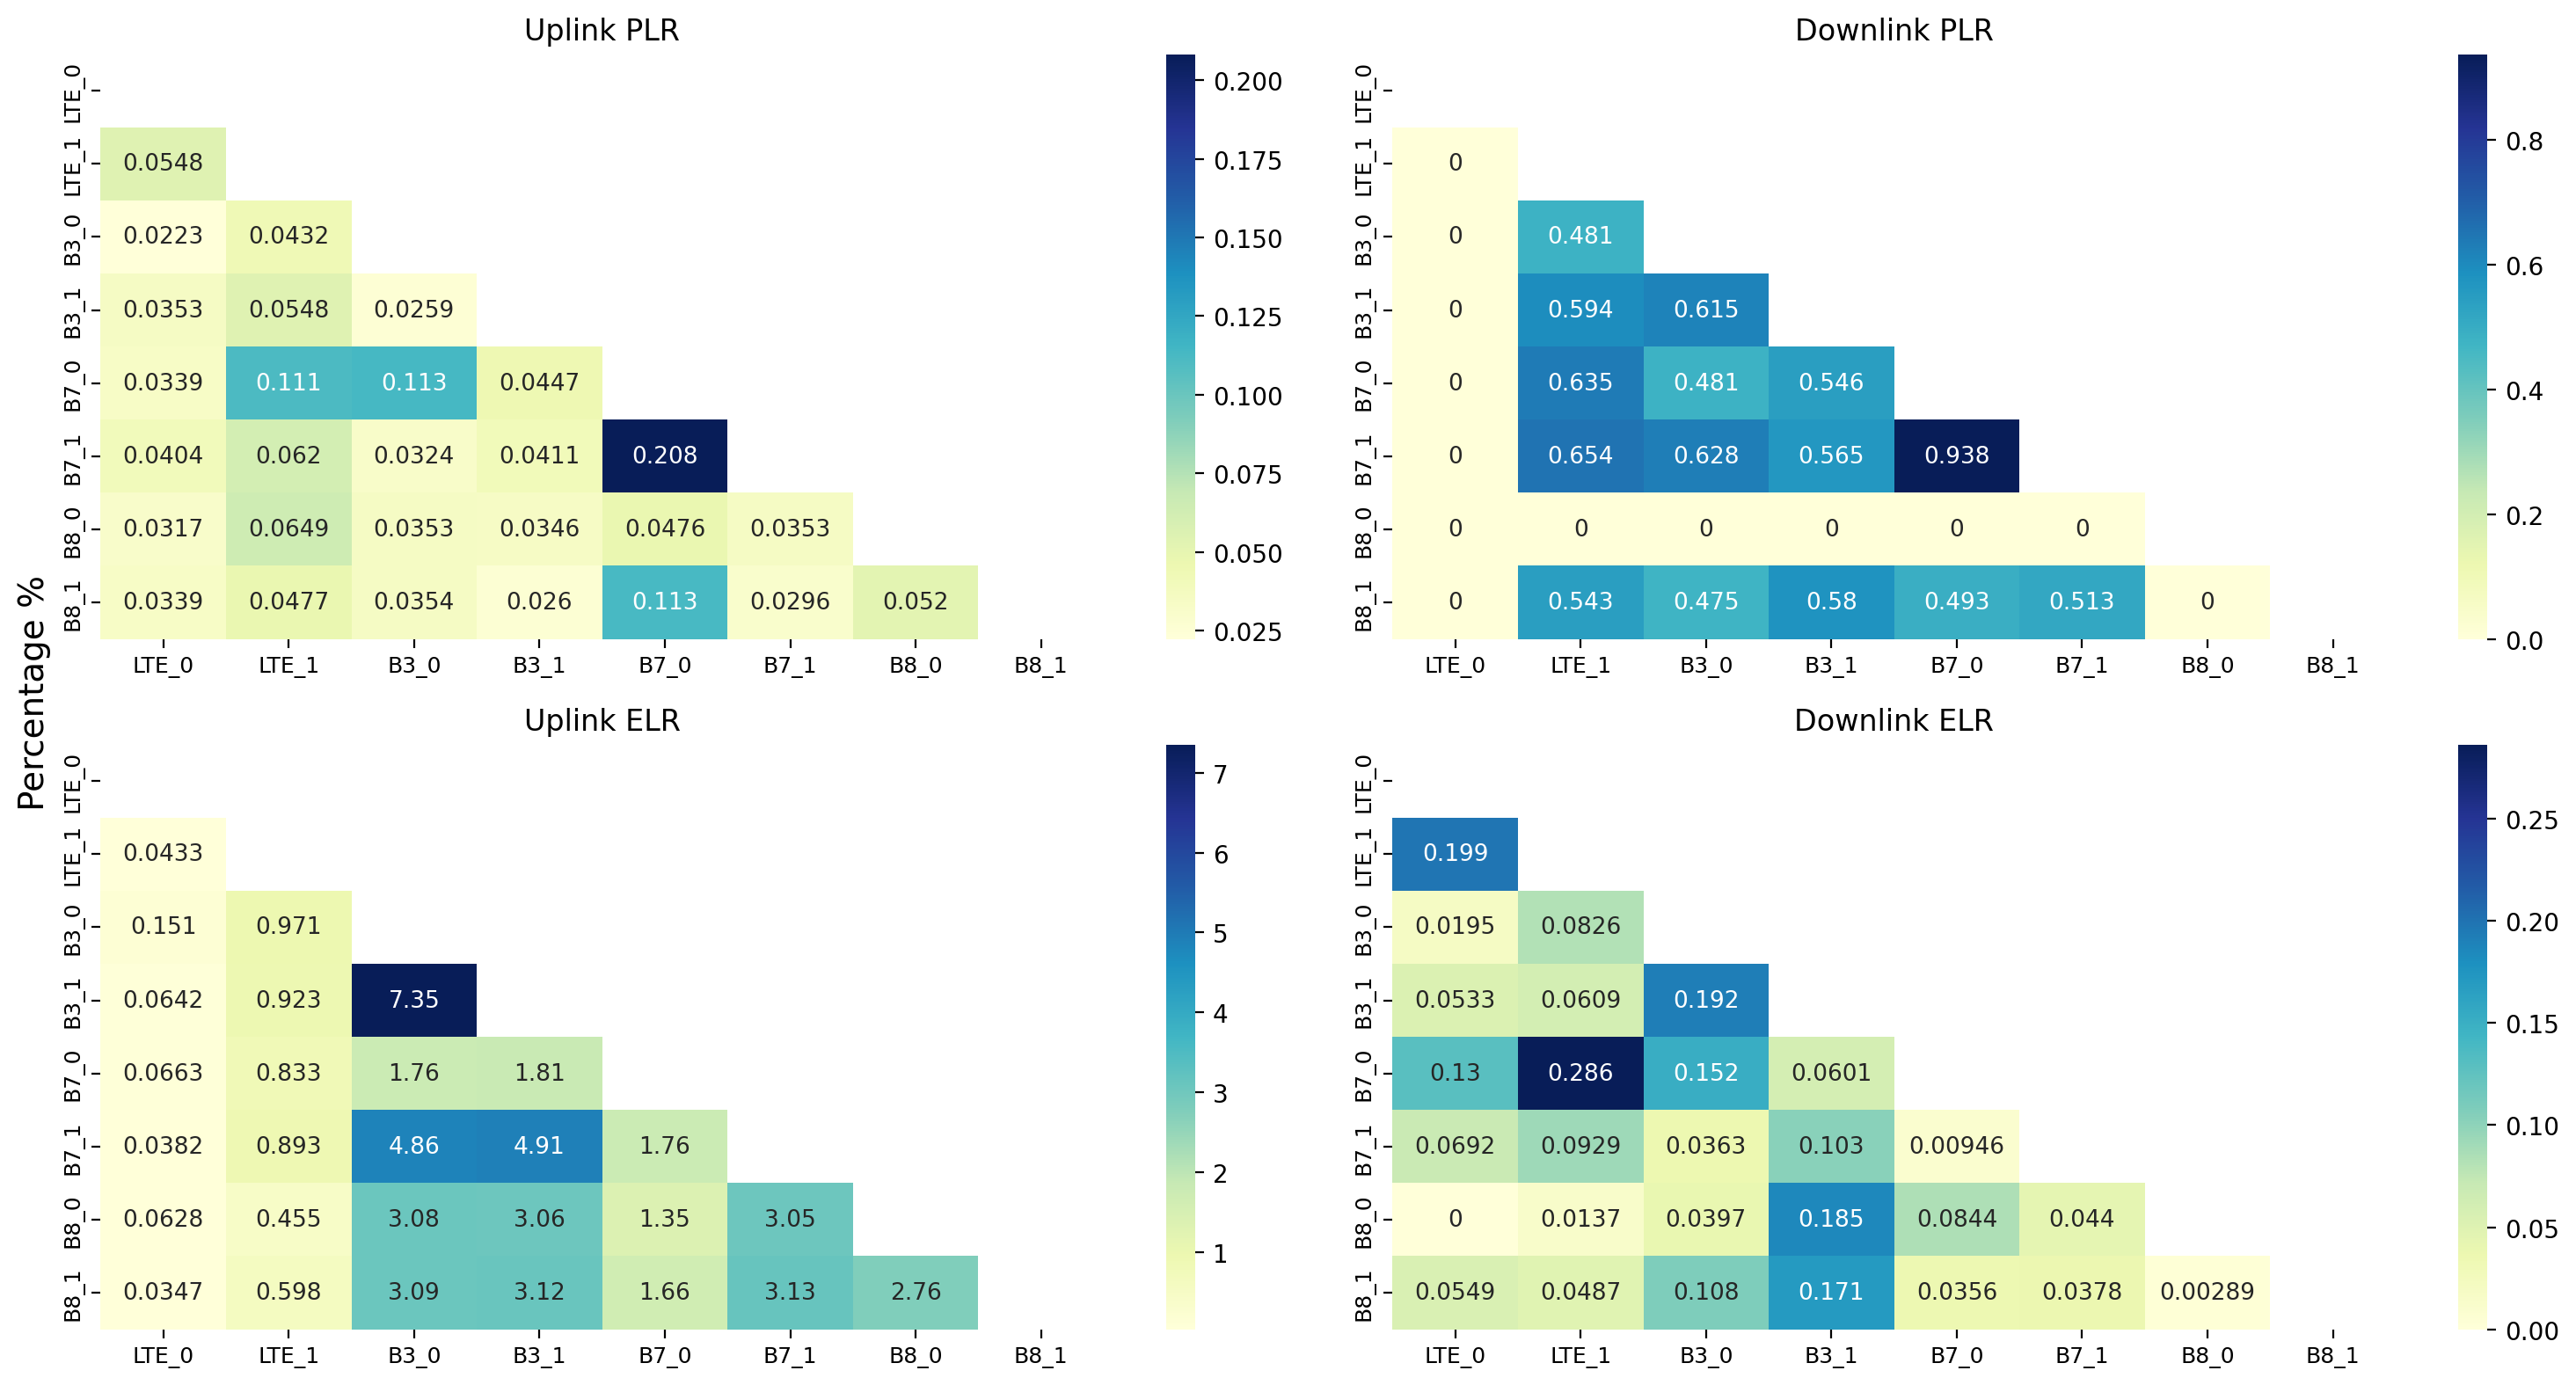

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #05


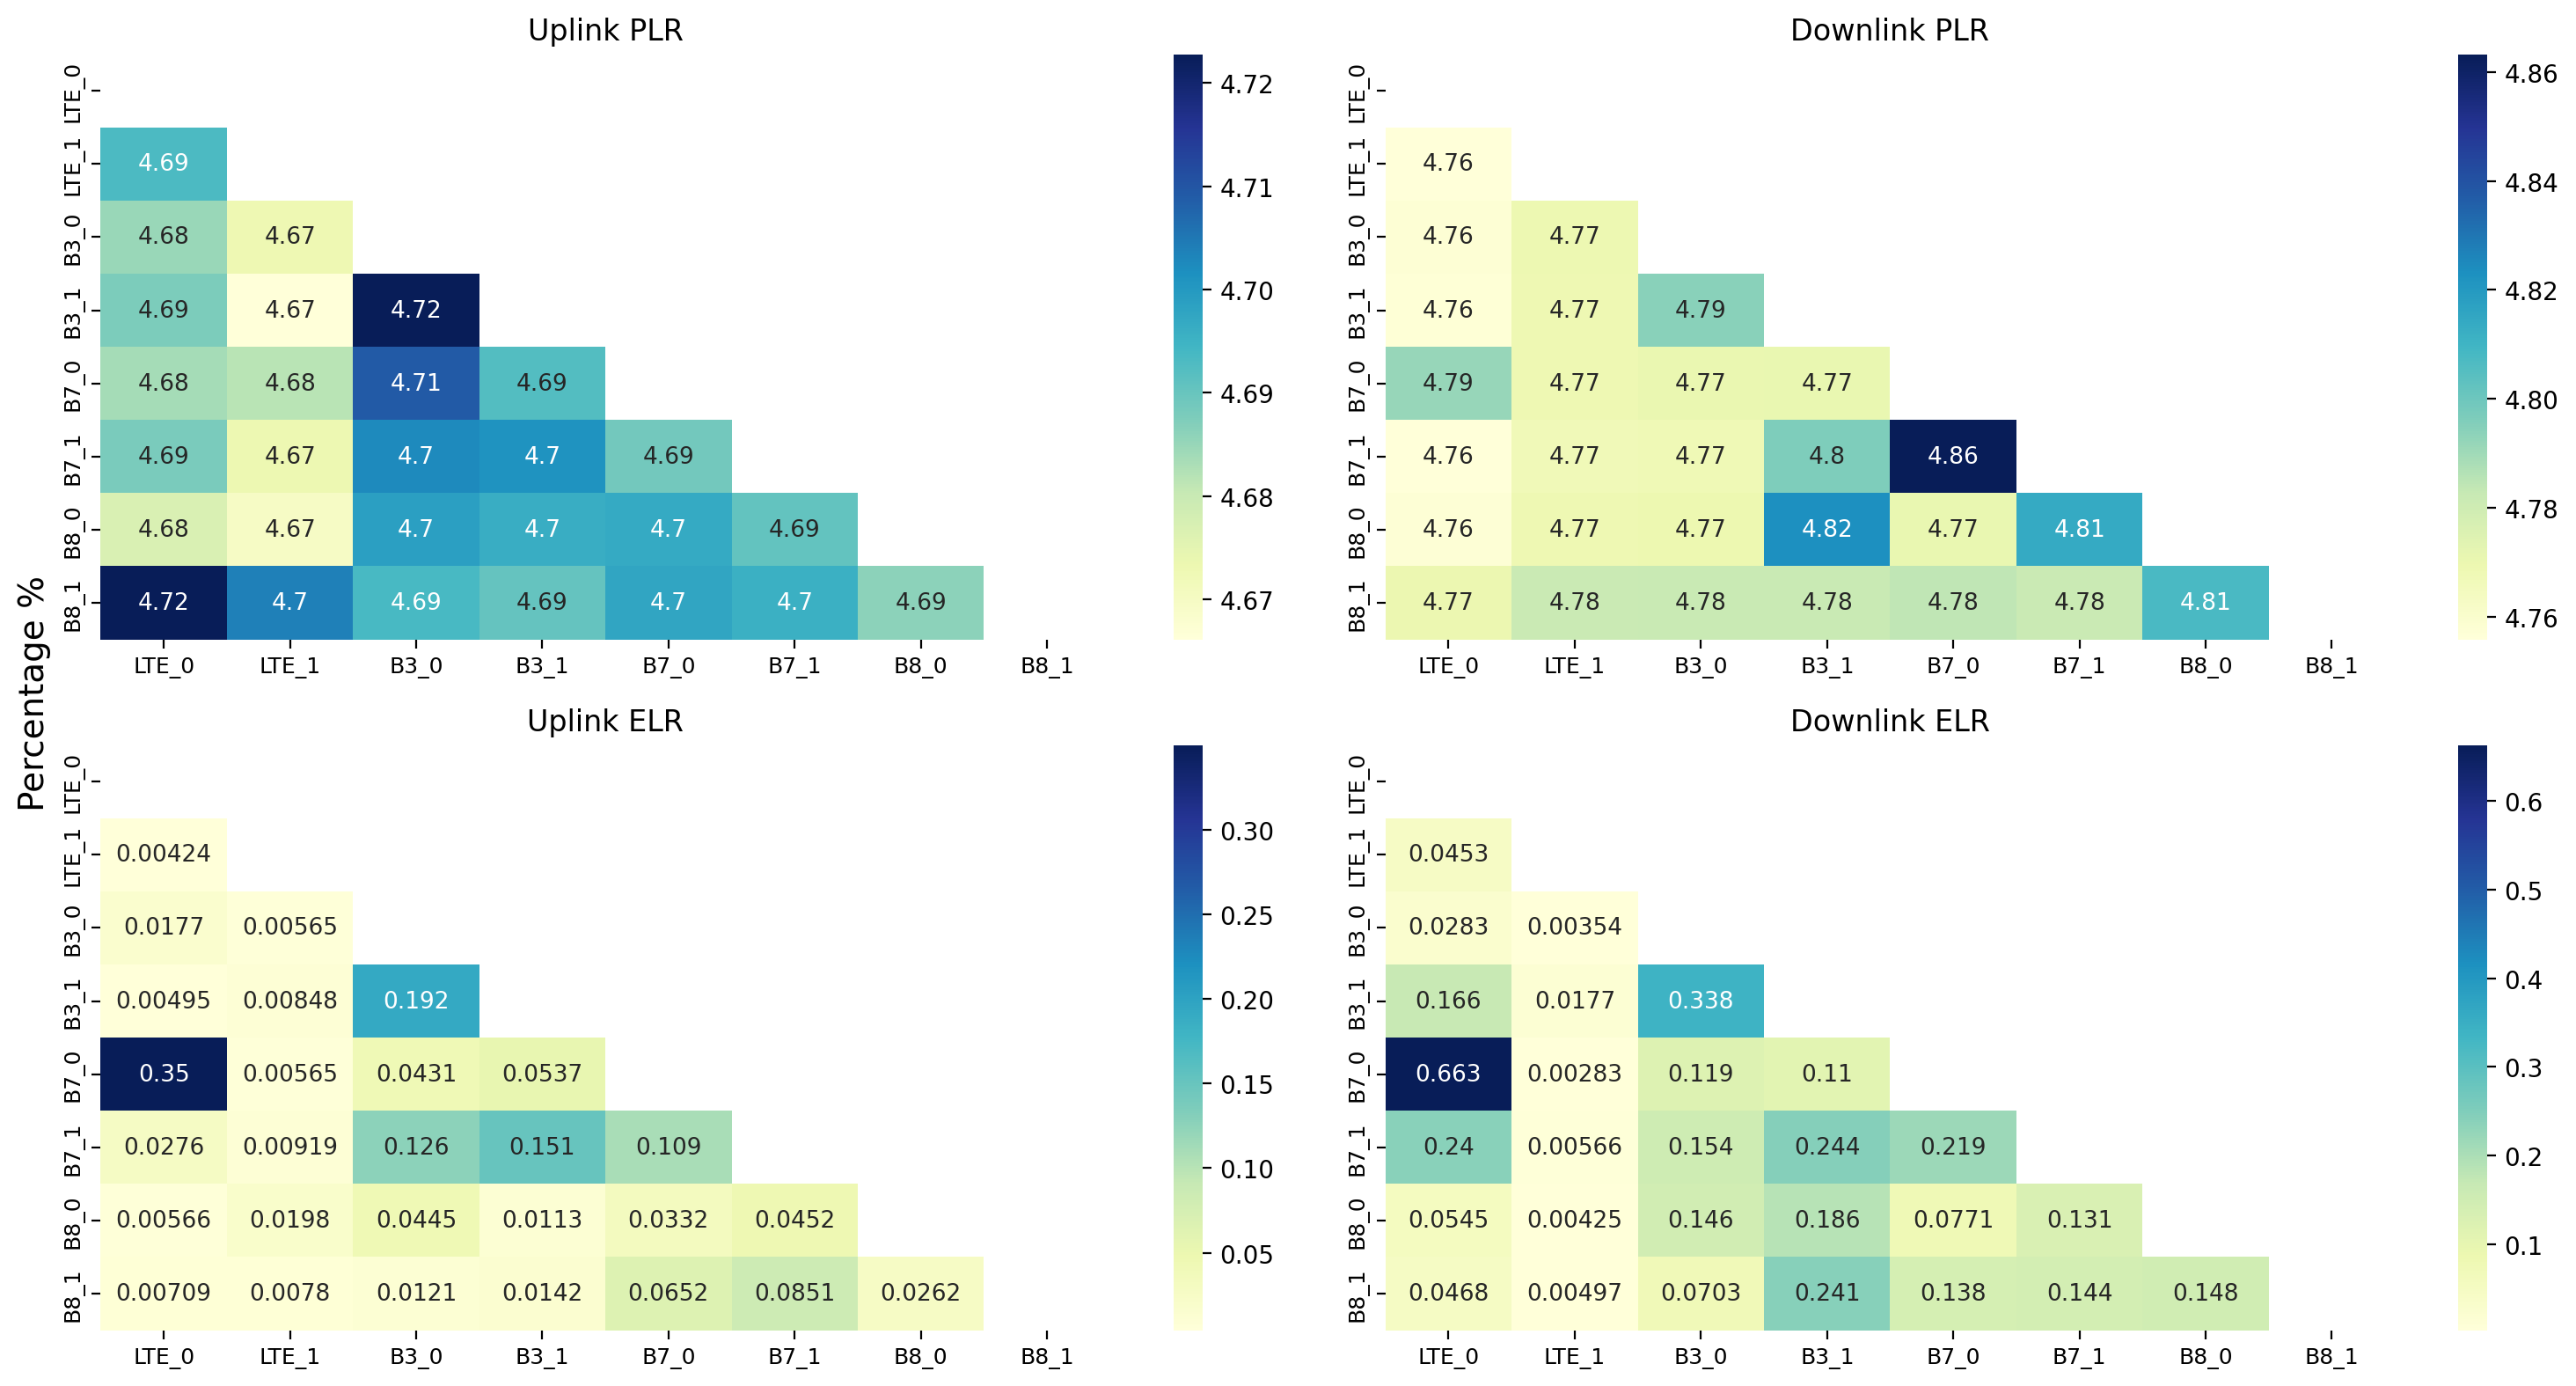

2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> #06


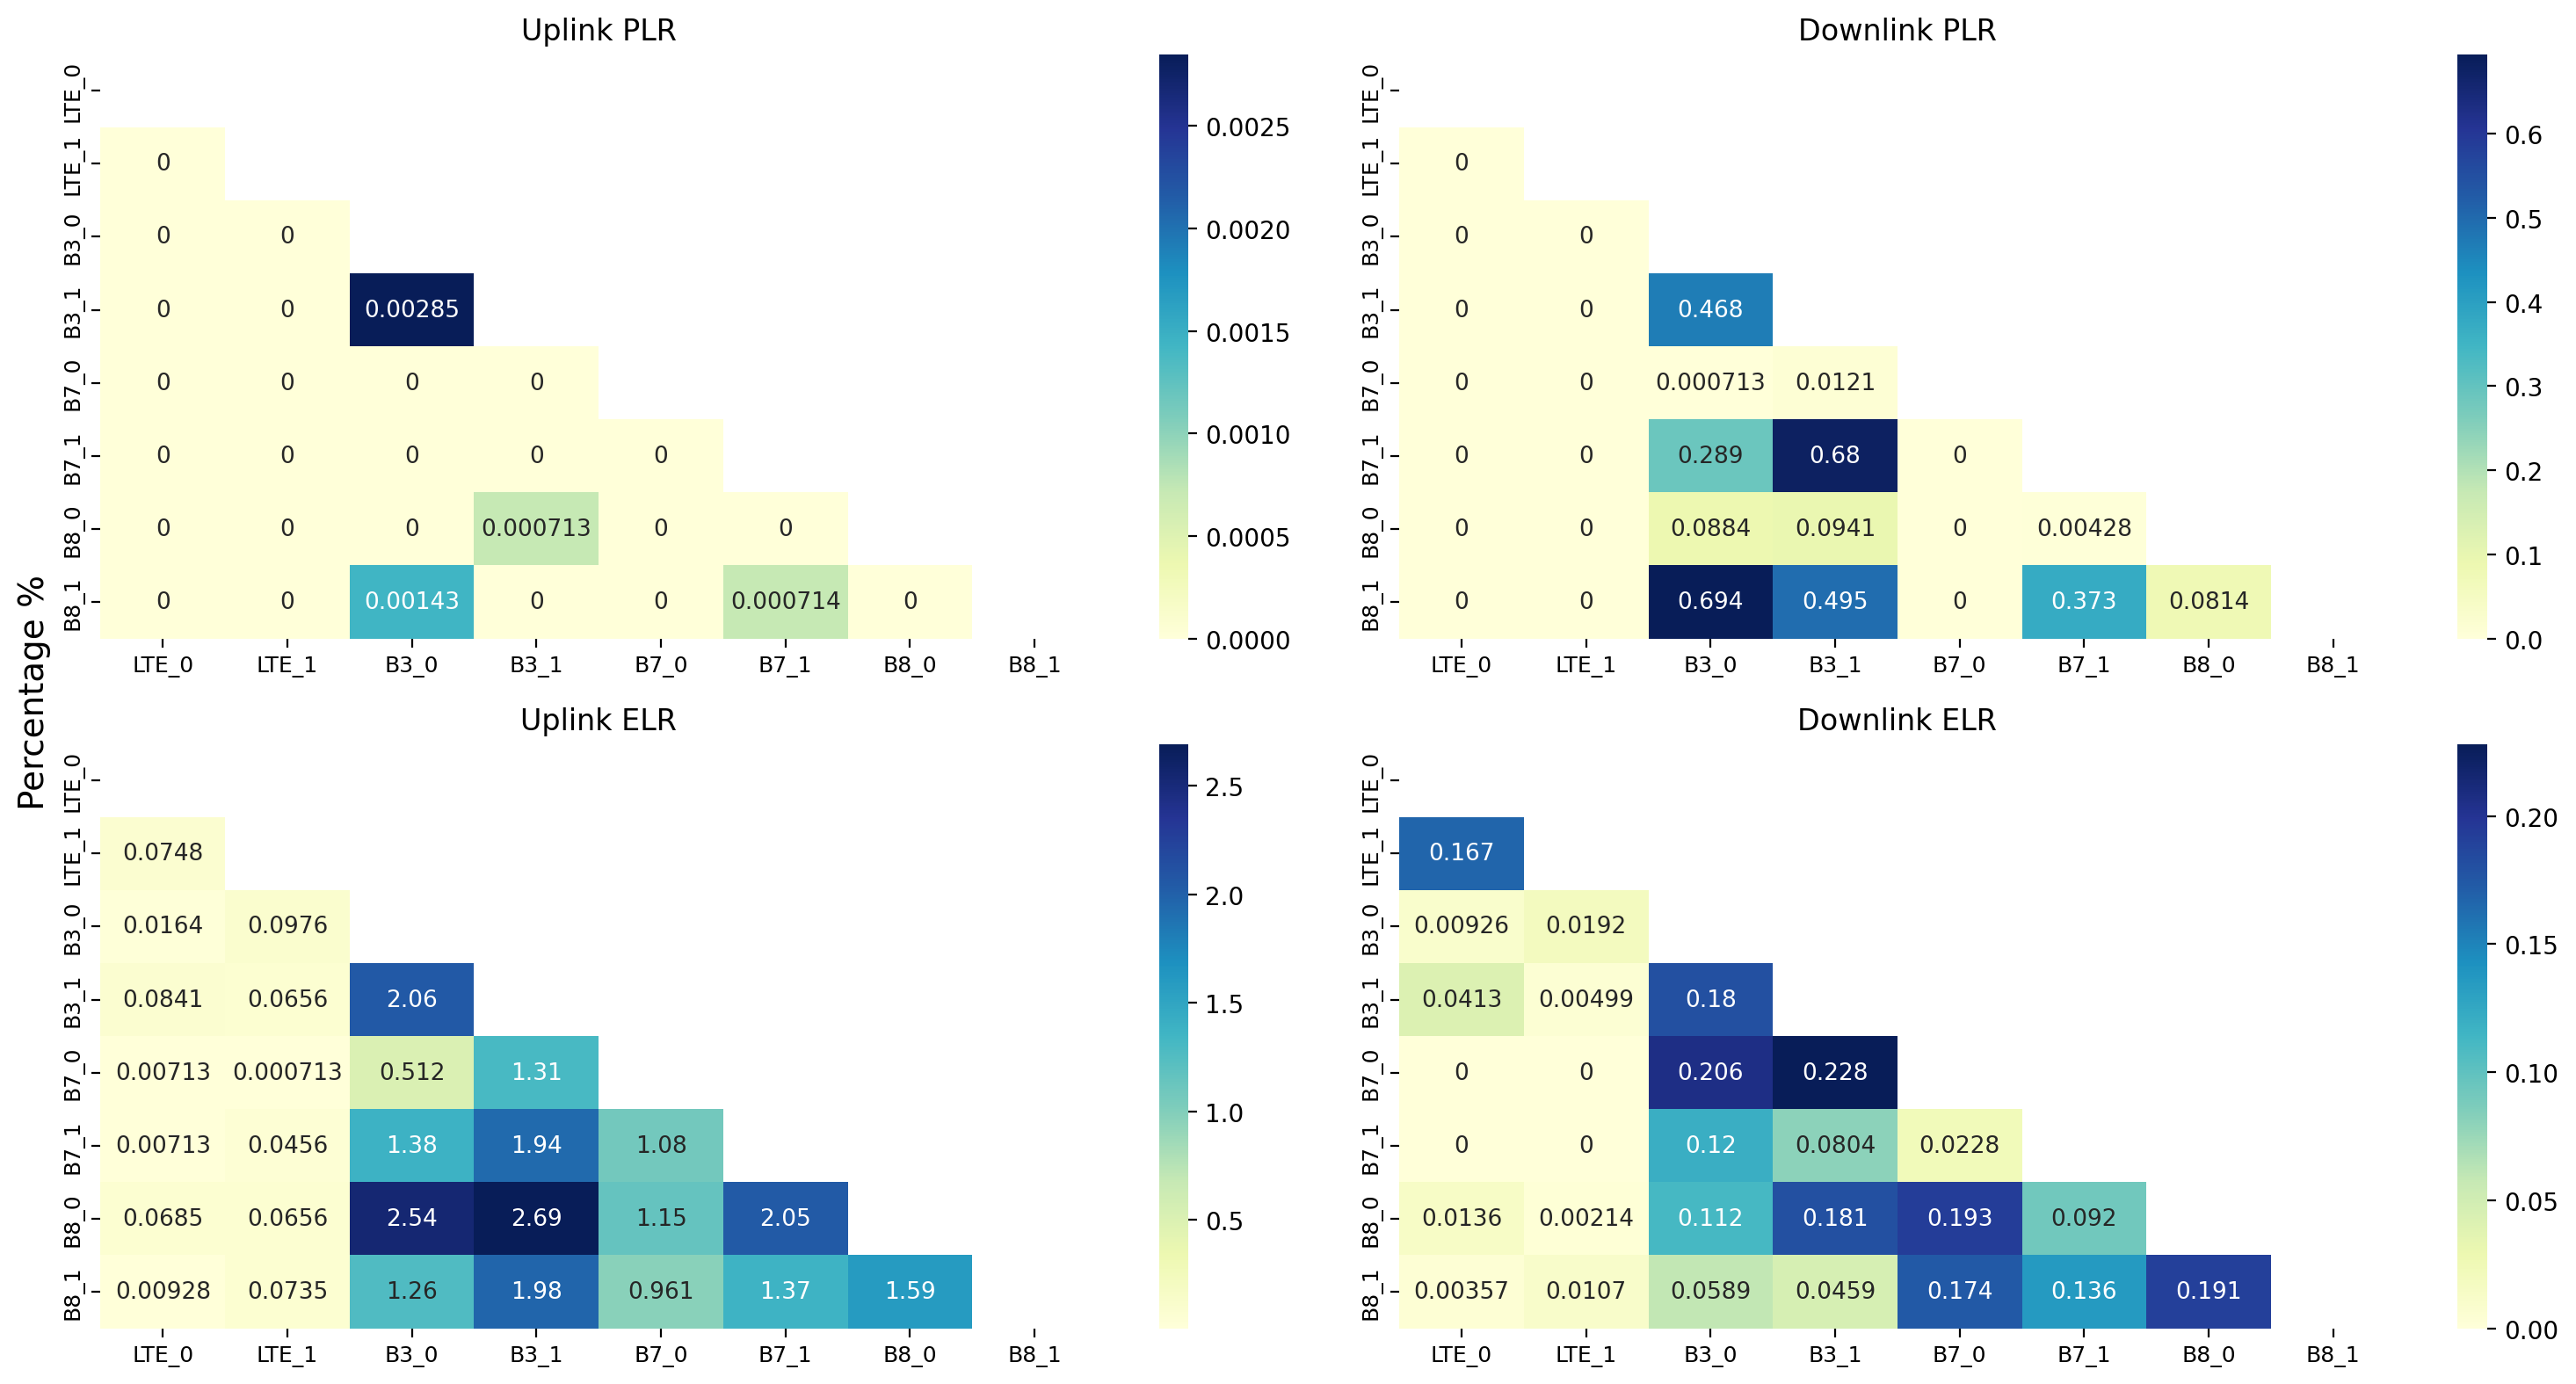

In [16]:
def mask(size, mode='lower', diag=True):
    
    mask = np.ones((size, size))
    if mode == 'lower': # 保留下三角(遮蔽上三角)
        mask[np.tril_indices(size)] = 0
    elif mode == 'upper': # 保留上三角(遮蔽下三角)
        mask[np.triu_indices(size)] = 0
    elif mode == 'square': # 全保留
        mask = np.zeros((size, size))
    else:
        print(f"Warning: mask() has no option '{mode}' for argument: 'mode'.")
        print("Please specify 'upper', 'lower', or 'square' instead.")
    
    if not diag: # 不保留對角線(遮蔽對角線)
        mask[np.diag_indices(size)] = 1

    return mask

for expr, metrics_dict in zip(exp_list, dual_metrics_list):

    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)
    display(expr.metadata_dual)
    
    ### 建立表格方便製圖
    metrics_table = {}
    for pos, tag in enumerate(['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']):
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        # 根據字典建立好閱讀的表格
        metrics_table[tag] = pd.DataFrame(data={k: [num if num >= 0 else '-' for num in v[tag]] for k, v in metrics_dict.items()}, index=expr.traces).reset_index().rename(columns={'index':'Tr.'})
        # print(f'{title} DataFrame:')
        # display(metrics_table[tag])
    
    size = len(expr.setting)
    schemes = metrics_table[tag].columns[1:size+1]
    schm_list = metrics_table[tag].columns[size+1:]
    for i, tag in enumerate(['ul_loss', 'dl_loss', 'ul_excl', 'dl_excl']):
        title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
        print(f'{title} Ranking:')
        
        ### Single Radio Ranking
        display(expr.ranking[tag])
        
        ### Dual Radio Ranking
        ranking_dict = {}
        data_dict = {k: v[tag] for k, v in metrics_dict.items()}
        score_dict = {k: [] for k in schm_list}
        for i, tr in enumerate(expr.traces):
            # print(i, tr)
            data = [v[i] for v in data_dict.values()][size:]
            data = [num if num >= 0 else np.inf for num in data]
            na_indices = [i for i, num in enumerate(data) if np.isinf(num)]
            
            sorted_indices = [i for i, x in sorted(enumerate(data), key=lambda x: x[1])]
            ranking = np.zeros(len(data))
            ranking[sorted_indices] = np.arange(1, len(data) + 1)
            ranking[na_indices] = np.nan
            # ranking = [num if not np.isnan(num) else '-' for num in ranking]
            ranking_dict[tr] = {k: v for k, v in zip(schm_list, ranking)}
            
            # _ranking = [num for num in ranking if num != '-']
            _ranking = [num for num in ranking if not np.isnan(num)]
            _max = max(_ranking); _min = min(_ranking)
            for k, rank in zip(schm_list, ranking):
                if rank == _min: score_dict[k].append(3)
                elif rank == _min + 1: score_dict[k].append(2)
                elif rank == _min + 2: score_dict[k].append(1)
                elif rank == _max - 1: score_dict[k].append(-1)
                elif rank == _max - 2: score_dict[k].append(-2)
                elif rank == _max: score_dict[k].append(-3)
                else: score_dict[k].append(0)
        
        score = [sum(v) for v in score_dict.values()]
        ranking_dict['Score'] = {k: v for k, v in zip(schm_list, score)}
        
        sorted_indices = [i for i, x in sorted(enumerate(score), key=lambda x: x[1], reverse=True)]
        score_ranking = np.zeros(len(score))
        score_ranking[sorted_indices] = np.arange(1, len(score) + 1)
        ranking_dict['Ranking'] = {k: round(v) for k, v in zip(schm_list, score_ranking)}
        
        ranking_table = pd.DataFrame.from_dict(ranking_dict, orient='index') #.reset_index().rename(columns={'index':'Tr.'})
        
        expr.ranking_dual[tag] = ranking_table
        display(ranking_table)
    
    ### Plotting: Per Round
    size = len(expr.setting)
    schemes = add_suffix_to_duplicate_category(expr.setting.values())
    combinations = ['+'.join(s) if s[0] != s[1] else s[0] for s in it.product(schemes, repeat=2)]
    for idx, tr in enumerate(expr.traces):
        print(f'{expr.date} | {expr.name} -> {tr}')
        
        # for ndiag in [False, True]:
        for ndiag in [True]:
            fig, axes = plt.subplots(2, 2, figsize=(15, 8))
            for pos, tag in enumerate(['ul_loss', 'ul_excl', 'dl_loss', 'dl_excl']):
                title = ' '.join(tag.split('_')).replace('ul', 'Uplink').replace('dl', 'Downlink').replace('loss', 'PLR').replace('excl', 'ELR')
                i = pos % 2; j = pos // 2
                
                data = [metrics_dict[comb][tag][idx] if comb in metrics_dict else -1 for comb in combinations]
                data = [num if num >= 0 else np.nan for num in data]
                reshaped_data = np.array(data).reshape(size, size)
                sns.heatmap(reshaped_data.T, ax=axes[i][j], annot=True, fmt='.3g', mask=mask(size, diag=not ndiag), annot_kws={"size": 9.5}, cmap="YlGnBu")
                axes[i][j].set_xticklabels(schemes, fontsize=9)
                axes[i][j].set_yticklabels(schemes, fontsize=9)
                axes[i][j].set_title(title)
                
                # 在相应位置上标注"N/A"
                _mask = mask(size, diag=not ndiag)
                rows, cols = reshaped_data.shape
                for k in range(rows):
                    for l in range(cols):
                        if np.isnan(reshaped_data.T[k][l]) and _mask[k][l] == 0:
                            axes[i][j].text(l + 0.5, k + 0.5, "N/A", ha='center', va='center', color='red', fontweight='bold')
            
            fig.text(0.0, 0.5, 'Percentage %', ha='center', va='center', rotation='vertical', fontsize=14)
            
            plt.tight_layout()
            plt.show()

# Trace Inspector

(1) 2個radio 的 packet loss 不同顏色疊在一起

(2) 兩者的 Latency （100ms 為閾值）

(3) 2個radio 的 handover 的發生時間，上為 radio 1，下為 radio 2，數字標間隔時間

(4) 兩者的 serving RSRP (PCI, band 變化，上為 radio 1) 最強的兩個 neighboring RSRP

(5) 兩者的 serving NR RSRP (PCI, band 變化，下為 radio 2) 最強的兩個 neighboring RSRP

(PCI1, EARFCN1, NRPCI1) -> (PCI2, EARFCN2, NRPCI2)

In [17]:
all_path = namedtuple('all_path', ['rrc_path', 'lte_path', 'nr_path', 'ul_path', 'dl_path'])

def find_selected_filepath(id, tr, dev):

    try:
        index = look_up_table[id]
        # print(f'Exp ({id}, {dev}, {tr}) look up succeed!')
    except:
        id_not_found = 1
        for i, expr in enumerate(exp_list):
            if "{:02d}".format(id) == expr.id:
                id_not_found = 0
                look_up_table[id] = i
                index = i
                break
        if id_not_found:
            print(f'Exp id: {id} not found!')
            return '','','','',''
            
    if isinstance(tr, str):
        # tr_name = tr
        tr_index = exp_list[index].traces.index(tr)
    else:
        # tr_name = exp_list[index].traces[tr]
        tr_index = tr
    
    rrc_path = exp_list[index].rrc_paths[dev][tr_index]
    lte_path = exp_list[index].lte_paths[dev][tr_index]
    nr_path = exp_list[index].nr_paths[dev][tr_index]
    ul_path = exp_list[index].ul_paths[dev][tr_index]
    dl_path = exp_list[index].dl_paths[dev][tr_index]
    
    return all_path(rrc_path, lte_path, nr_path, ul_path, dl_path)

## Dual Radio

In [18]:
for expr in exp_list:
    print(f'Experiment {expr.id}: {expr.date} | {expr.name} -> {expr.traces}')
    display(expr.metadata)

Experiment 21: 2023-06-15 | Bandlock_All_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04']


Device Schm              Traces  avg_ul_loss  ul_loss_rank  avg_dl_loss  \
0   sm00  All  #01, #02, #03, #04     0.182736             3     0.885669   
1   sm01  All  #01, #02, #03, #04     0.247022             6     0.372318   
2   sm02   B3  #01, #02, #03, #04     0.267928             7     0.569565   
3   sm03   B3  #01, #02, #03, #04     0.153070             1     0.552534   
4   sm04   B7  #01, #02, #03, #04     0.228942             5     0.781969   
5   sm05   B7  #01, #02, #03, #04     0.270580             8     0.553683   
6   sm06   B8  #01, #02, #03, #04     0.185060             4     0.358295   
7   sm07   B8  #01, #02, #03, #04     0.176184             2     0.433662   

   dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  dl_excl_rank  
0             8     2.479350             3     0.703689             6  
1             2     2.296236             2     0.733978             7  
2             6     5.387217             8     0.518028             1  
3             4     3.708158             6     0.655377             3  
4             7     3.402995             5     0.670492             4  
5             5     2.873413             4     0.863718             8  
6             1     4.996779             7     0.610143             2  
7             3     1.909734             1     0.684051             5

Experiment 22: 2023-06-15 | Bandlock_LTE_B3_B7_B8_Dupl_Phone -> ['#01', '#02', '#03', '#04', '#05', '#06']


Device Schm                        Traces  avg_ul_loss  ul_loss_rank  \
0   sm00  LTE  #01, #02, #03, #04, #05, #06     0.981971             1   
1   sm01  LTE  #01, #02, #03, #04, #05, #06     1.068856             6   
2   sm02   B3  #01, #02, #03, #04, #05, #06     1.052997             4   
3   sm03   B3  #01, #02, #03, #04, #05, #06     1.054423             5   
4   sm04   B7  #01, #02, #03, #04, #05, #06     1.352583             8   
5   sm05   B7  #01, #02, #03, #04, #05, #06     1.072479             7   
6   sm06   B8  #01, #02, #03, #04, #05, #06     0.992900             2   
7   sm07   B8  #01, #02, #03, #04, #05, #06     1.033073             3   

   avg_dl_loss  dl_loss_rank  avg_ul_excl  ul_excl_rank  avg_dl_excl  \
0     0.798483             1     1.124713             2     1.084587   
1     0.961297             2     0.661598             1     1.080206   
2     1.728231             6     5.214067             8     0.783888   
3     1.675717             5     3.652676             7     0.496062   
4     2.161050             7     2.830331             5     0.831878   
5     2.280974             8     3.266161             6     0.730304   
6     1.036093             3     2.564579             4     0.495090   
7     1.476035             4     2.474258             3     0.604603   

   dl_excl_rank  
0             8  
1             7  
2             5  
3             2  
4             6  
5             4  
6             1  
7             3

In [19]:
# TODO: Select Traces
expr_id = 22; expr_tr = '#02'
dev1 = 'sm05'
dev2 = 'sm06'

In [28]:
dfs = {'ho': [], 'lte': [], 'nr': [], 'ul': [], 'dl': []}
filepath1 = find_selected_filepath(expr_id, expr_tr, dev1)
filepath2 = find_selected_filepath(expr_id, expr_tr, dev2)

for path1, path2, key in zip(filepath1, filepath2, dfs.keys()):
    print(key)
    print(path1)
    print(path2)
    if not (os.path.isfile(path1) and os.path.isfile(path2)):
        dfs[key].append(pd.DataFrame())
        dfs[key].append(pd.DataFrame())
    else:
        df1 = pd.read_pickle(path1) if path1.endswith('.pkl') else pd.read_csv(path1)
        df2 = pd.read_pickle(path2) if path2.endswith('.pkl') else pd.read_csv(path2)
        if key in ['ho']:
            df1, _, _ = mi_parse_ho(df1, tz=8)
            df2, _, _ = mi_parse_ho(df2, tz=8)
            df1['ho_type0'] = df1['ho_type'].astype('string')
            df2['ho_type0'] = df2['ho_type'].astype('string')
            df1.loc[df1['cause'].notna(), 'ho_type0'] = df1['ho_type'].astype('string') + '_' + df1['cause'].astype('string')
            df2.loc[df2['cause'].notna(), 'ho_type0'] = df2['ho_type'].astype('string') + '_' + df2['cause'].astype('string')
            df1['ho_type0'] = df1['ho_type0'].astype('category')
            df2['ho_type0'] = df2['ho_type0'].astype('category')
        elif key in ['lte', 'nr']:
            df1 = set_data(df1, mode=key, tz=8)
            df2 = set_data(df2, mode=key, tz=8)
        else:
            df1 = set_data(df1)
            df2 = set_data(df2)

        dfs[key].append(df1)
        dfs[key].append(df2)

for key in ['ul', 'dl']:
    st_seq = max([dfs[key][0]['seq'].array[0], dfs[key][1]['seq'].array[0]])
    ed_seq = min([dfs[key][0]['seq'].array[-1], dfs[key][1]['seq'].array[-1]])
    dfs[key][0] = dfs[key][0][(dfs[key][0]['seq'] >= st_seq) & (dfs[key][0]['seq'] <= ed_seq)].reset_index(drop=True)
    dfs[key][1] = dfs[key][1][(dfs[key][1]['seq'] >= st_seq) & (dfs[key][1]['seq'] <= ed_seq)].reset_index(drop=True)

st_time = min(dfs['ul'][0]['Timestamp'].array[0], dfs['ul'][1]['Timestamp'].array[0], dfs['dl'][0]['Timestamp'].array[0], dfs['dl'][1]['Timestamp'].array[0])
ed_time = min(dfs['ul'][0]['Timestamp'].array[-1], dfs['ul'][1]['Timestamp'].array[-1], dfs['dl'][0]['Timestamp'].array[-1], dfs['dl'][1]['Timestamp'].array[-1])
for key in ['ho', 'lte', 'nr']:
    dfs[key][0] = dfs[key][0][(dfs[key][0]['Timestamp'] > st_time) & (dfs[key][0]['Timestamp'] < ed_time)].reset_index(drop=True)
    dfs[key][1] = dfs[key][1][(dfs[key][1]['Timestamp'] > st_time) & (dfs[key][1]['Timestamp'] < ed_time)].reset_index(drop=True)

ho
/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm05/#02/data/diag_log_sm05_2023-06-15_16-07-01_rrc.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm06/#02/data/diag_log_sm06_2023-06-15_16-07-01_rrc.pkl
lte
/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm05/#02/data/diag_log_sm05_2023-06-15_16-07-01_ml1.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm06/#02/data/diag_log_sm06_2023-06-15_16-07-01_ml1.pkl
nr
/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm05/#02/data/diag_log_sm05_2023-06-15_16-07-01_nr_ml1.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm06/#02/data/diag_log_sm06_2023-06-15_16-07-01_nr_ml1.pkl
ul
/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm05/#02/data/udp_uplk_loss_latency.pkl
/Us

/var/folders/vy/w6g3hxgj76s0gzty27t2d6gm0000gn/T/ipykernel_14404/2934229583.py:64: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1


dl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm05/#02/data/udp_dnlk_loss_latency.pkl
/Users/jackbedford/Desktop/MOXA/Code/data/2023-06-15/Bandlock_LTE_B3_B7_B8_Dupl_Phone/sm06/#02/data/udp_dnlk_loss_latency.pkl


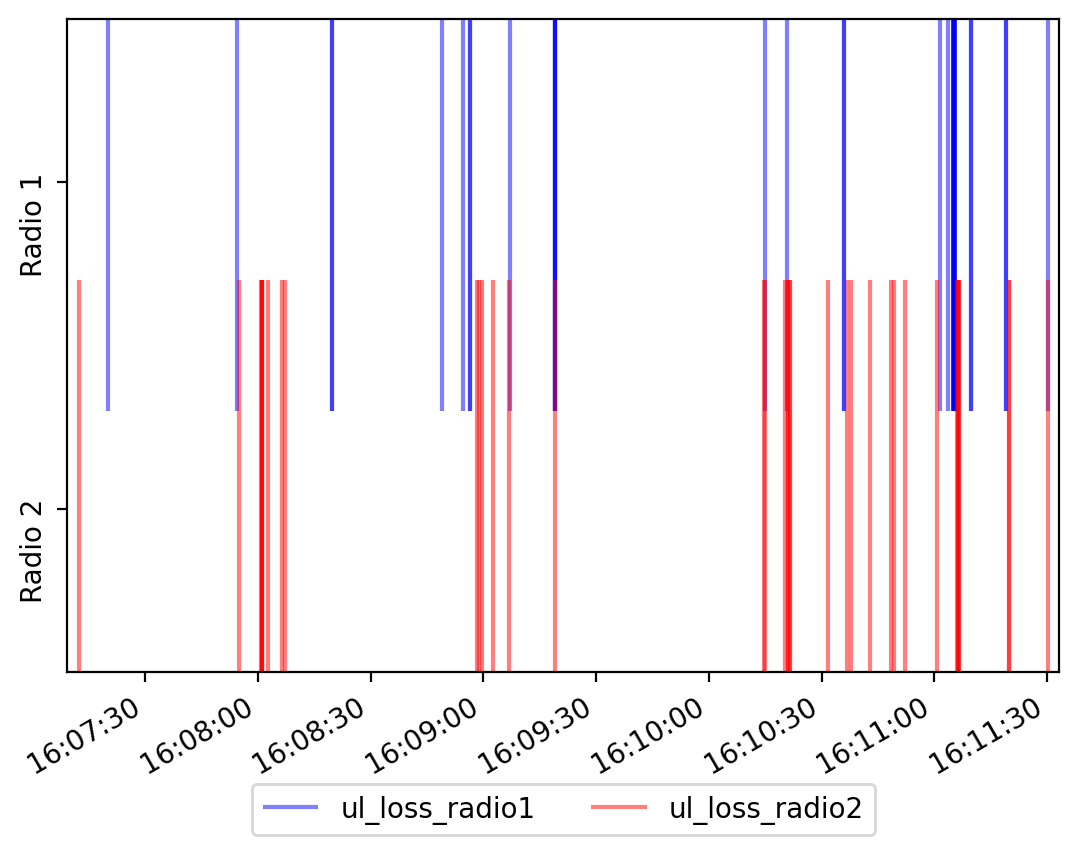

In [75]:
loss1 = list(dfs['ul'][0].loc[dfs['ul'][0]['lost'] == True, "Timestamp"].iloc[:])
loss2 = list(dfs['ul'][1].loc[dfs['ul'][1]['lost'] == True, "Timestamp"].iloc[:])

# 创建画布和坐标轴
fig, ax = plt.subplots()

# 绘制蓝色縱線
ax.vlines(loss1, ymin=0.4, ymax=1, color='b', alpha=0.5)

# 绘制红色縱線
ax.vlines(loss2, ymin=0, ymax=0.6, color='r', alpha=0.5)

# 添加圖例
ax.legend(['ul_loss_radio1', 'ul_loss_radio2'], loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=2)

# 設置x軸時間上下限
start_time = min(min(loss1), min(loss2)) - pd.Timedelta(seconds=3)
end_time = max(max(loss1), max(loss2)) + pd.Timedelta(seconds=3)
ax.set_xlim(start_time, end_time)

# 設置y軸上下限
ax.set_ylim(0, 1)

# 格式化x轴为日期时间
plt.gcf().autofmt_xdate()

# 格式化y軸標示
plt.yticks([0.75, 0.25], ["Radio 1", "Radio 2"], rotation='vertical')

# 显示图像
plt.show()